<a href="https://colab.research.google.com/github/anupmerkap87/Diagnosing-depression-using-EEG/blob/main/Code/Build_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary libraries

In the part-1 of the notebook, we extracted the EEG waveform. In this notebook, we are going to understand the features that differentiate between the MDD (Depression) and HC (Healthy Controls) participants. The flow of the notebook -

*   Data import and combining dataset
*   Data Exploration
*   Feature Engineering through PCA
*   Classification models
*   Model Interpretation
*   Results

In [ ]:
#Necessary to build Shappley Additive Explanations
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [ ]:
#Libraries helping with file retrival
import os
from os import listdir
from os.path import isfile, join

#Visualization and data manipulation libraries
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, lfilter
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.2)

#Model development and understanding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data import and Combining datasets

In the earlier workbook, we created EEG waveform in resting phase and ERP (activity) phase. Along with this, the research team also provided rich demographic data. We will be utilizing the demographic data to understand the bias present in the dataset

In [ ]:
#Import ERP dataframe
df_erp = pd.read_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/ERP_Summary_limited.csv')
#Import Resting dataframe
df_resting = pd.read_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Resting_Summary_limited.csv')
#Import demographics table
df_demog = pd.read_excel('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx',sheet_name = 'Sheet1')

In [ ]:
#Lets first create a patient identifier key
df_erp['patient_identifier']= [i[:8] for i in df_erp['patient_identifier']]
df_erp['patient_identifier'] = df_erp['patient_identifier'].astype(int)
df_resting['patient_identifier']= [i[:8] for i in df_resting['patient_identifier']]
df_resting['patient_identifier'] = df_resting['patient_identifier'].astype(int)

In [ ]:
#Combining the datasets
#Step - 1: Merge Demog Data
intermediate_df = pd.merge(df_erp,df_demog,left_on = 'patient_identifier',right_on = 'subject id',how ='inner')
#Merge Resting Data
df = pd.merge(intermediate_df,df_resting,left_on = 'patient_identifier',right_on = 'patient_identifier',how ='inner')
#Set Patient Identifier as index and delete some columns
df.set_index('patient_identifier',inplace=True)
df.drop(columns = ['Unnamed: 11', 'Unnamed: 12','subject id'],inplace = True)

In [ ]:
#Explore the dataset
print("# of Patients:"+str(df.shape[0]))
print("******Understading Features******")
print("# of Electrode:16")
print("\n***Linear Features***")
print("# of Linear Features by emotion (Fear, Happy, Sad, Resting)\n16 Electrodes*8 features :"+str(len([i for i in df.columns if 'lf' in i and 'fear' in i])))
print("# of Total Linear Features\n16 Electrodes*8 features*4 Emotions:"+str(len([i for i in df.columns if 'lf' in i])))
print("\n***Non Linear Features***")
print("# of Non Features by emotion (Fear, Happy, Sad, Resting)\n16 Electrodes*3 features:"+str(len([i for i in df.columns if 'nl' in i and 'fear' in i])))
print("# of Non Linear Features\n:16 Electrodes*3 features*4 Emotions :"+str(len([i for i in df.columns if 'nl' in i])))
print("\n***Rest of the Features***")
print("# of Other Features:"+str(714-len([i for i in df.columns if 'nl' in i or 'lf' in i])))
print("\n***Total Features***")
print("# of Total Features (512+192+10):"+str(df.shape[1]))
df.head()

# of Patients:53
******Understading Features******
# of Electrode:16

***Linear Features***
# of Linear Features by emotion (Fear, Happy, Sad, Resting)
16 Electrodes*8 features :128
# of Total Linear Features
16 Electrodes*8 features*4 Emotions:512

***Non Linear Features***
# of Non Features by emotion (Fear, Happy, Sad, Resting)
16 Electrodes*3 features:48
# of Non Linear Features
:16 Electrodes*3 features*4 Emotions :192

***Rest of the Features***
# of Other Features:10

***Total Features***
# of Total Features (512+192+10):714


,lf_alpha_fear_E36,lf_beta_fear_E36,lf_delta_fear_E36,lf_theta_fear_E36,lf_mean_fear_E36,lf_max_fear_E36,lf_min_fear_E36,lf_median_fear_E36,lf_alpha_happy_E36,lf_beta_happy_E36,lf_delta_happy_E36,lf_theta_happy_E36,lf_mean_happy_E36,lf_max_happy_E36,lf_min_happy_E36,lf_median_happy_E36,lf_alpha_sad_E36,lf_beta_sad_E36,lf_delta_sad_E36,lf_theta_sad_E36,lf_mean_sad_E36,lf_max_sad_E36,lf_min_sad_E36,lf_median_sad_E36,nl_svden_fear_E36,nl_spec_enfear_E36,nl_permenfear_E36,nl_svden_happy_E36,nl_spec_enhappy_E36,nl_permenhappy_E36,nl_svden_sad_E36,nl_spec_ensad_E36,nl_permensad_E36,lf_alpha_fear_E104,lf_beta_fear_E104,lf_delta_fear_E104,lf_theta_fear_E104,lf_mean_fear_E104,lf_max_fear_E104,lf_min_fear_E104,...,lf_mean_resting_E45,lf_max_resting_E45,lf_min_resting_E45,lf_median_resting_E45,nl_svden_resting_E45,nl_spec_enresting_E45,nl_permenresting_E45,lf_alpha_resting_E108,lf_beta_resting_E108,lf_delta_resting_E108,lf_theta_resting_E108,lf_mean_resting_E108,lf_max_resting_E108,lf_min_resting_E108,lf_median_resting_E108,nl_svden_resting_E108,nl_spec_enresting_E108,nl_permenresting_E108,lf_alpha_resting_E58,lf_beta_resting_E58,lf_delta_resting_E58,lf_theta_resting_E58,lf_mean_resting_E58,lf_max_resting_E58,lf_min_resting_E58,lf_median_resting_E58,nl_svden_resting_E58,nl_spec_enresting_E58,nl_permenresting_E58,lf_alpha_resting_E96,lf_beta_resting_E96,lf_delta_resting_E96,lf_theta_resting_E96,lf_mean_resting_E96,lf_max_resting_E96,lf_min_resting_E96,lf_median_resting_E96,nl_svden_resting_E96,nl_spec_enresting_E96,nl_permenresting_E96
patient_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010008,0.003473,0.003368,0.015247,0.007565,0.059222,517.229278,0.000041,0.003682,0.002941,0.001625,0.012148,0.004830,0.054479,488.888351,0.000024,0.001746,0.001670,0.001010,0.011273,0.002704,0.050795,465.764643,0.000012,0.001075,0.623937,0.601244,0.821627,0.538564,0.619935,0.799391,0.327316,0.295119,0.796458,0.002373,0.002190,0.008764,0.004188,0.055448,487.671545,0.000037,...,148486.149540,1.514002e+09,1552.178808,5954.383321,0.423988,0.507064,0.724143,11185.697611,5058.197845,44331.964396,16709.523007,143367.834749,1.514545e+09,464.012837,4988.231273,0.397294,0.438244,0.745695,21192.186625,9746.443903,86630.088241,32554.015254,104835.865592,6.806161e+08,1526.063869,9437.364509,0.315060,0.384506,0.686121,20357.171480,8990.789709,79698.436736,29945.553683,111923.551768,8.038292e+08,414.748991,8716.870511,0.293716,0.339961,0.692474
2010011,0.004254,0.002348,0.016904,0.006377,0.089253,867.522513,0.000025,0.002415,0.002548,0.002193,0.005380,0.002245,0.088874,939.289747,0.000010,0.002070,0.002284,0.002267,0.004306,0.002075,0.087195,867.595526,0.000013,0.002015,0.516215,0.578609,0.793314,0.576325,0.602807,0.797464,0.587691,0.637715,0.795706,0.002841,0.002119,0.011506,0.004578,0.082197,817.342456,0.000010,...,93378.006587,7.465091e+08,59.019634,6992.956803,0.554949,0.503563,0.717661,10924.689440,6550.298937,15032.100389,6172.196789,95944.782816,9.450664e+08,115.813363,6562.630286,0.664506,0.680933,0.801044,22000.158704,4617.057518,9911.665457,5889.804300,61162.782339,5.955797e+08,64.505184,4082.808998,0.547188,0.465779,0.704333,18897.300196,4839.226925,25285.119665,9797.788046,85590.059405,8.093862e+08,2.808689,4743.683717,0.548817,0.469027,0.709035
2010015,0.001797,0.001225,0.005069,0.002325,0.011508,60.477420,0.000012,0.001242,0.002351,0.001448,0.008877,0.003600,0.012195,53.576805,0.000008,0.001508,0.002745,0.001755,0.011008,0.004263,0.011736,33.130373,0.000005,0.001881,0.428018,0.467650,0.787547,0.465625,0.520481,0.789598,0.470266,0.491937,0.793191,0.002106,0.001411,0.007577,0.003076,0.012554,61.254936,0.000004,...,68285.669368,6.083939e+08,33.831200,3260.427958,0.424862,0.474158,0.762258,25208.818078,12534.780282,111787.331323,41839.922513,136764.759706,8.800497e+08,2810.178021,12340.469575,0.340695,0.380578,0.753302,10967.554078,2754.080389,19965.725696,7685.763206,58234.631142,4.890784e+08,40.764604,2811.8384

# Data Exploration

Through this section, we will try to understand the features. Across this section, we are going to follow this structure -
1. Understand bias in dataset: Essentially did the study enroll more number of patients in older age group / gender bias and differences in questionnaires between MDD & HC group
2. Understand Linear features: Understand for every emotion, how the linear features differ between each other. Along with that, also provide a view on any electrode level details that can be utilized for further exploration
3. Understand Non Linear features: There are limited set of features in Non linear section. We will follow the same approach that we used for the Linear Features

Note to the reader: Across each sub section, we will try to synthesize the learnings from the section. The goal of this exercise is to see if we can eliminate some noise / features from the space

## Understanding Bias in dataset

From the demographics information, there are age variables and some common questionaires. First let's analyze and see if there are any differences in the patient profiles

Acronyms for ready reference:
1. MDD = Major Depressive Disorder
2. HC = Healthy Control
3. PHQ-9 = Patient Health Questionnaire
4. CTQ-SF = Childhood Trauma Questionnaire
5. LES =  Life Event Scale
6. SSRS = Social Support Research Scale
7. GAD-7 = Generalized Anxiety Disorder
8. PSQI = Pittsburgh Sleep Quality Index

In [ ]:
#Code to build box plots
def box_plot_builder(df,key='age',title_vals = 'Bias in Enrollment'):
  """
  Inputs:
  df - dataframe
  key - On which we need to group by data
  title_vals - Expected title for the chart

  Outputs:
  Box plot
  """
  val = key
  #Build a categorical column as key for the charts
  key = pd.cut(df[key],bins = 5)
  #Let's first find our demographic profile
  temp = df.groupby([key,'type']).count()['lf_beta_fear_E36'].unstack()
  temp.columns = ['Normal','MDD']

  #Preparing data to represent in grouped column chart
  labels = [(round(i.left),round(i.right)) for i in temp.index.categories]
  normal = temp.Normal/np.sum(temp.Normal)
  mdd = temp.MDD/np.sum(temp.MDD)
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, normal, width, label='HC (29)')
  rects2 = ax.bar(x + width/2, mdd, width, label='MDD (24)')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('% of patients')
  ax.set_title(title_vals)
  #ax.set_xticks(x, labels)
  ax.set_xlabel(val)
  ax.set_xticks(x) # values
  ax.set_xticklabels(labels) # labels
  ax.legend()

  #save the charts
  fig.tight_layout()

  path_to_save = '/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/EA_Demog_'+val+'.png'
  fig.savefig(path_to_save,dpi = 100)
  
  plt.show()

In [ ]:
df_demog.columns

Index(['subject id', 'type', 'age', 'gender', 'education（years）', 'PHQ-9',
       'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

In [ ]:
df_demog.groupby('type').agg({'age' : ['count', 'mean'], 'education（years）' : ['mean'],'CTQ-SF' : 'mean','LES':'mean', 'SSRS':'mean', 'GAD-7':'mean', 'PSQI':'mean'}).to_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/EA_Participant_summary.csv')

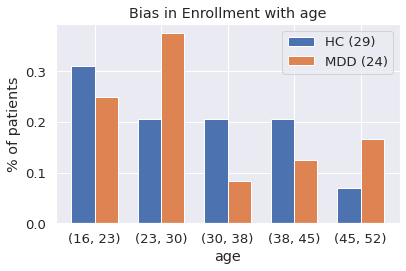

Glyph 65288 missing from current font.
Glyph 65289 missing from current font.
Glyph 65288 missing from current font.
Glyph 65289 missing from current font.


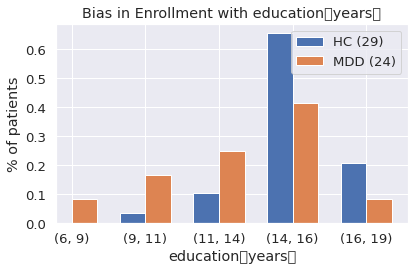

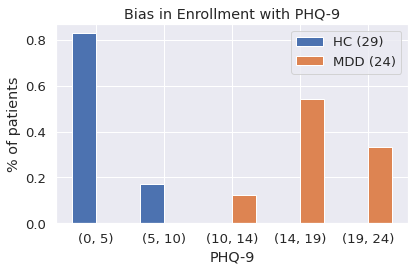

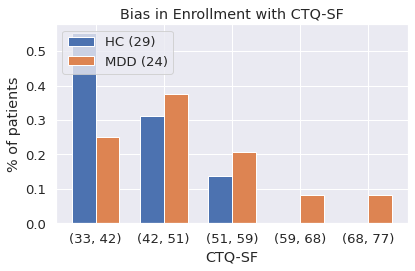

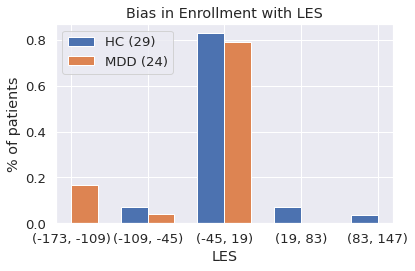

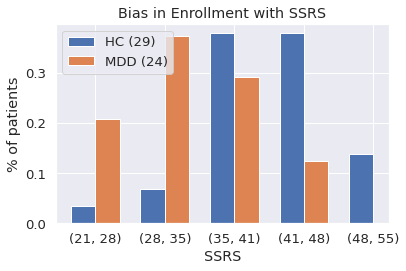

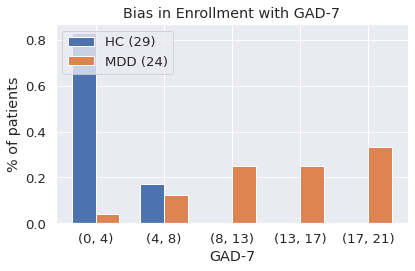

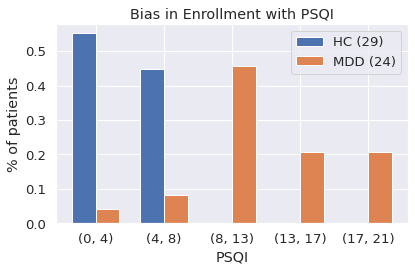

In [ ]:
#Looping through various demographics columns
for cols in ['age','education（years）', 'PHQ-9','CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']:
  box_plot_builder(df,key=cols,title_vals = 'Bias in Enrollment with '+cols)

<b>Interpretations</b>

Through the charts, we see that almost all the questionaire response will be able to distinguish Depression patients from normal patients. Hence, providing these test results will further increase our chances to improve accuracy. However, as the aim of our project is to use EEG core datasets, we will refrain from using this for initial iterations. For now, we will drop all these variables.

<b>One key thing to note</b>: ~60% of the depression patients that the team enrolled are younger with age <30 years. We will have to account for this while we make generalized claims about the detection of EEG

In [ ]:
columns_to_drop = ['age','education（years）', 'PHQ-9','CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']


## Understanding correlation amongst the different electrodes





We wanted to understand if there is any pattern seen in the electodes correlation in healthy patients and patients with MDD.

## Understanding the Linear Features

There are a total of 8 features that we selected for 16 electrode positions. However, there are three image sequences (fear-neutral, sad-neutral, resting-neutral) that were shown the participants. Along with that, a resting sequence is also present. This increased our feature space from 8 features to 8\*16\*4 features. The main 8 features are - 

1. Mean amplitude (peak to peak) of the power signal
2. Median amplitude (peak to peak) of the power signal
3. Maximum amplitude (peak to peak) of the power signal
4. Minimum amplitude (peak to peak) of the power signal
5. Power at alpha
6. Power at beta
7. Power at delta
8. Power at theta

We are going to follow this approach here:

1. First filter the dataframe for the given feature space. If it is Mean and the emotion is happy, we are going to select all the columns that satisfies the condition. It is implemented in <b>columns_extractor</b> function
2. Once we have the subset of data frame, we plot the correlation cross tab. Here we plot three variants: All the patients, Depression patients and Normal patients. The idea here is if there are any patterns/strong correlation between two different electrodes, we want to visually represent it. This is represented in <b>correlation_builder</b> function
3. Last and the most important, we will use the correlation cross tab that we built in the earlier step and try to select only one column if any set of two columns have more than correlation value set through the threshold. This is implemented in the third utility function - <b>column_eliminator</b>

After this block, we should essentially be eliminating certain features that are not essential for our process

In [ ]:
df.columns

Index(['lf_alpha_fear_E36', 'lf_beta_fear_E36', 'lf_delta_fear_E36',
       'lf_theta_fear_E36', 'lf_mean_fear_E36', 'lf_max_fear_E36',
       'lf_min_fear_E36', 'lf_median_fear_E36', 'lf_alpha_happy_E36',
       'lf_beta_happy_E36',
       ...
       'lf_beta_resting_E96', 'lf_delta_resting_E96', 'lf_theta_resting_E96',
       'lf_mean_resting_E96', 'lf_max_resting_E96', 'lf_min_resting_E96',
       'lf_median_resting_E96', 'nl_svden_resting_E96',
       'nl_spec_enresting_E96', 'nl_permenresting_E96'],
      dtype='object', length=714)

In [ ]:
#Helper function - Purpose is to extract necessary column from the dataframe as per set initialized and plot correlation map of 16 electodes
#Also provide a view on how they differ between Depression and Normal patient

def columns_extractor(df,emotion,feature_type,name):
  """
  Inputs:
  df - Dataframe that we are using
  emotion - There are four emotions namely : Happy, Fear, Sad and Resting
  Feature - Either Linear feature (lf) or Non-linear features (nl)
  Outputs:
  resultant data frame
  """
  if feature_type =='lf':
    columns_to_extract = [i for i in df.columns if feature_type in i and emotion in i and name in i]
    final_cols = {i:i.replace(feature_type+'_'+name+'_'+emotion+'_', '') for i in columns_to_extract}
  else:
    columns_to_extract = [i for i in df.columns if feature_type in i and name in i and emotion in i]
    final_cols = {i:i.replace(feature_type+'_'+name+emotion+'_', '') for i in columns_to_extract}
  columns_to_extract.extend(['type'])
  #print(columns_to_extract)
  df_result = df[columns_to_extract]
  return df_result.rename(columns = final_cols)

def correlation_builder(df,prefix):
  """
  Inputs:
  df - Dataframe to be used
  Outputs:
  chart object - This will be saved for future reference
  """
  #Correlation cross tab
  corr_all = df[[i for i in df.columns if 'type' not in i]].corr()
  corr_md = df[df['type']=='MDD'][[i for i in df.columns if 'type' not in i]].corr()
  corr_hc = df[df['type']=='HC'][[i for i in df.columns if 'type' not in i]].corr()
  list_corr = [corr_all,corr_md,corr_hc]
  titles = ['All Participants','MDD','HC']
  #Mask for the upper triangle of correlation to be masked
  mask = np.zeros_like(corr_all)
  mask[np.triu_indices_from(mask)] = True
  min = -1
  max = 1
  a = dict()
  fig =  plt.figure(figsize=(30,12))
  for val in range(3):    
    with sns.axes_style("white"):
      a[val] = fig.add_subplot(1,3,val+1)
      a[val] = sns.heatmap(list_corr[val], mask=mask, square=True,vmin=min,vmax=max,cmap = sns.cm.rocket_r,
                           cbar_kws = dict(use_gridspec=False,location="bottom"))
      a[val].set_title(titles[val],fontdict={'fontsize': '20', 'fontweight' : '5'})
  
  #sns.heatmap(arr, ax=ax, cbar_ax = cbar_ax, cbar=True)
  fig.suptitle('Heat Map for '+prefix, fontsize=30)
  path_to_save = '/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/EA_'+prefix+'.png'
  fig.savefig(path_to_save,dpi = 100)
  return corr_all,fig

def column_eliminator(df,thr=0.9):
  columns = np.full((df.shape[0],), True, dtype=bool)
  for i in range(df.shape[0]):
      for j in range(i+1, df.shape[0]):
          if df.iloc[i,j] >= thr:
              if columns[j]:
                  columns[j] = False
  return columns

Let's for instance take an example of 'fear' based linear features. We will now plot the correlation cross tab between the features

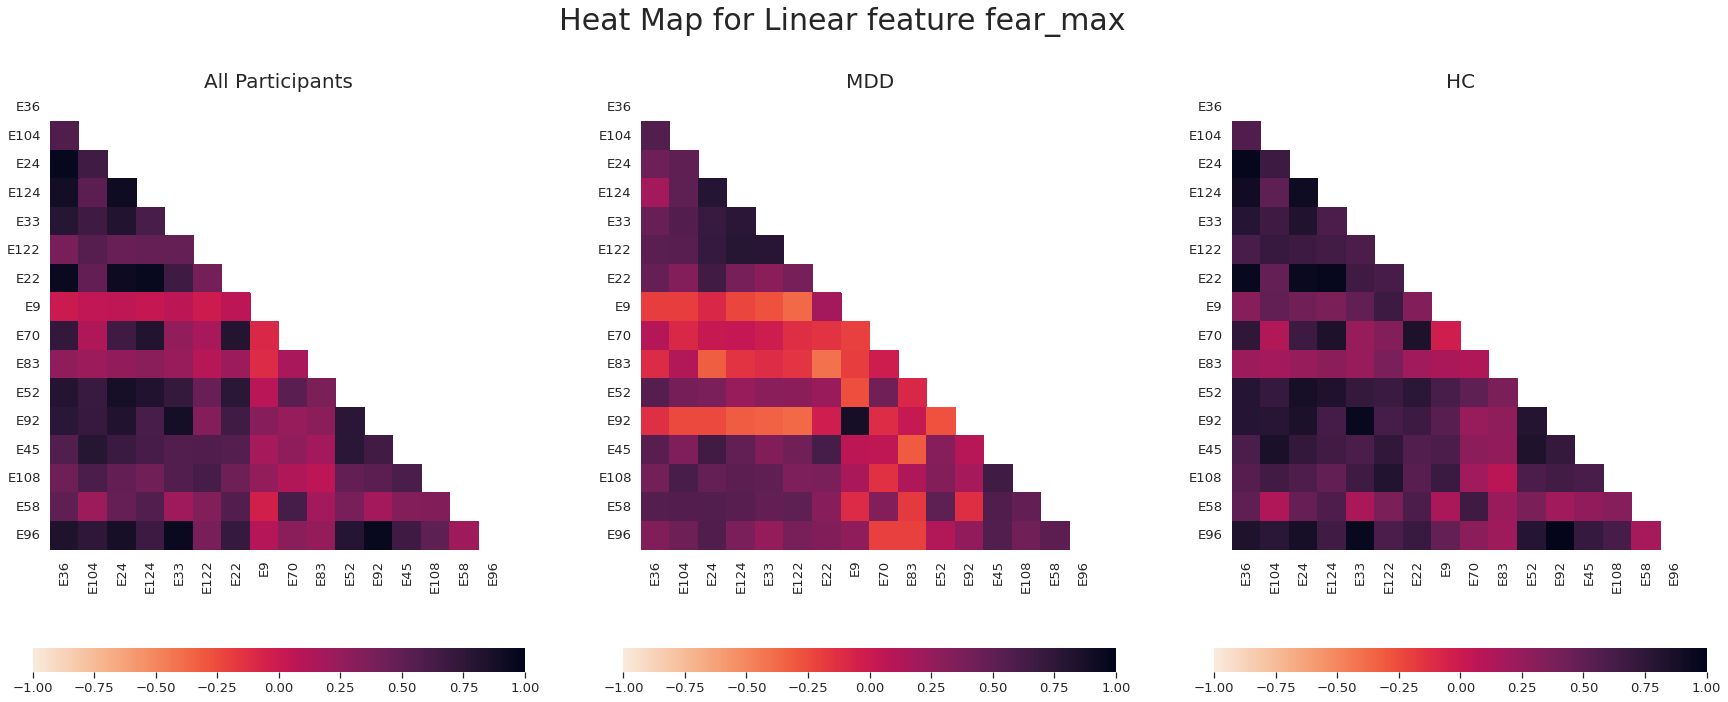

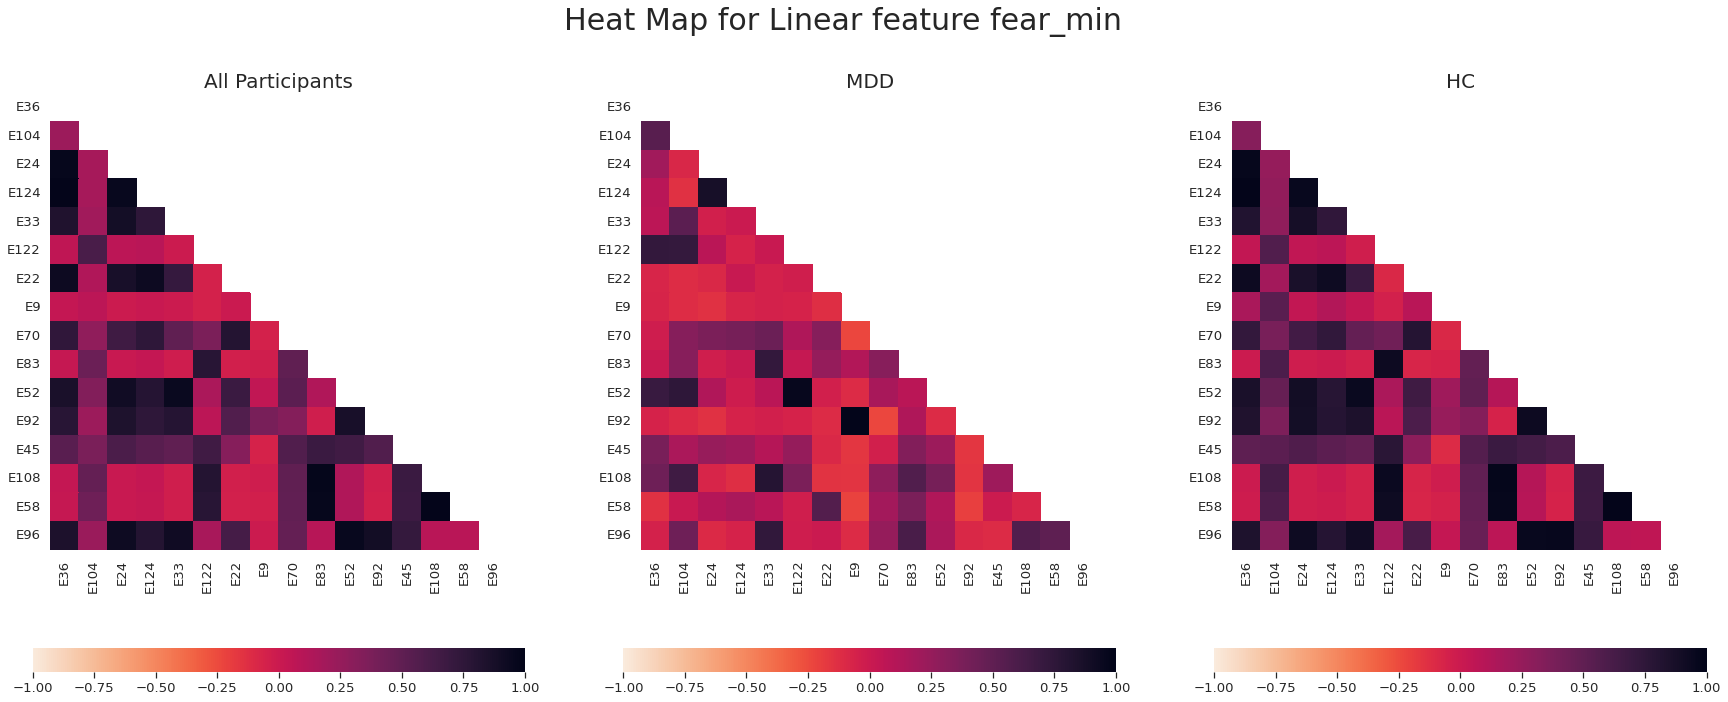

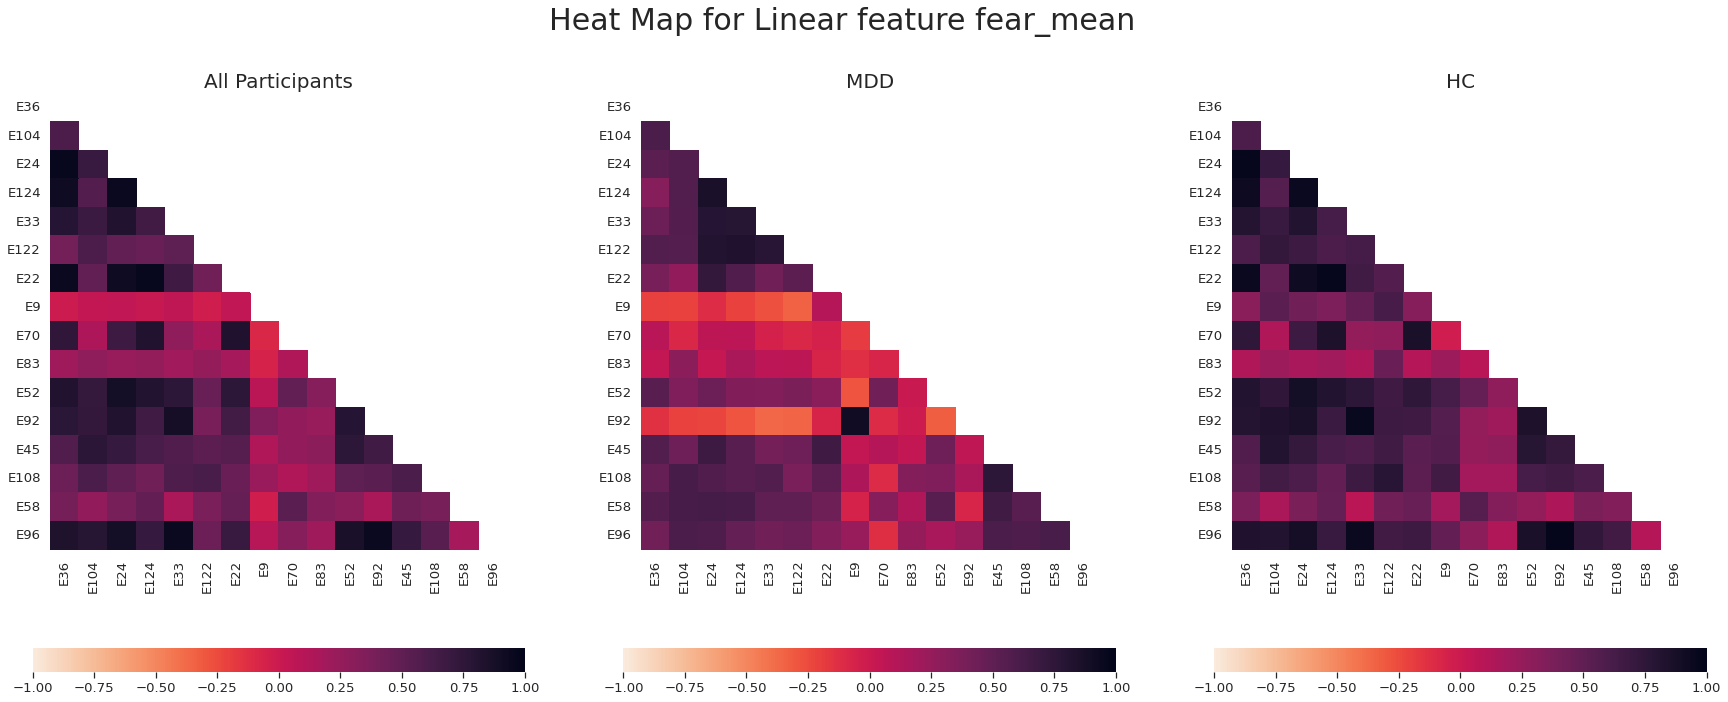

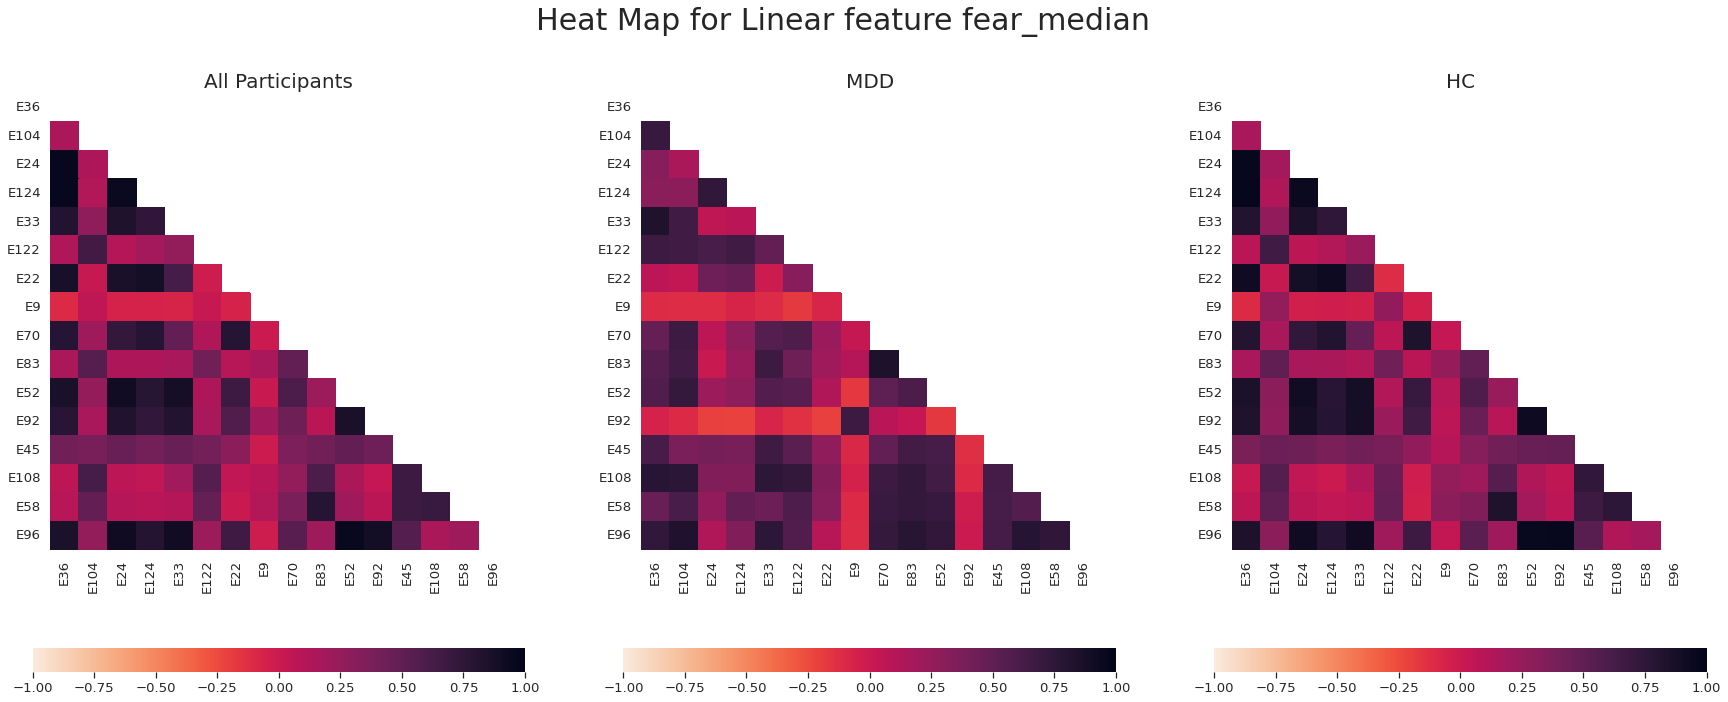

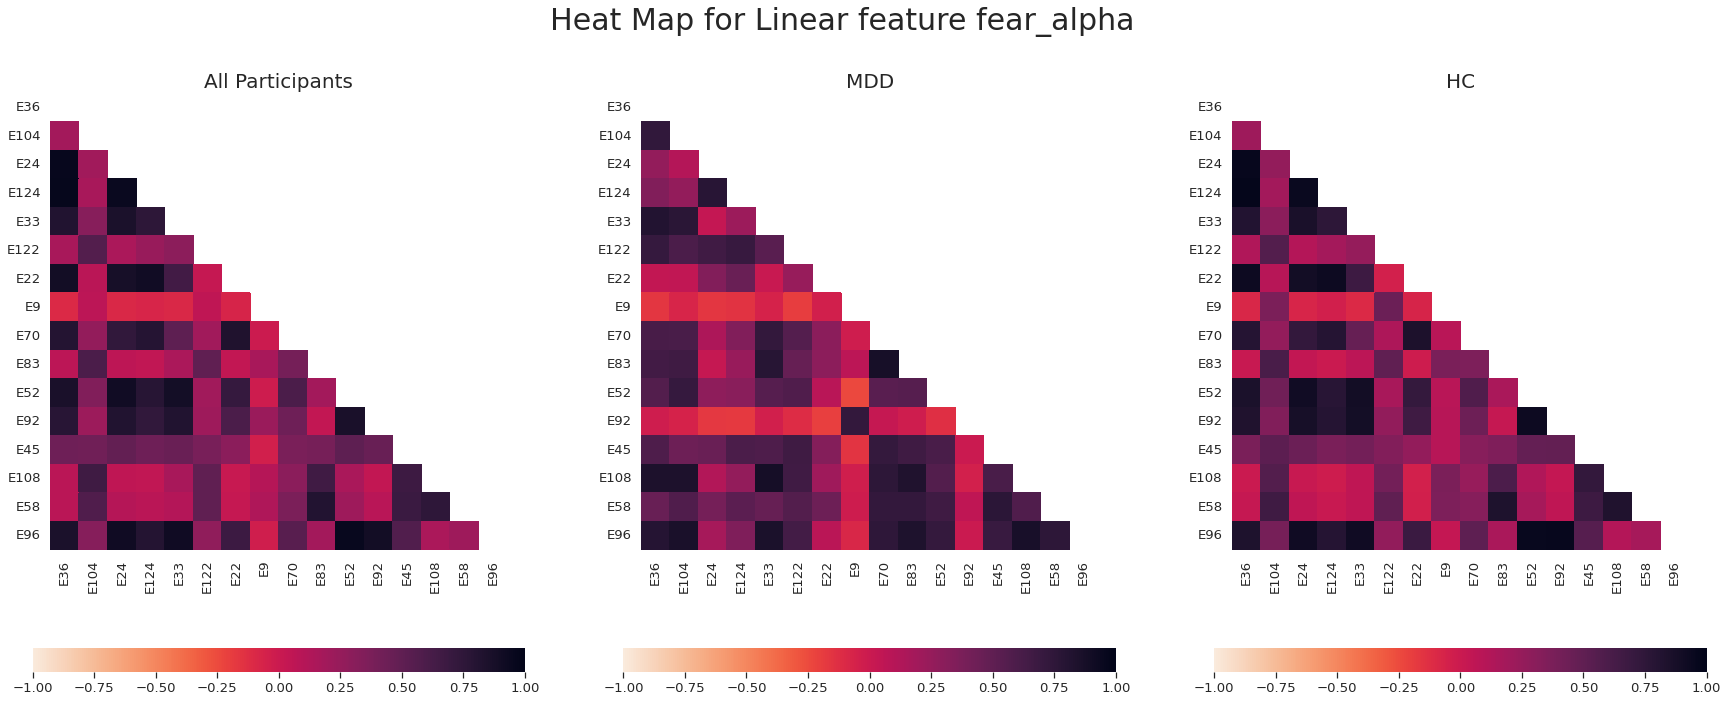

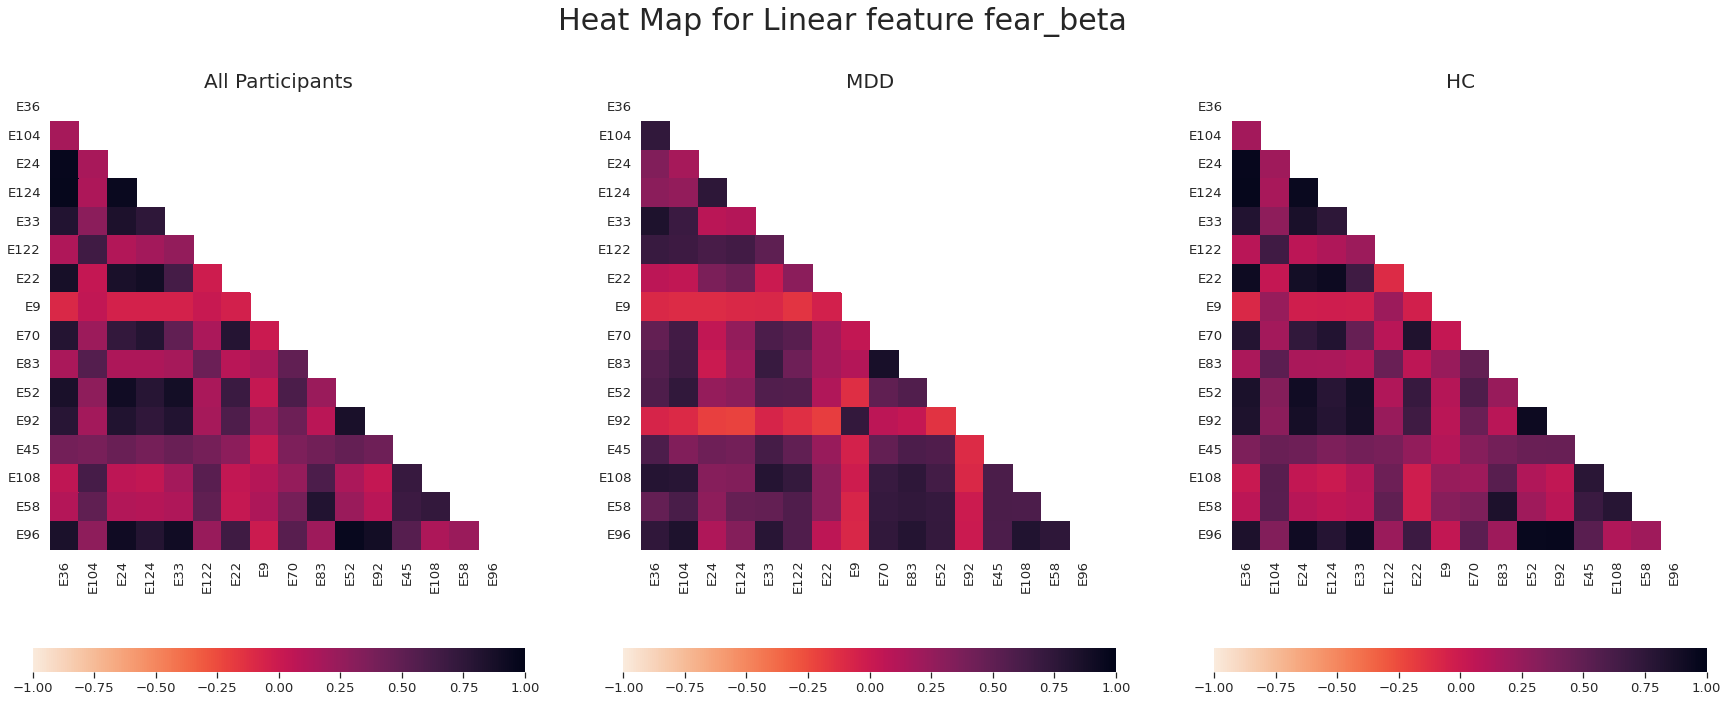

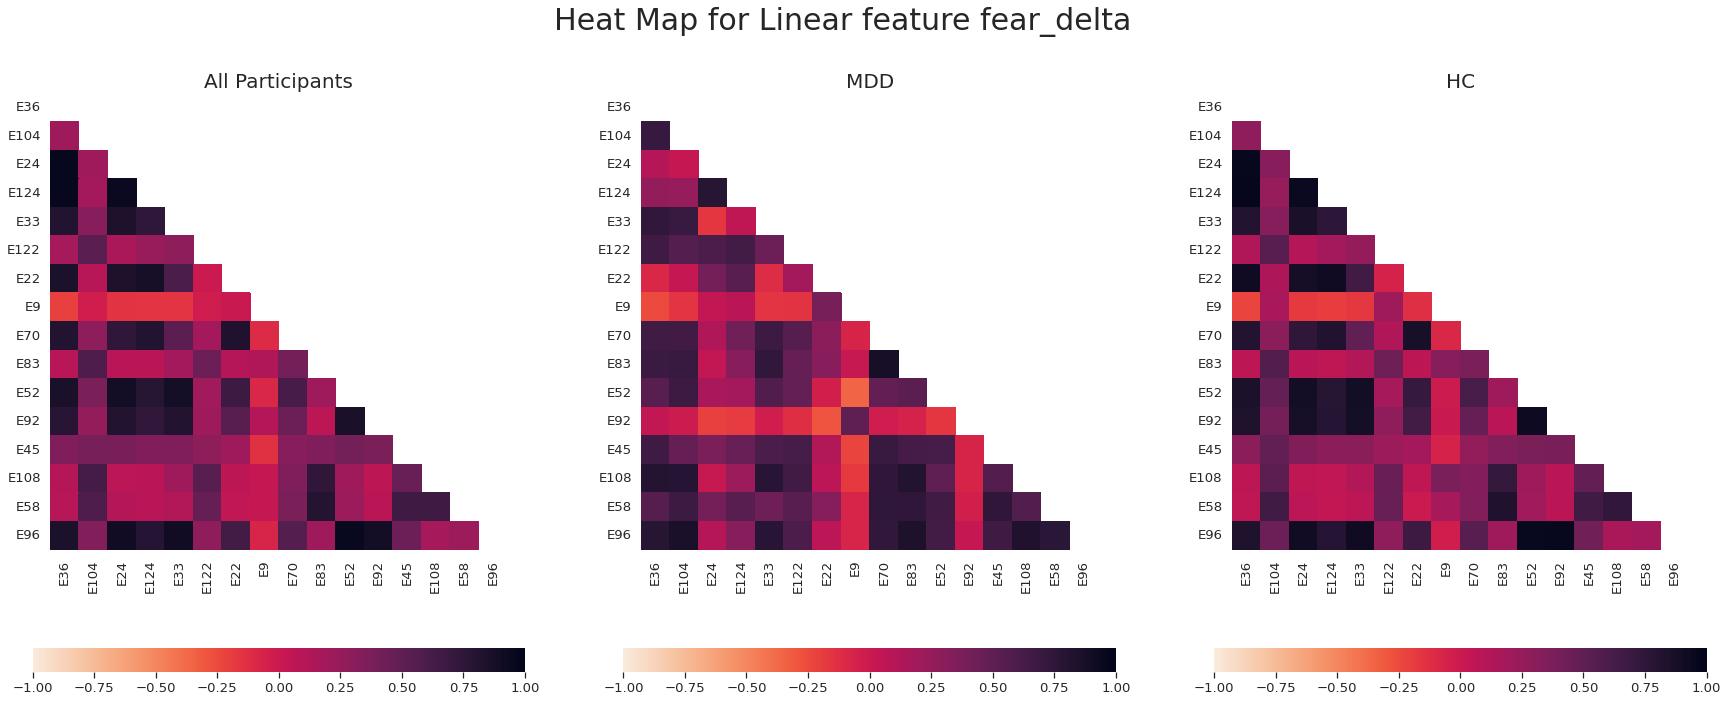

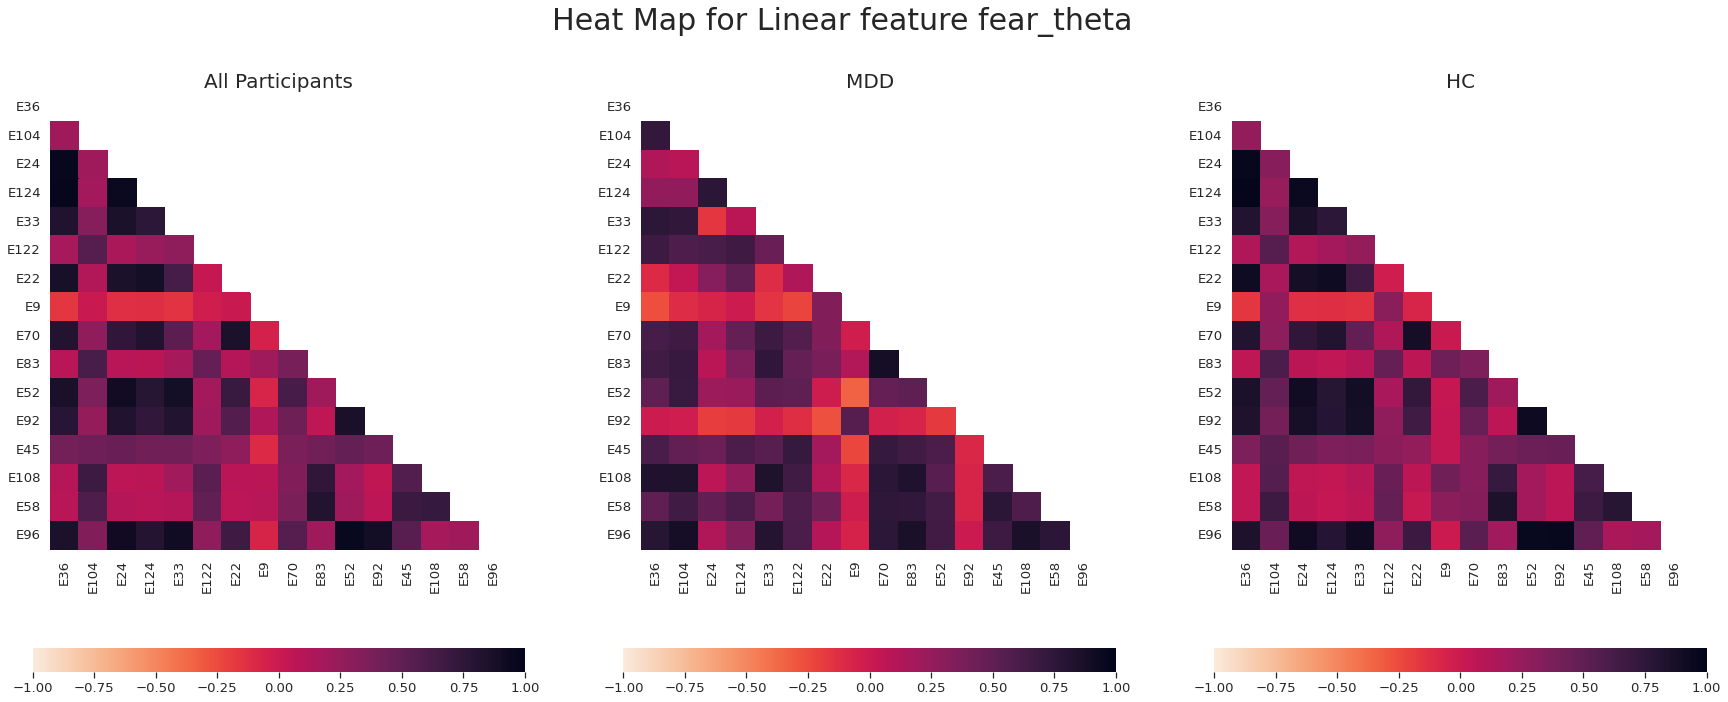

In [ ]:
emotion = 'fear'
for name in ['max','min','mean','median','alpha','beta','delta','theta']:
  temp = columns_extractor(df,emotion,'lf',name)
  a,b = correlation_builder(temp,prefix = 'Linear feature '+emotion+'_'+name)

<b>Interpretation</b>

Across all the features and electrodes, the pattern between Normal patients is largely inline with the population. However, the Depression patients have some interesting patterns in 
'E9','E70','E83','E52','E92' electrodes for max, min, median and mean values. To some extent, this pattern is also present in the alpha and beta signals

While it is difficult to carry this exercise to all the variations, our feature eliminator function will ensure that we are picking the interesting columns

Follow up: Looks like there are some differences in the way the extreme front (E9 represent front lobe of the scalp) and extreme back (E70, E83 represents the extreme back side of the scalp, E52, E92 represents signals from back of the scalp) processes the images and resting activity compared to other electrode positions


<b>Scaling it up</b>

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


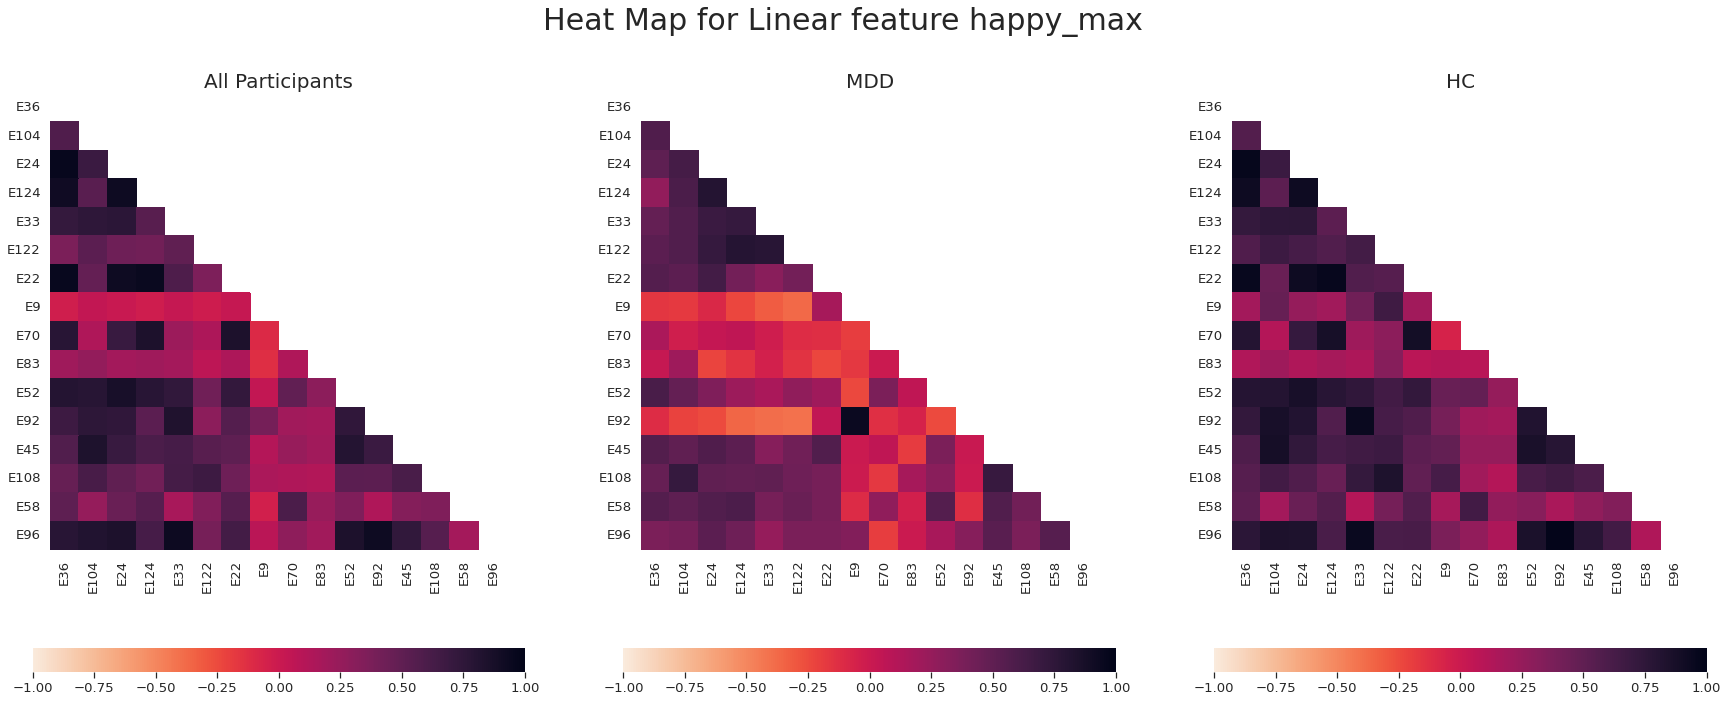

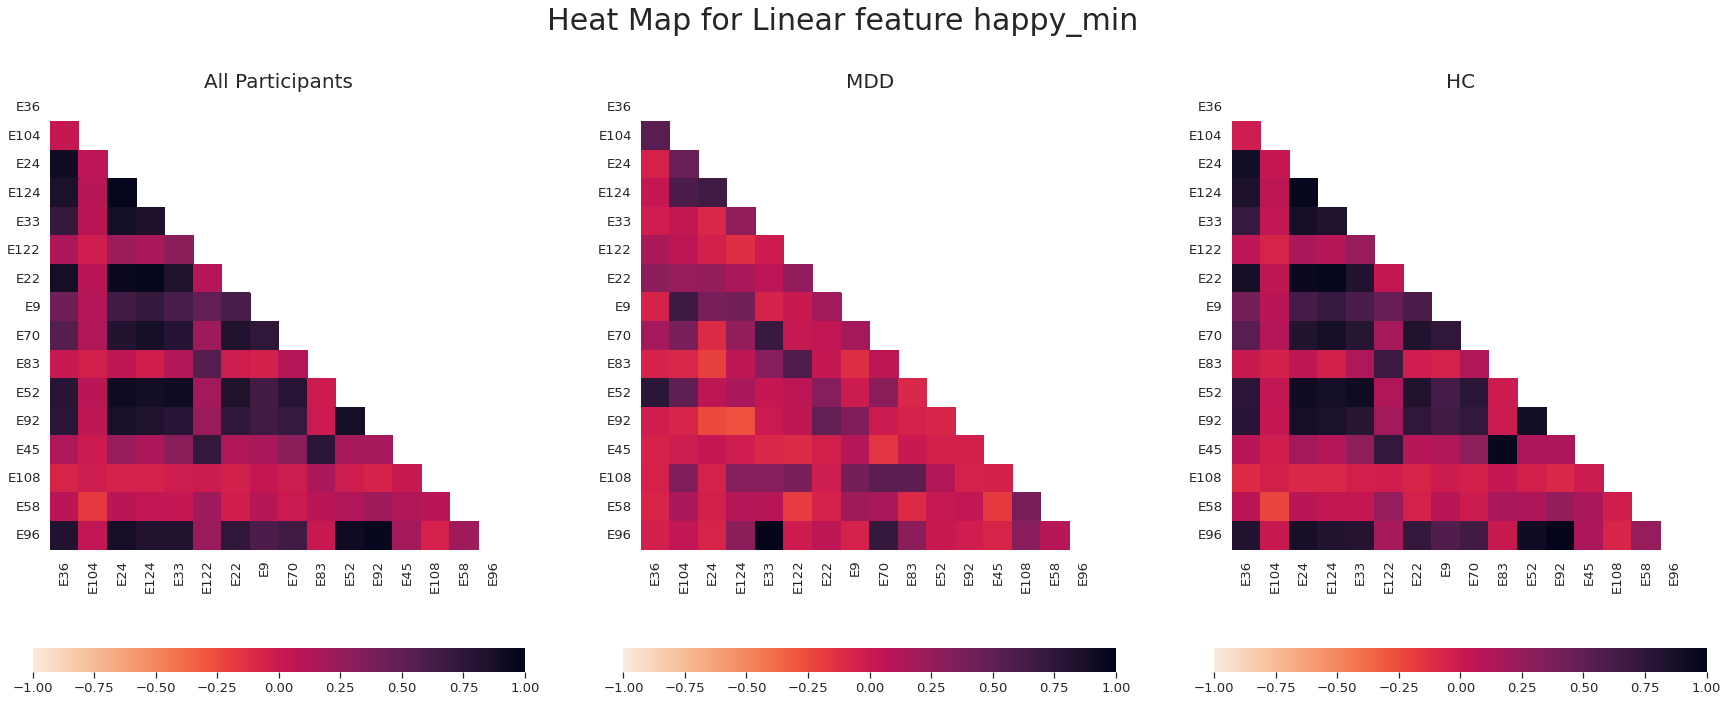

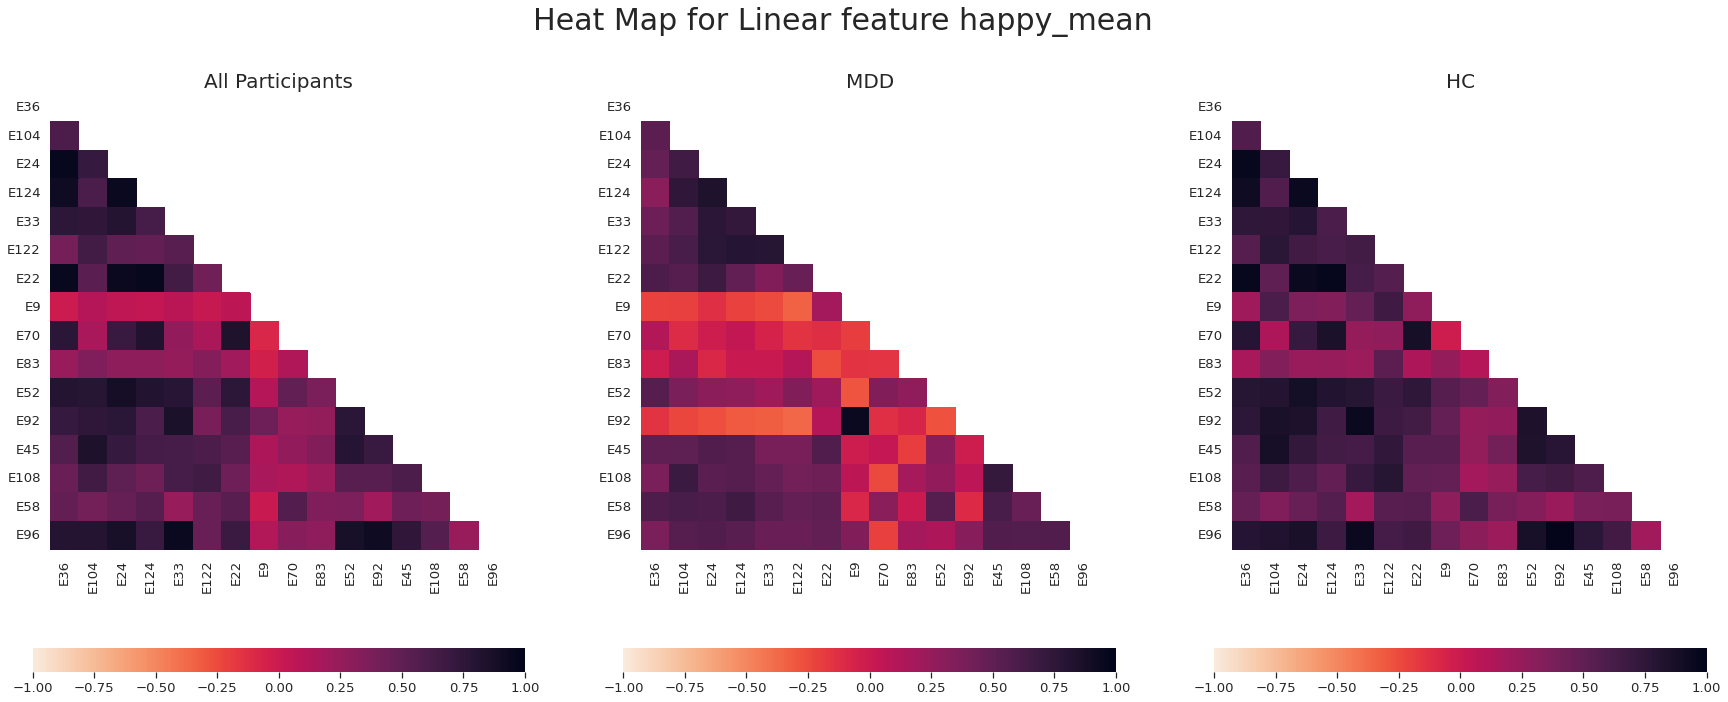

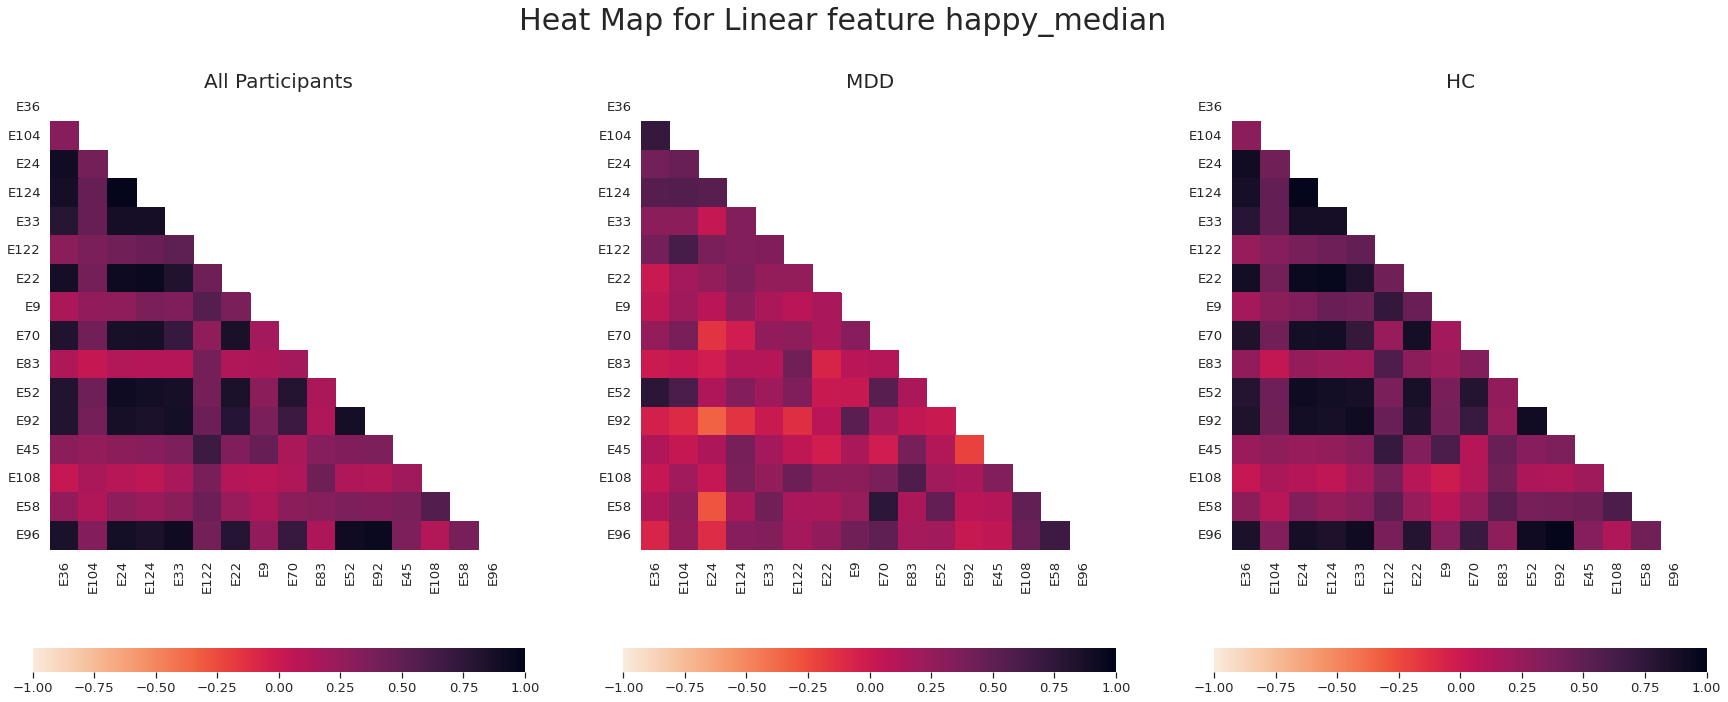

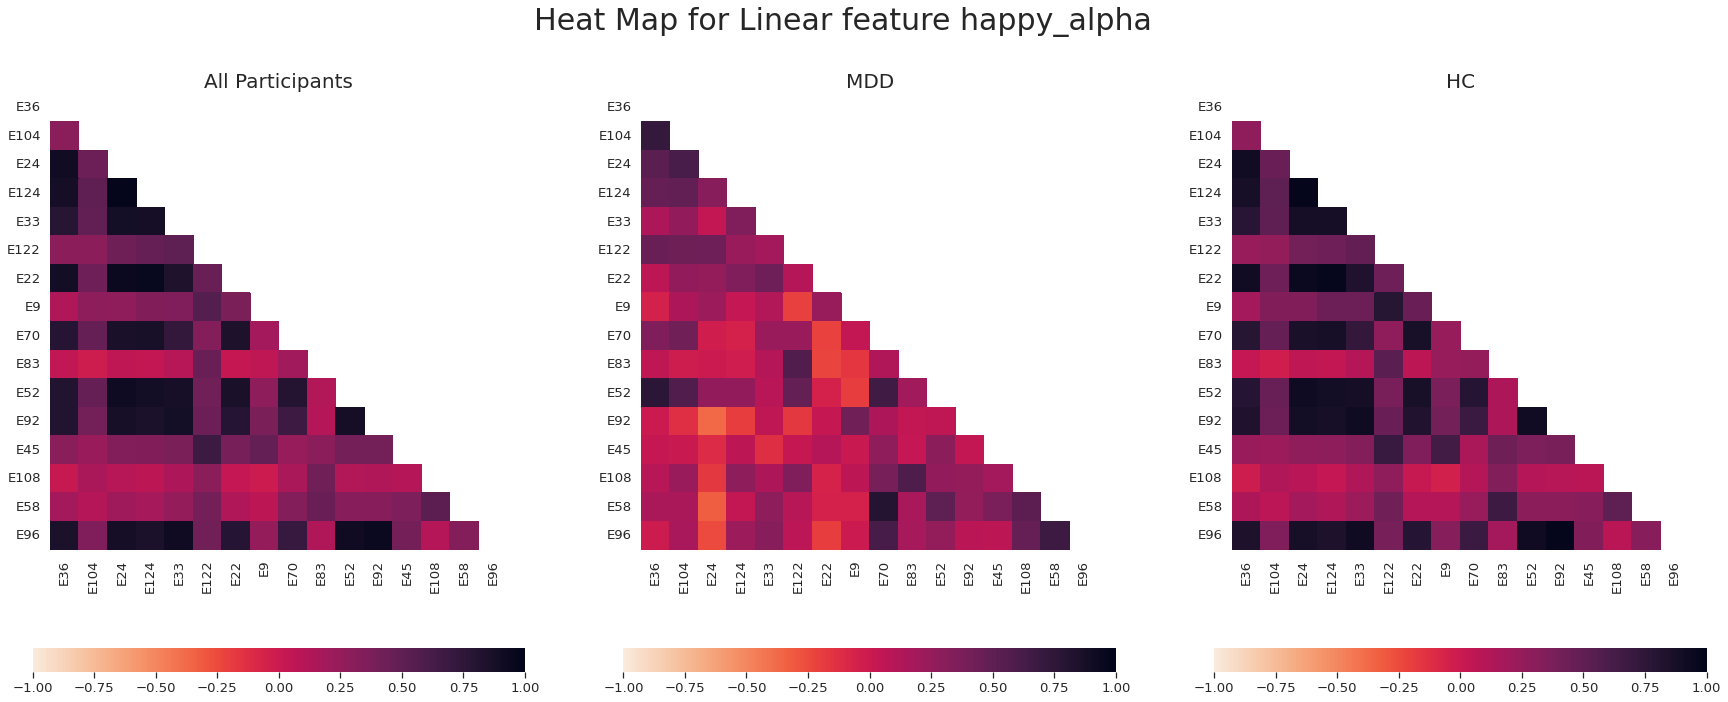

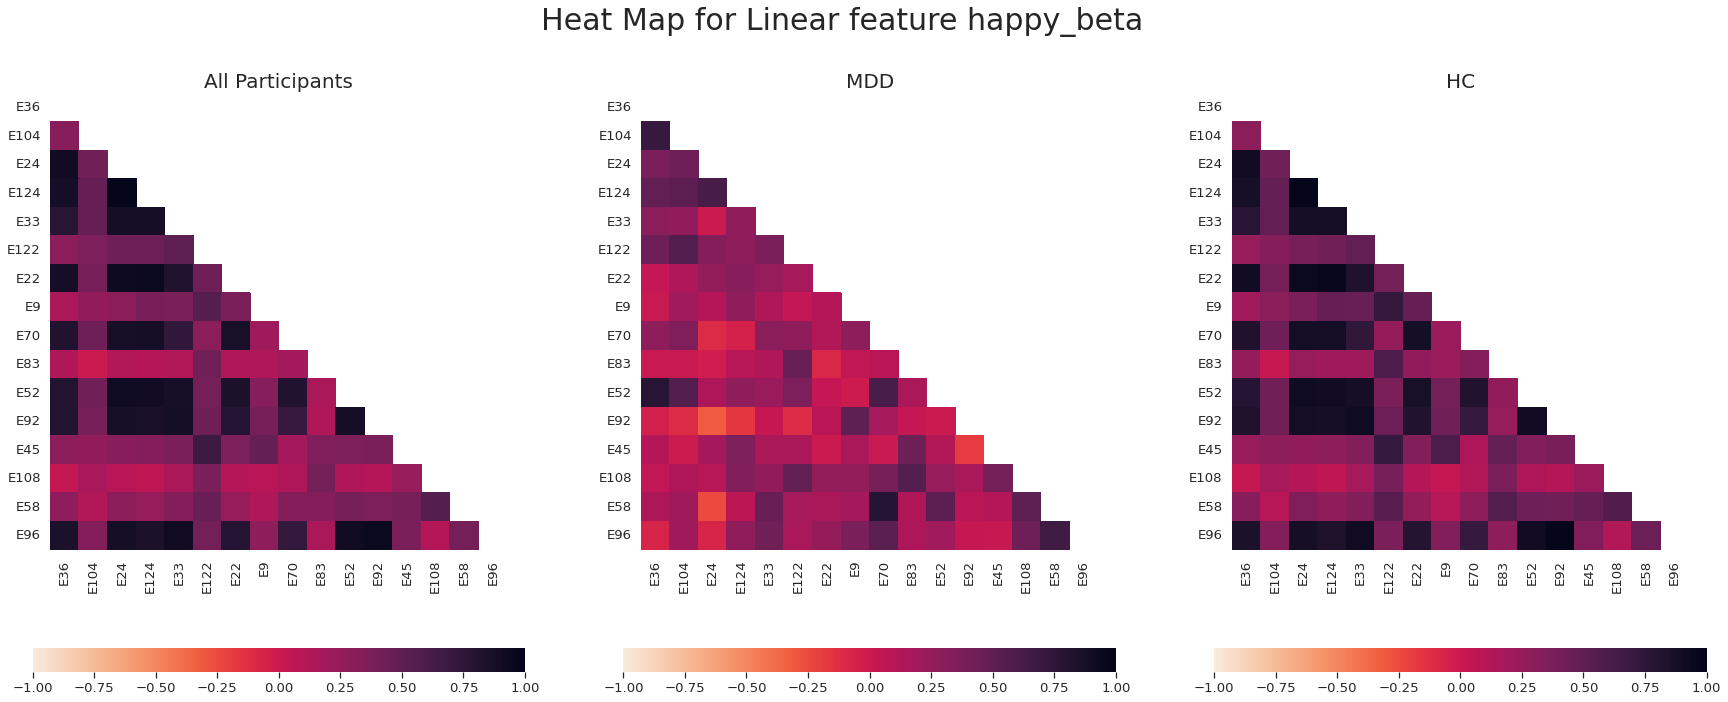

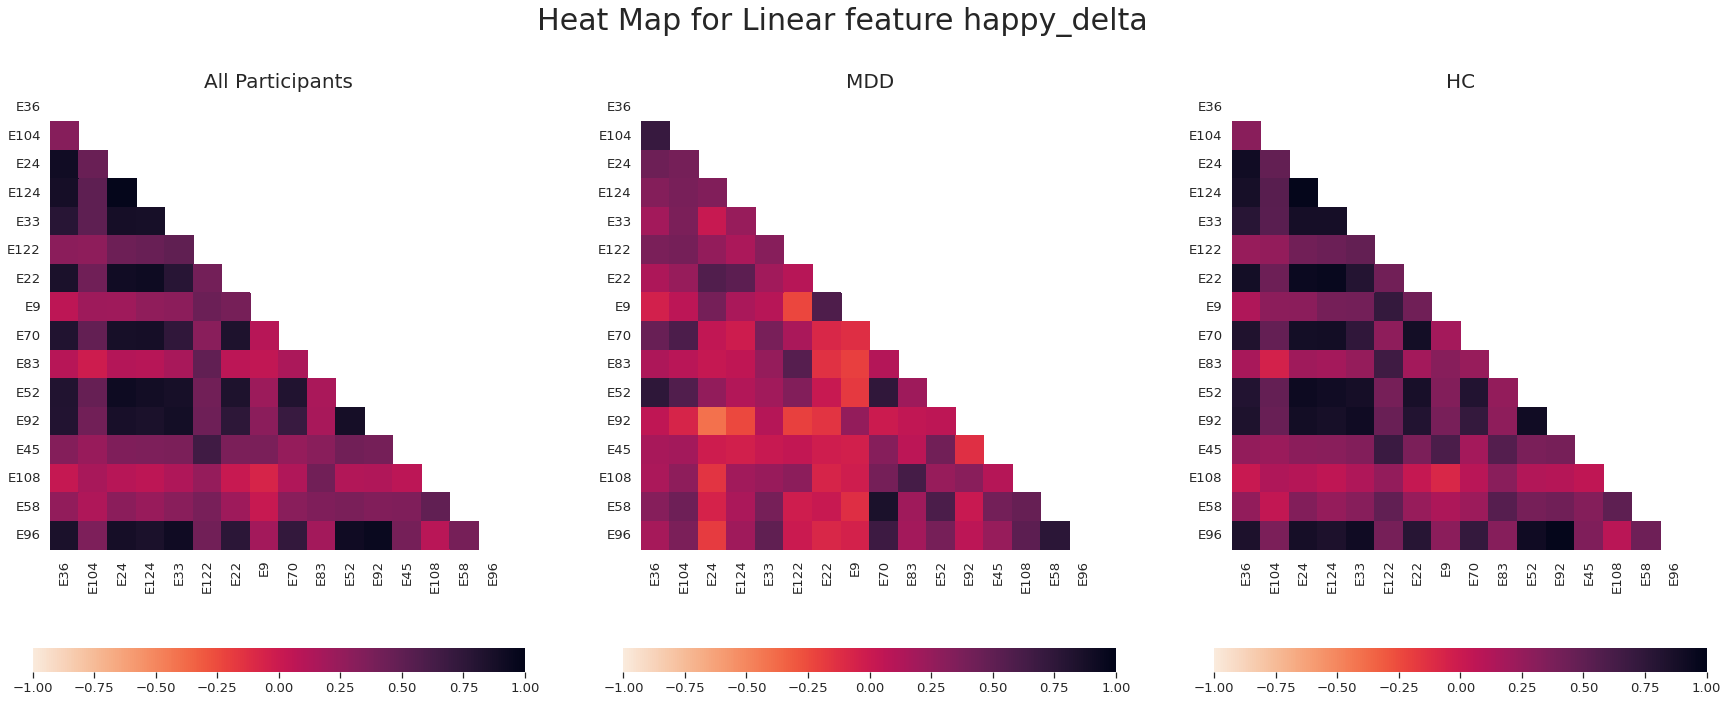

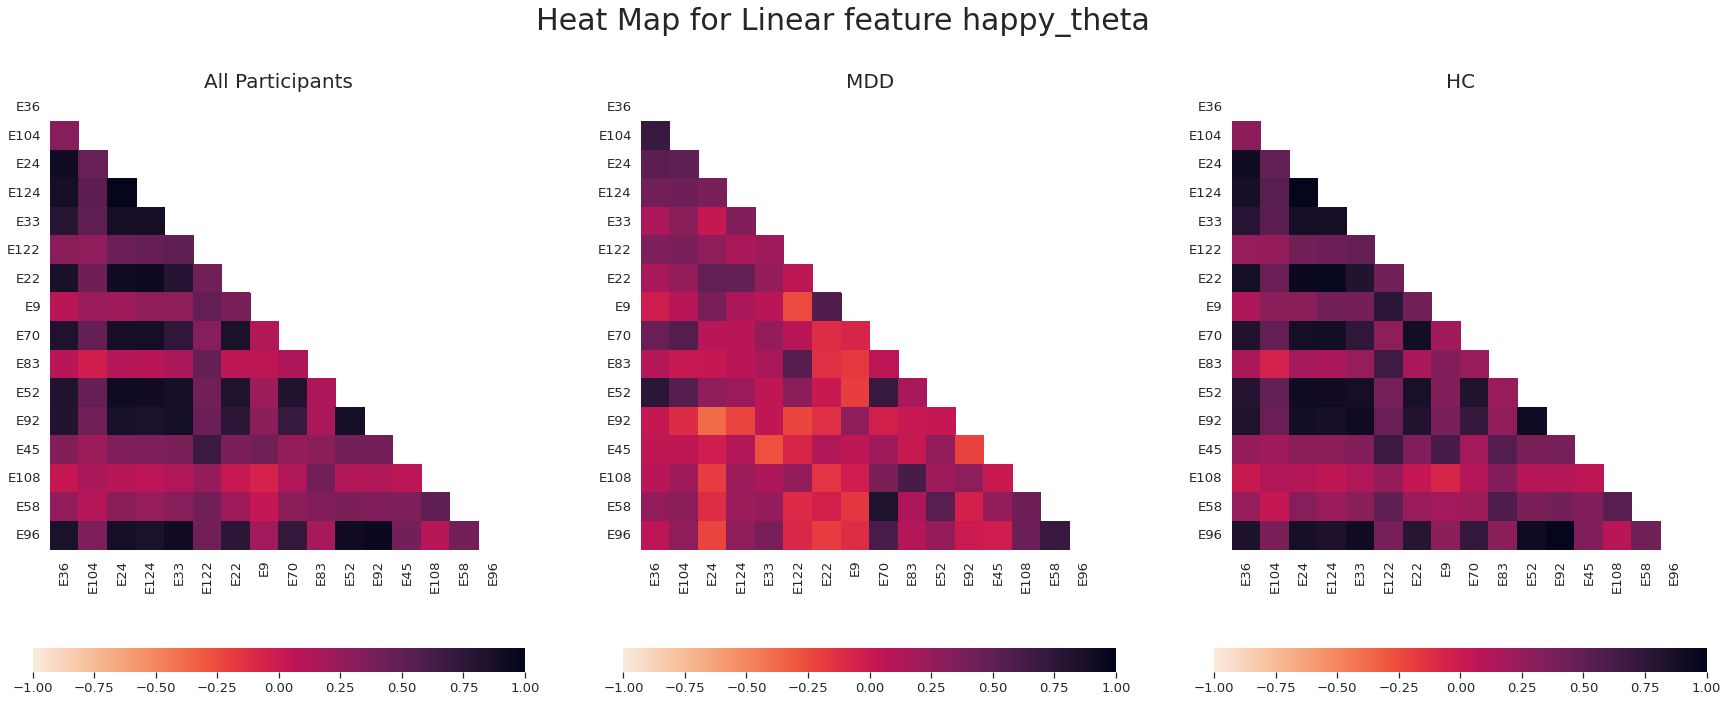

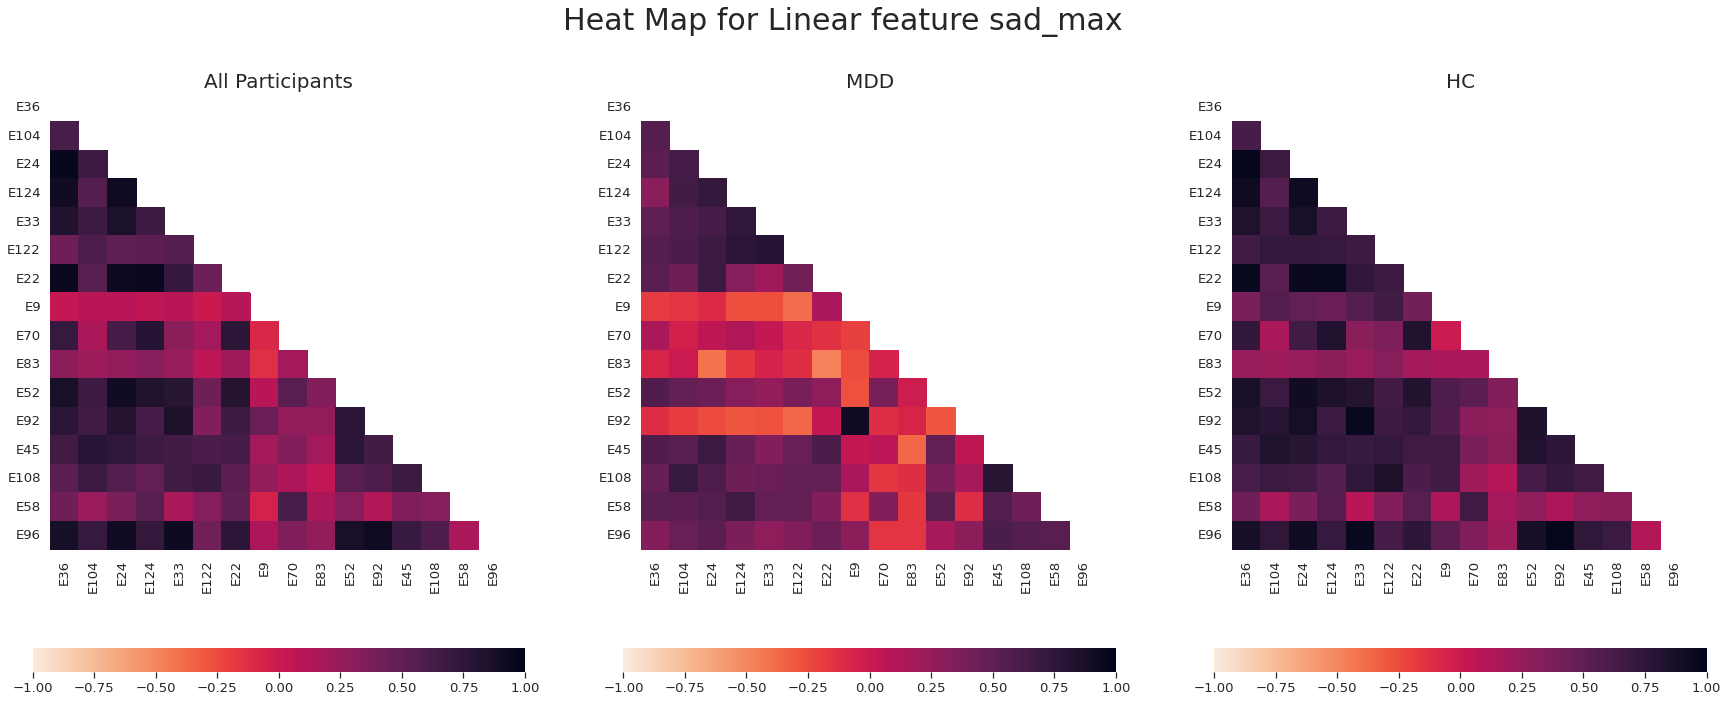

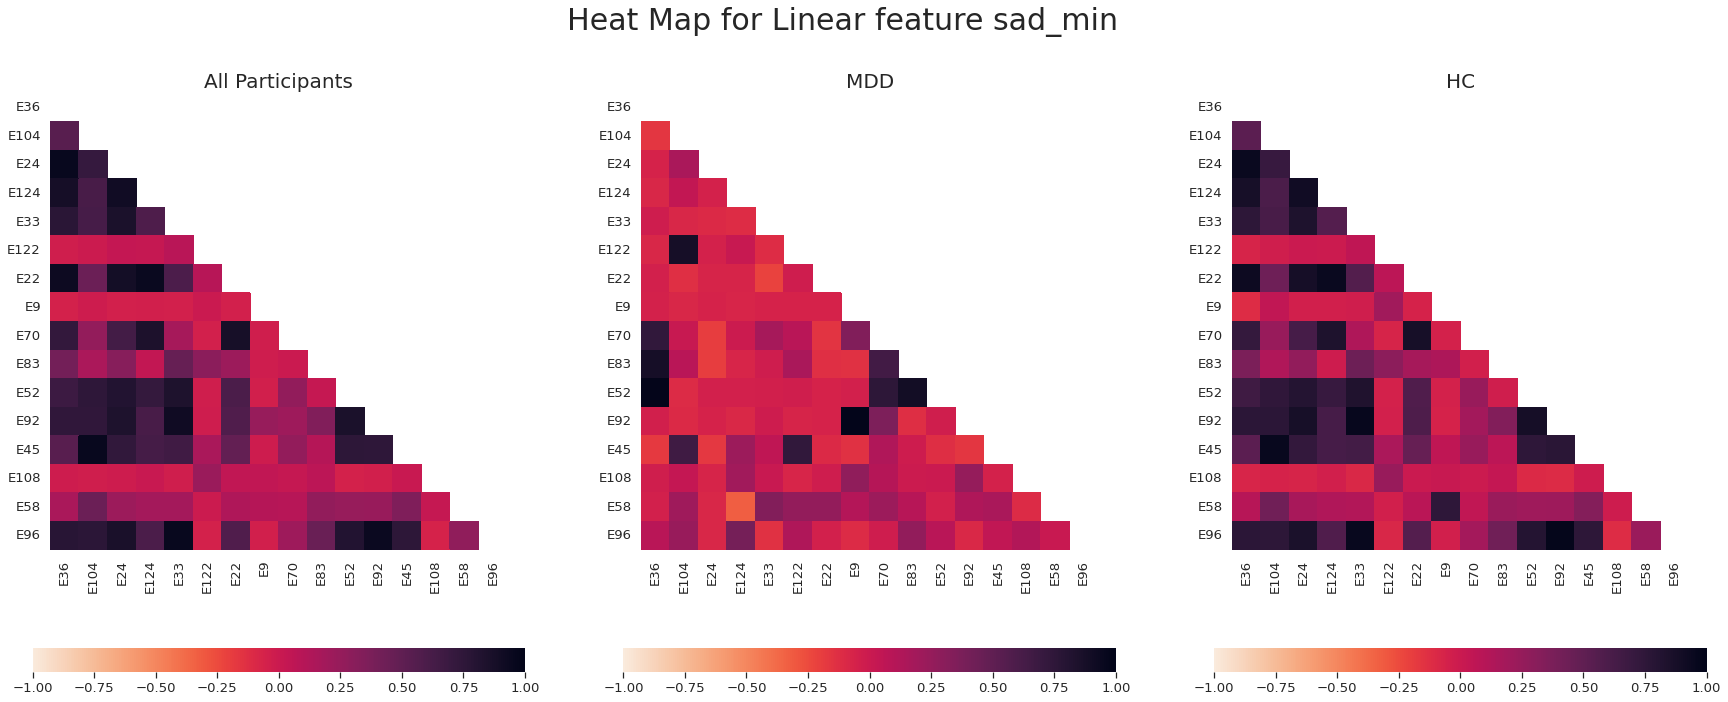

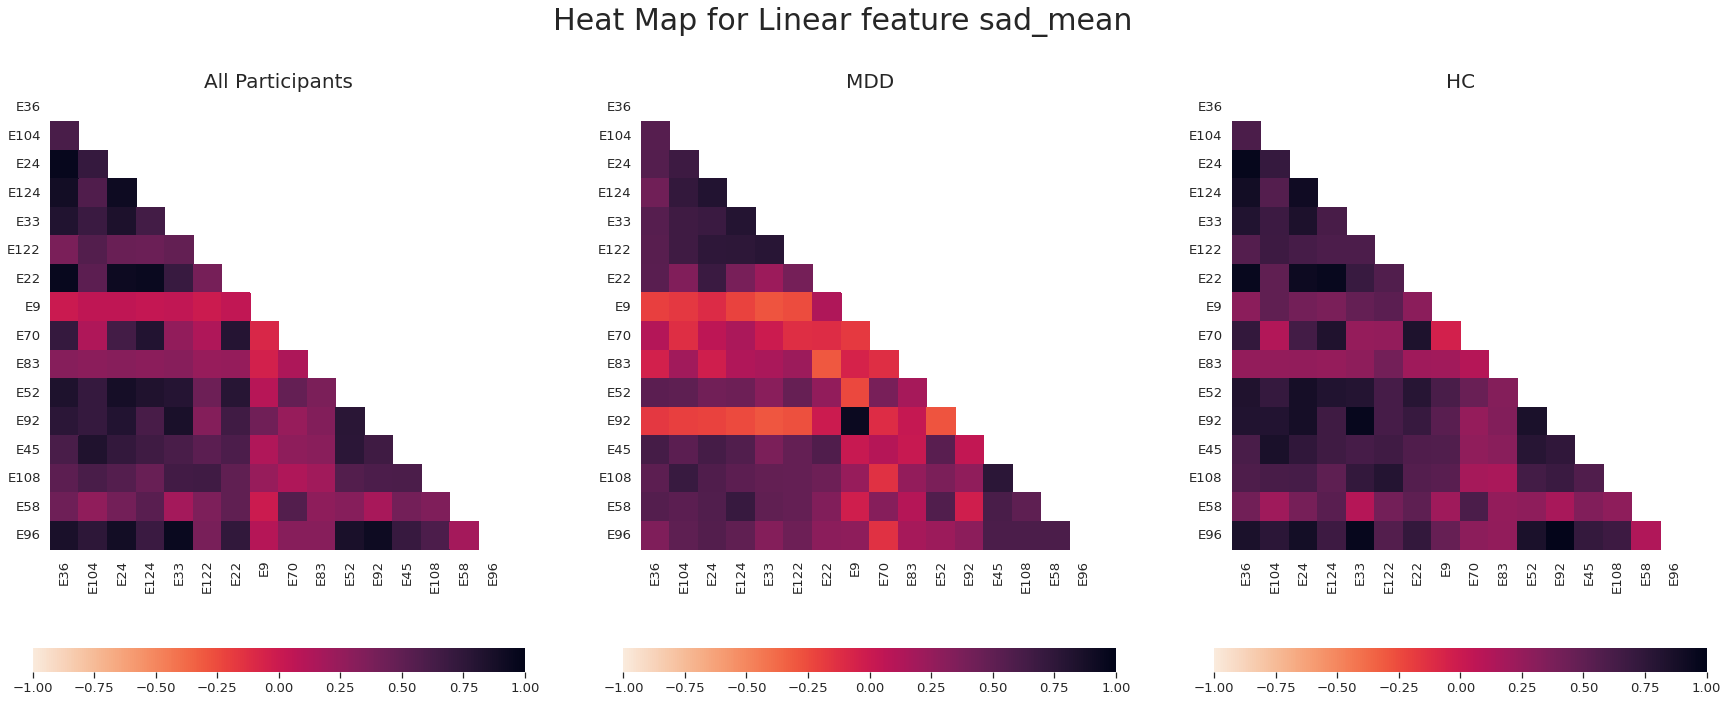

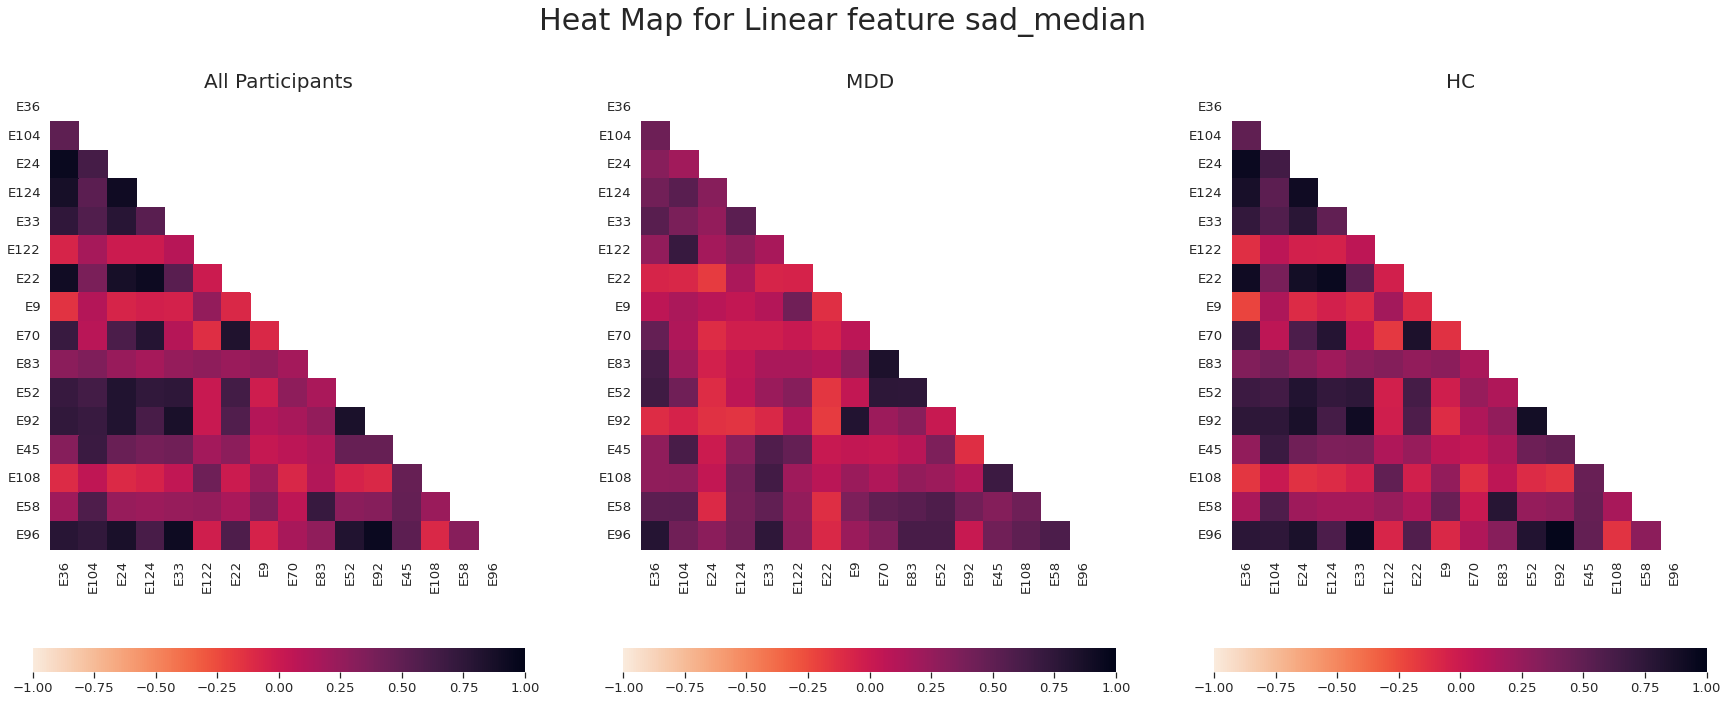

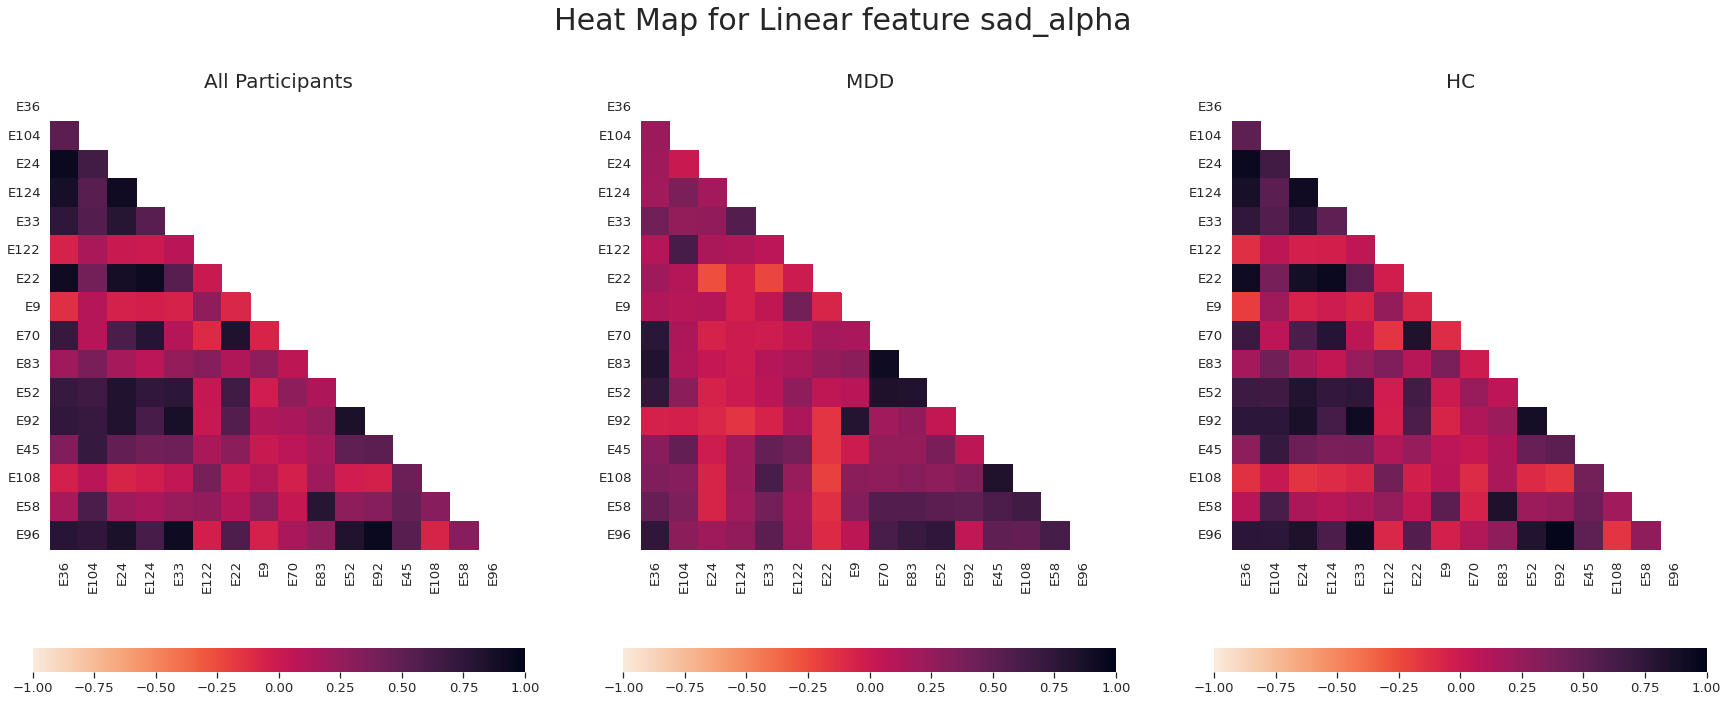

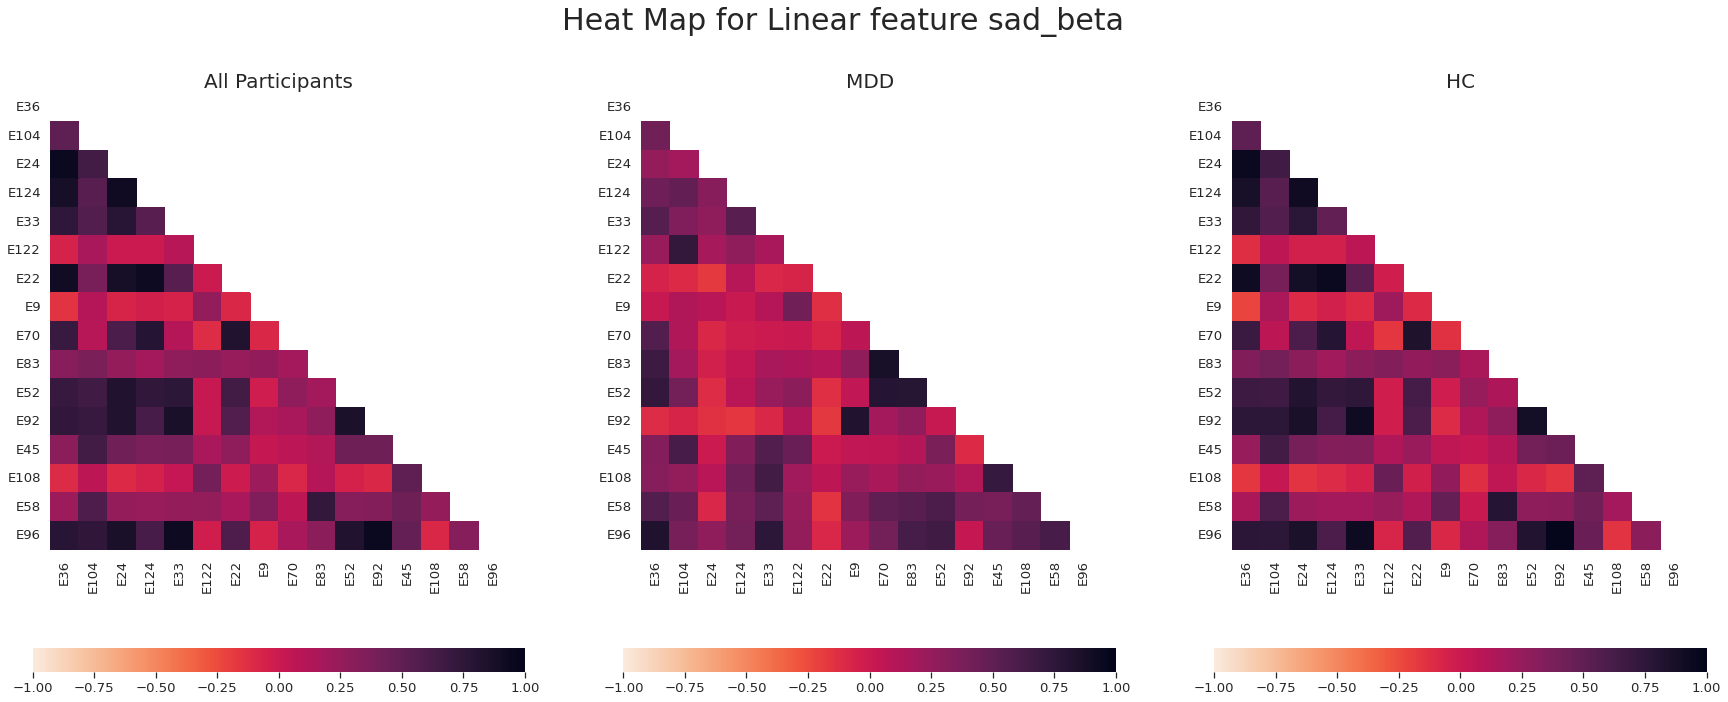

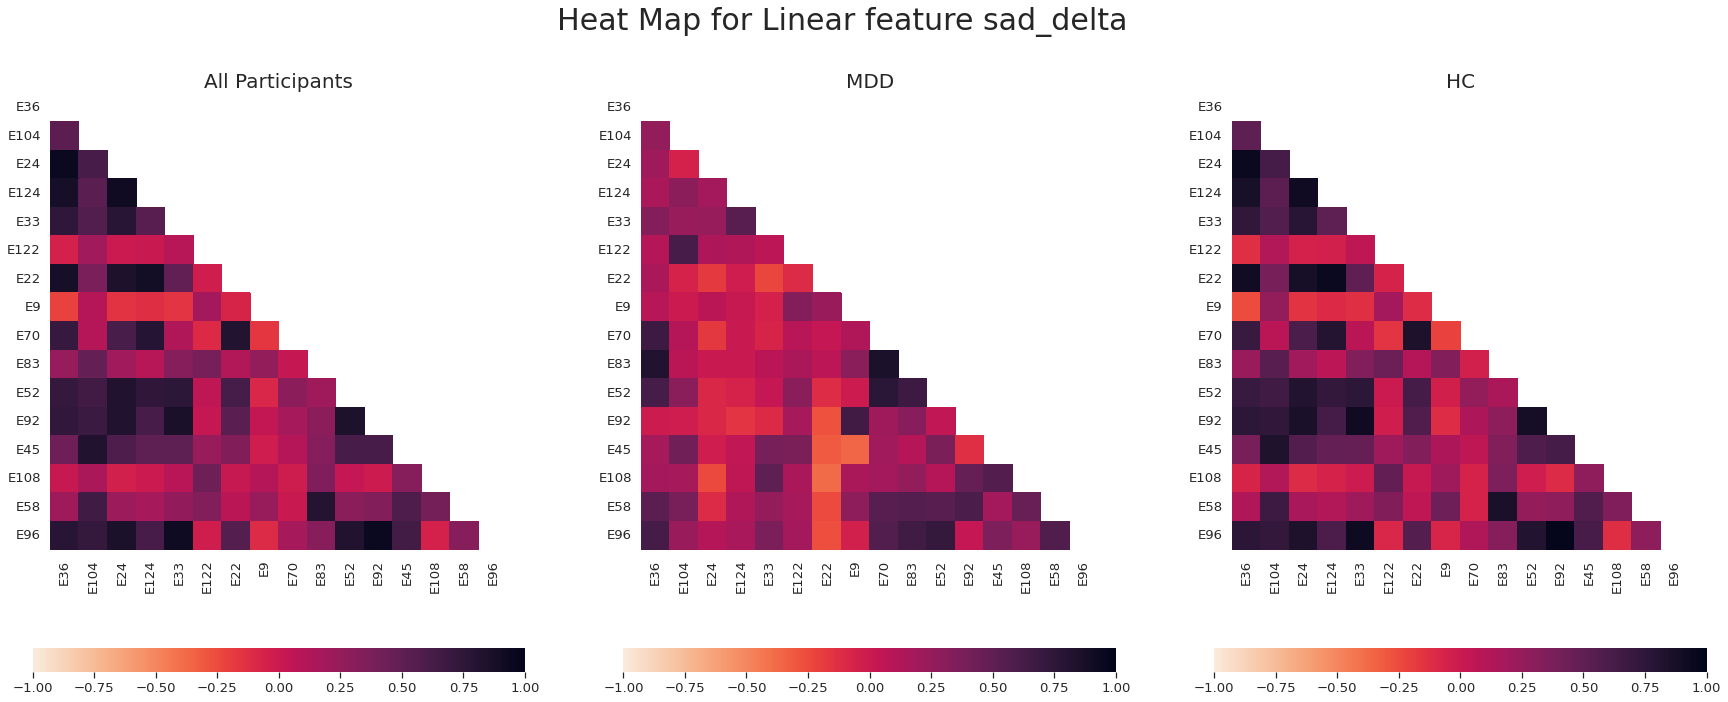

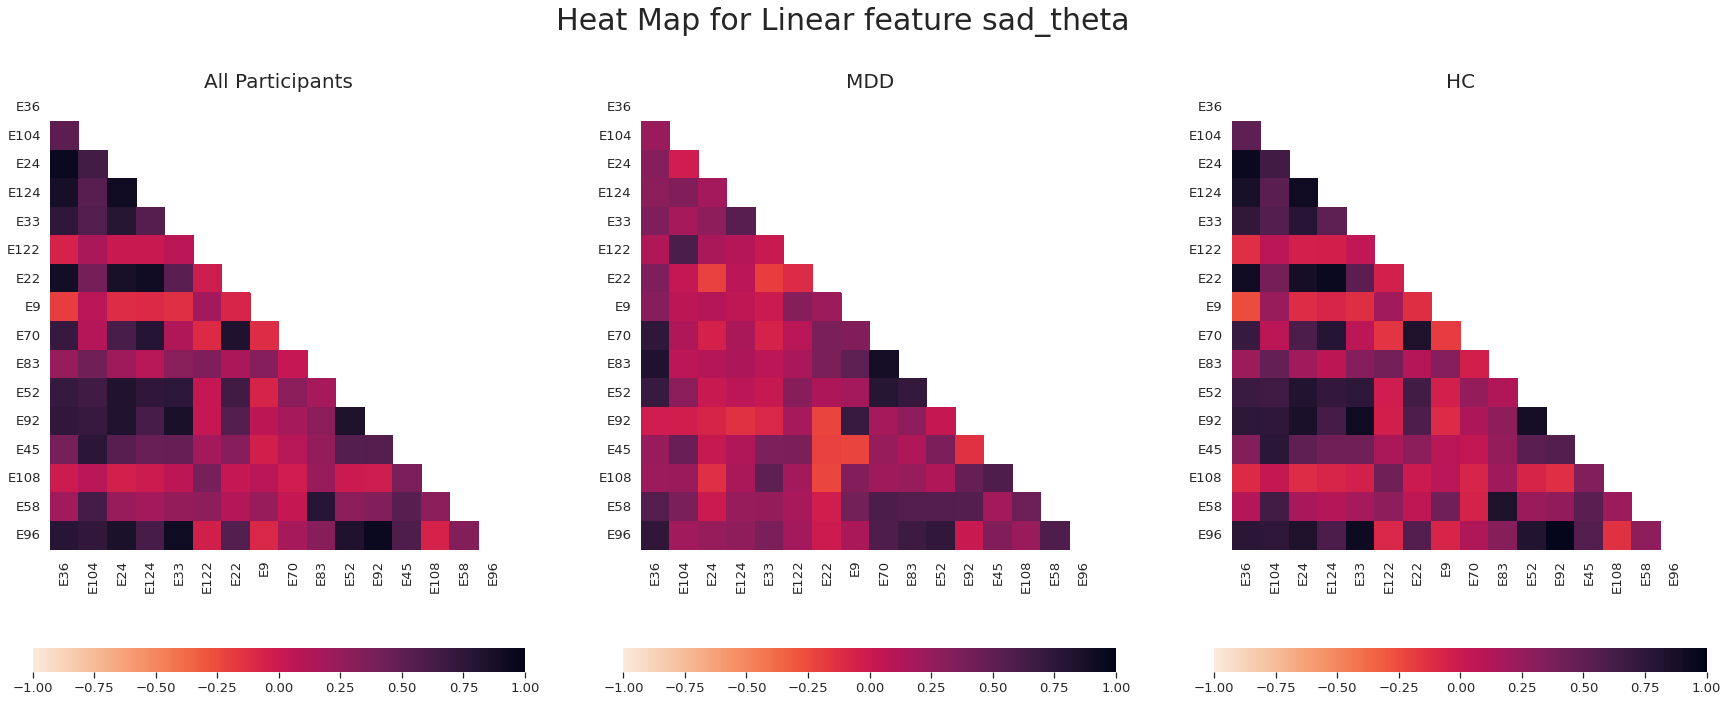

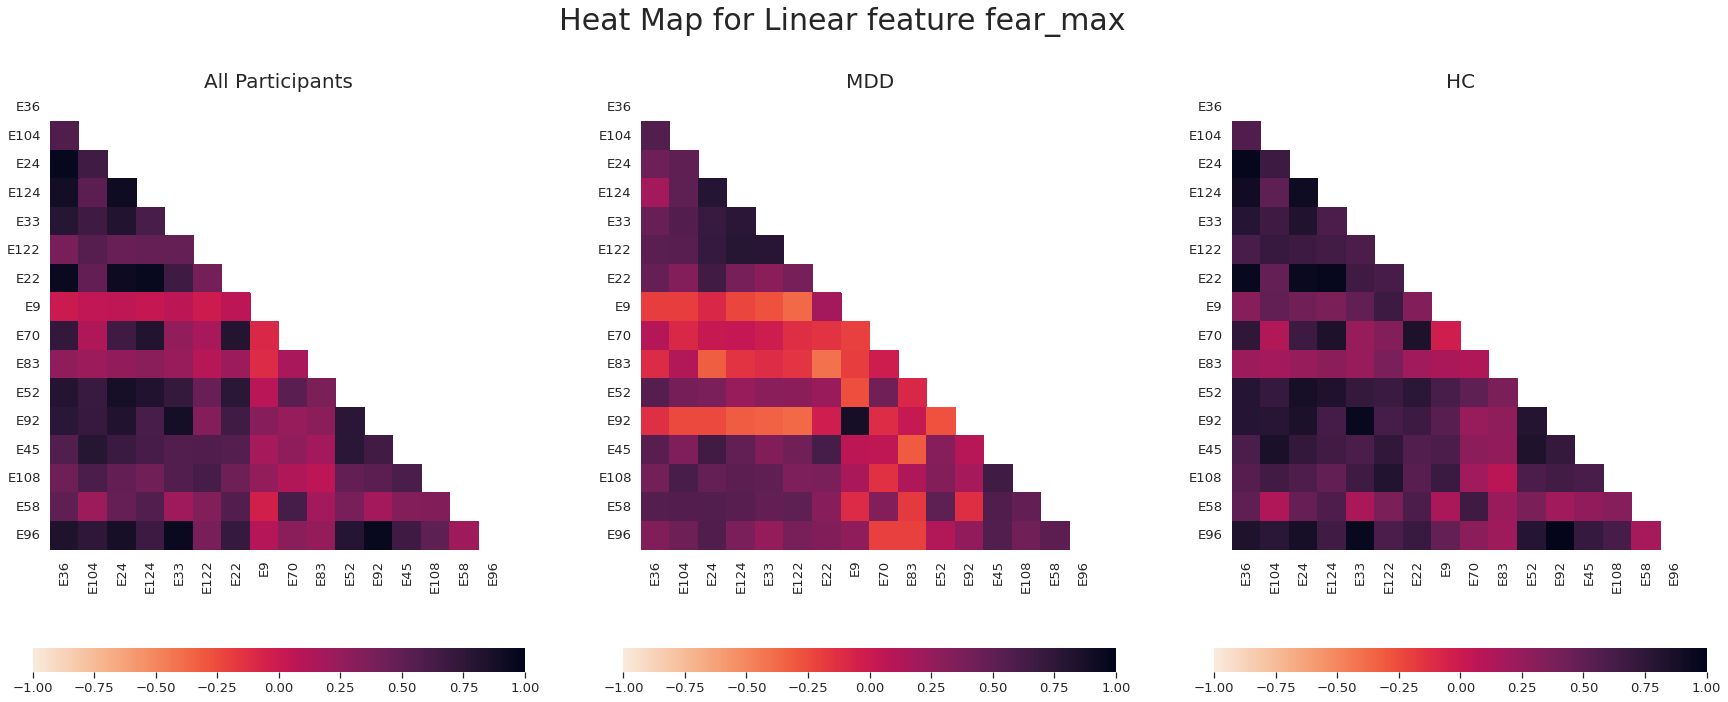

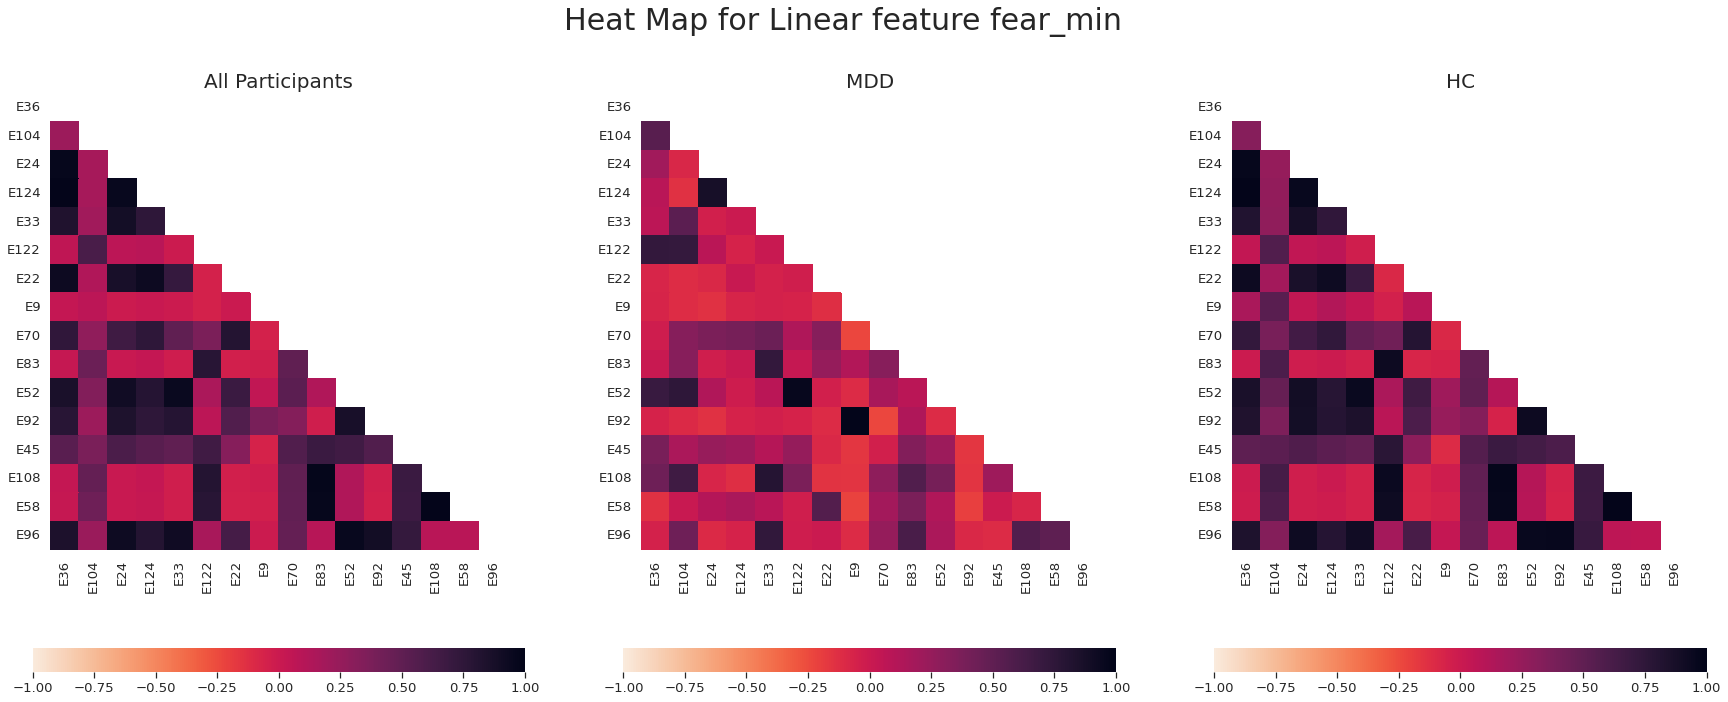

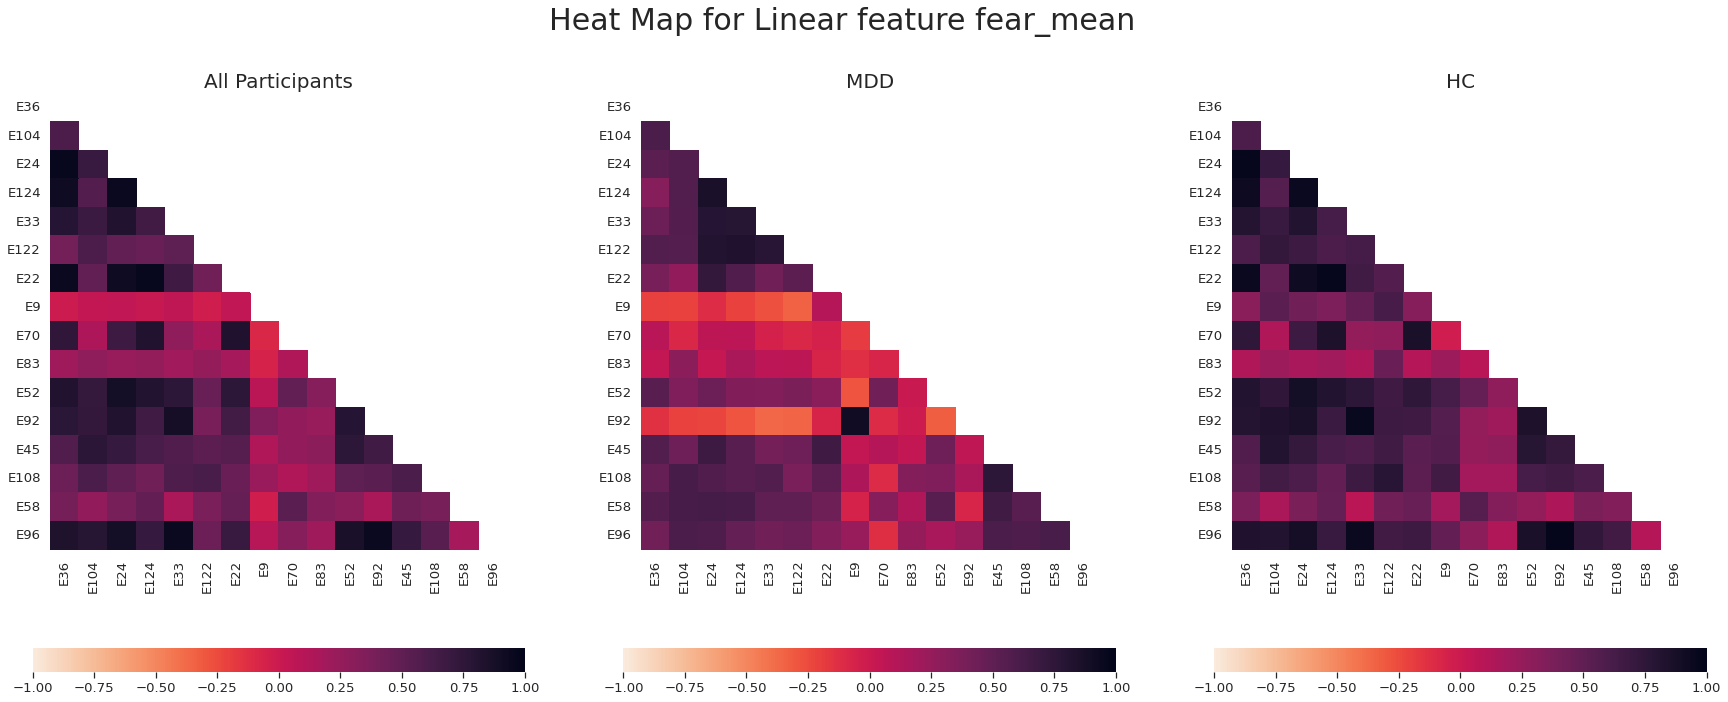

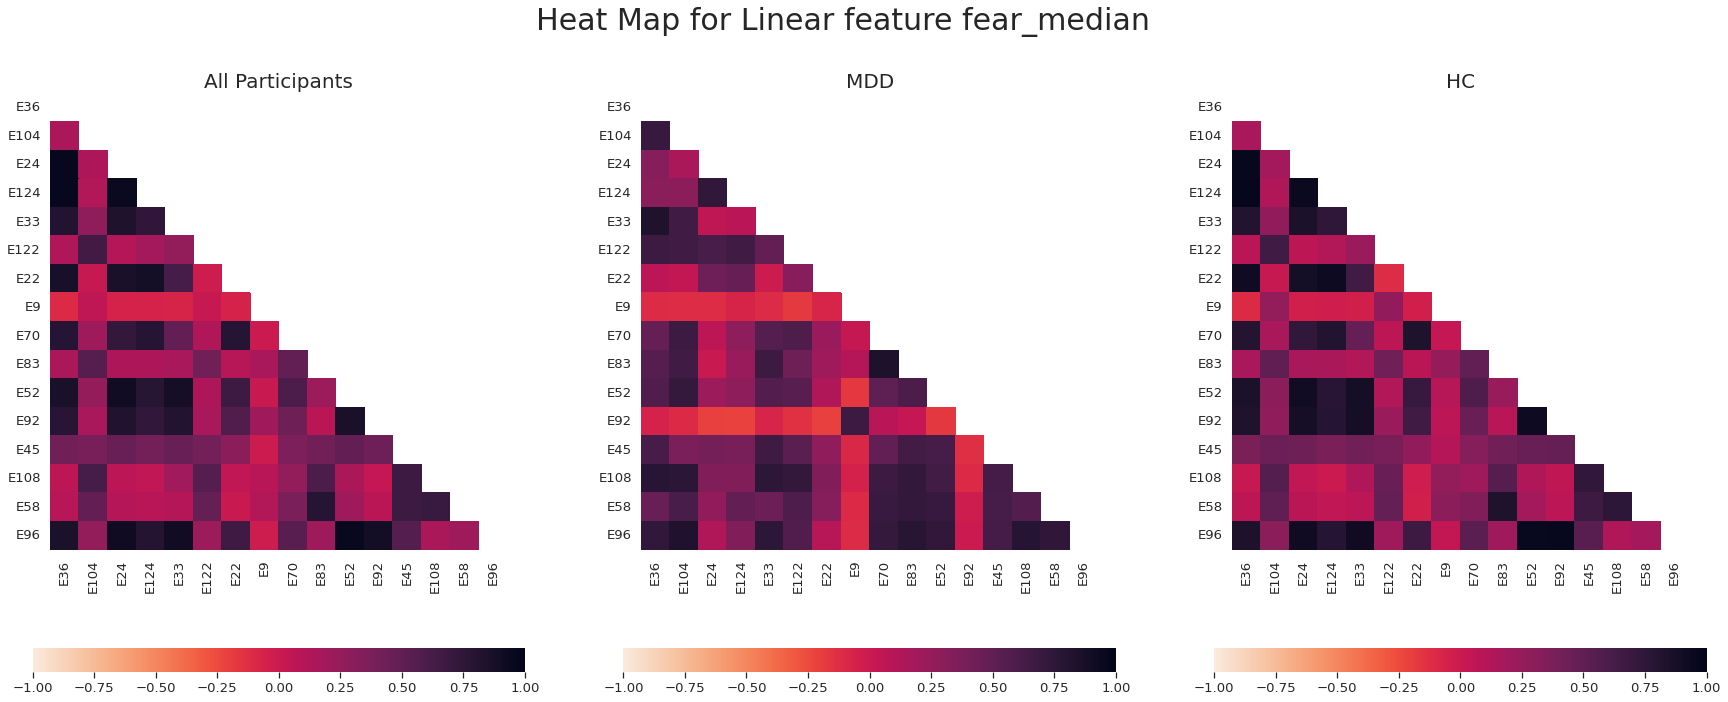

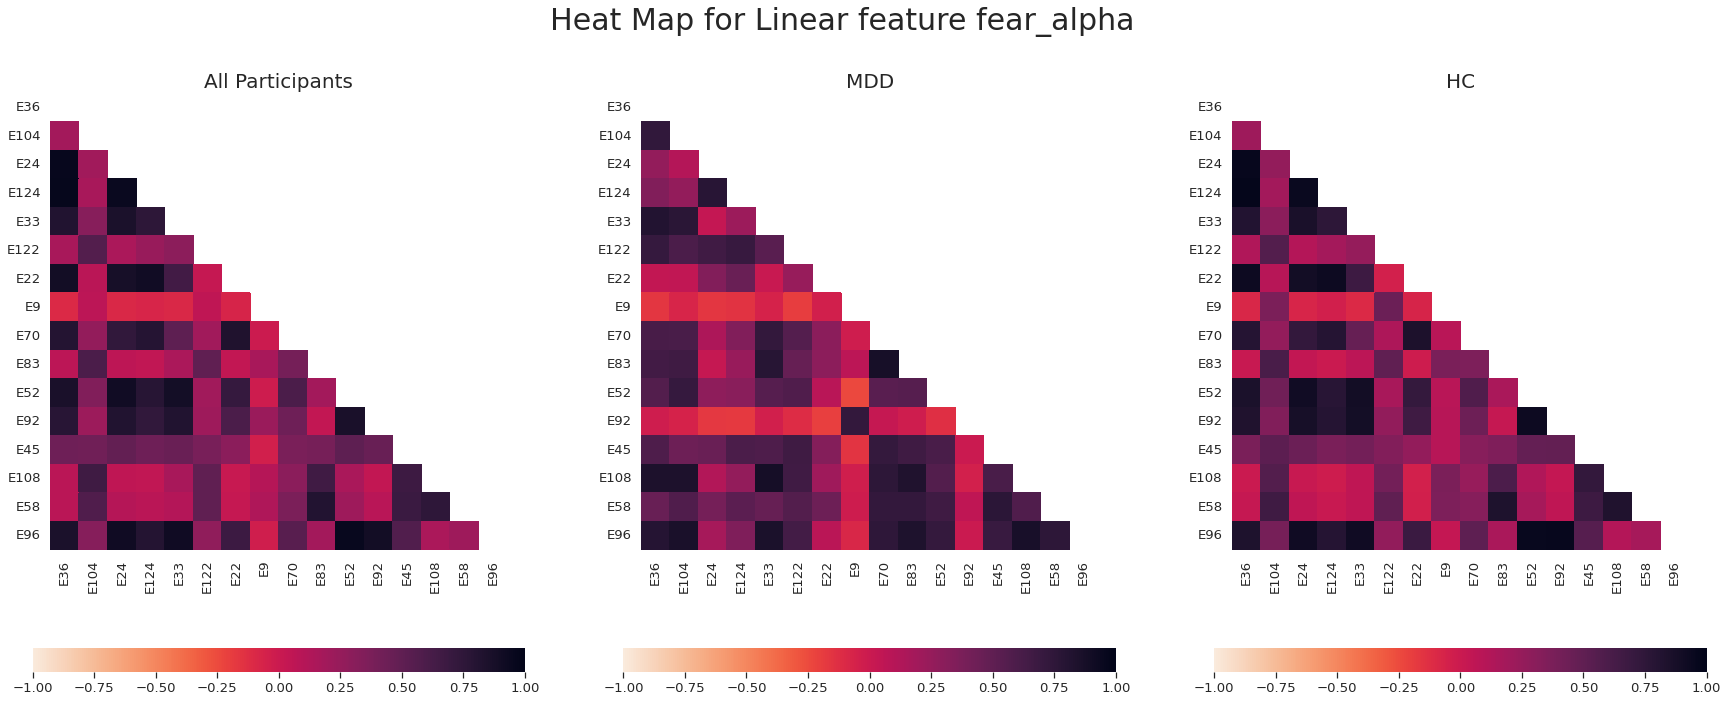

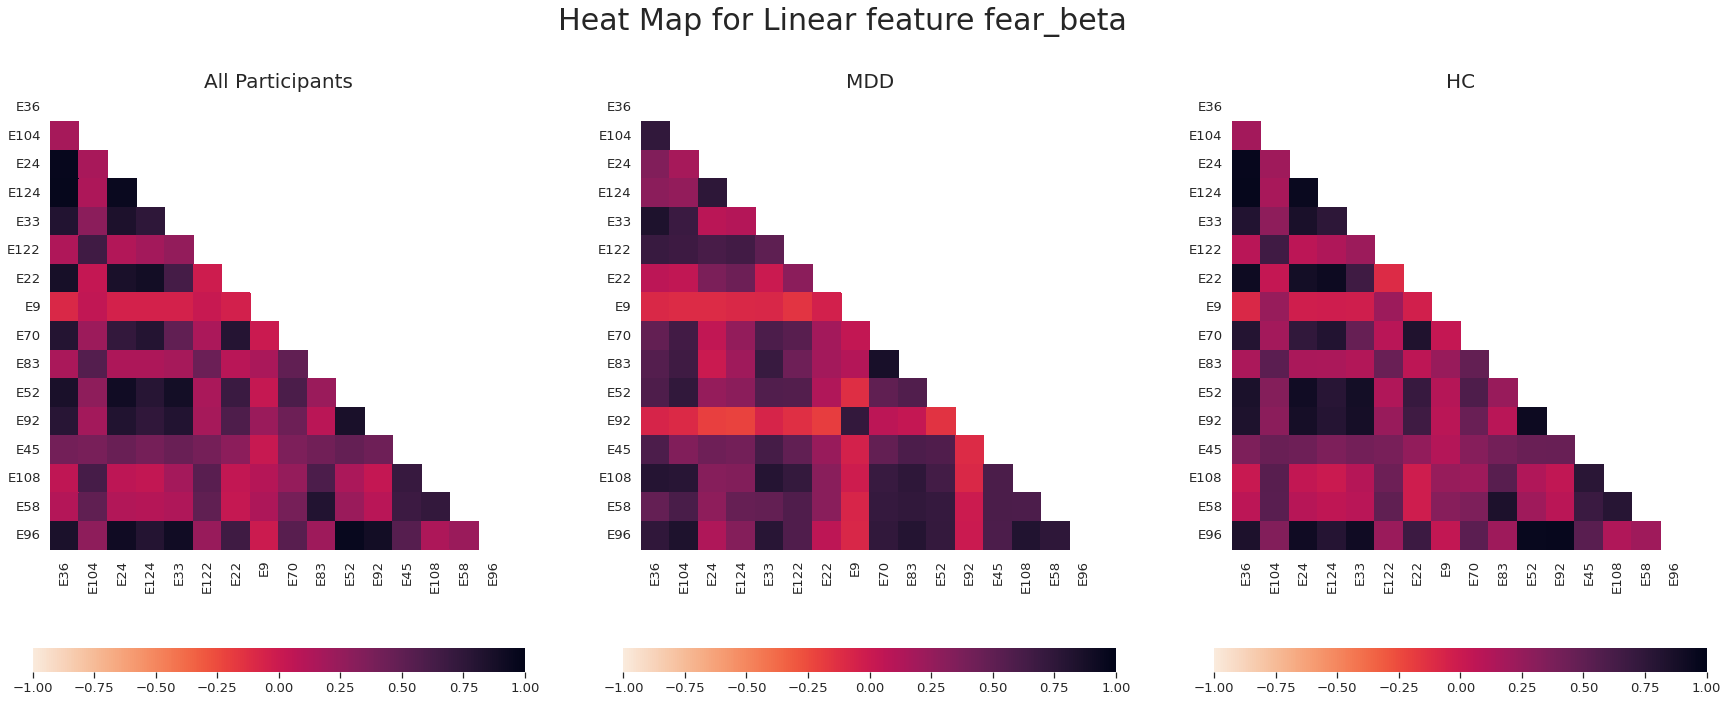

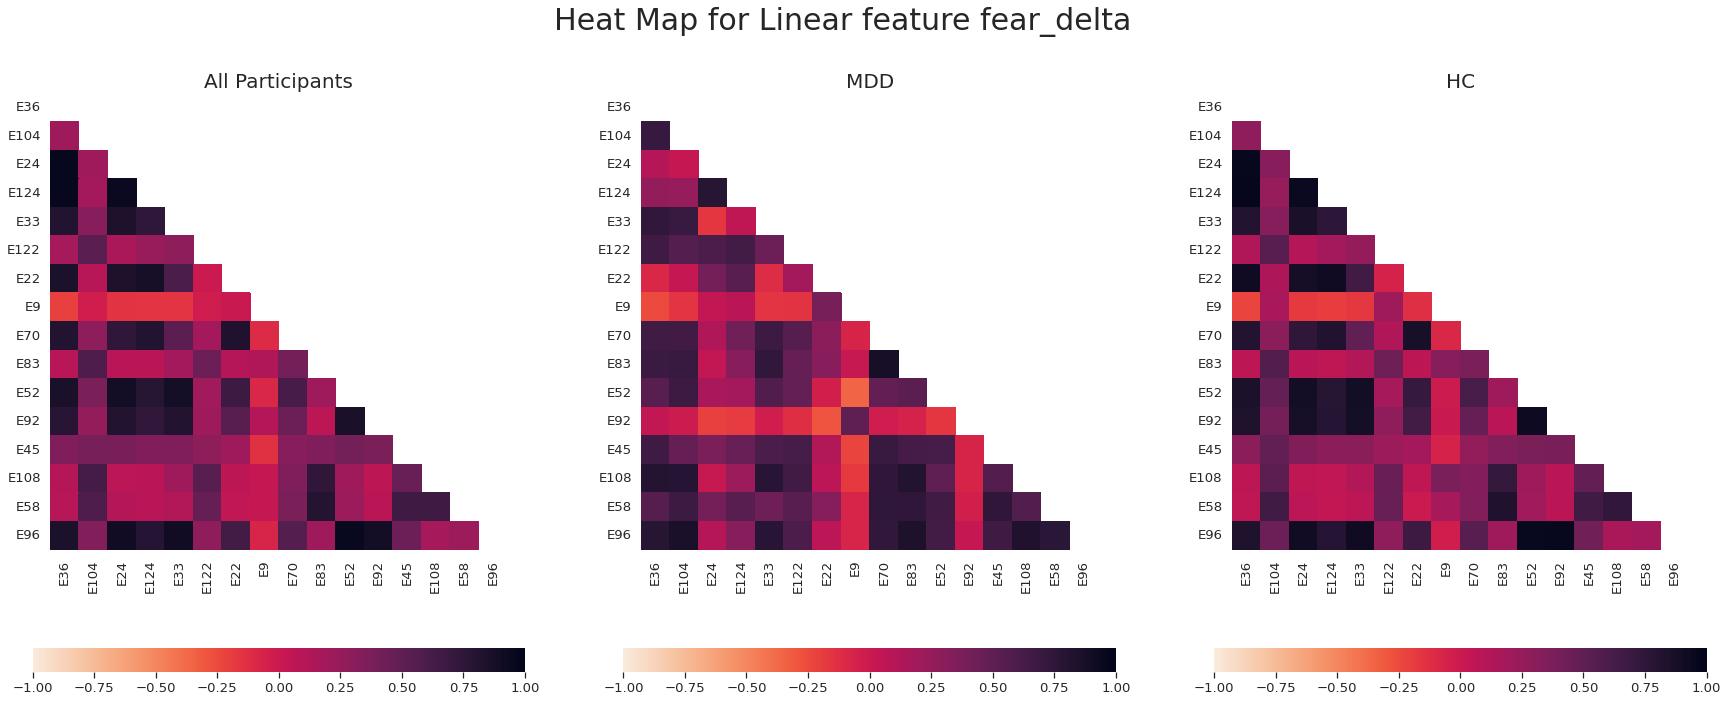

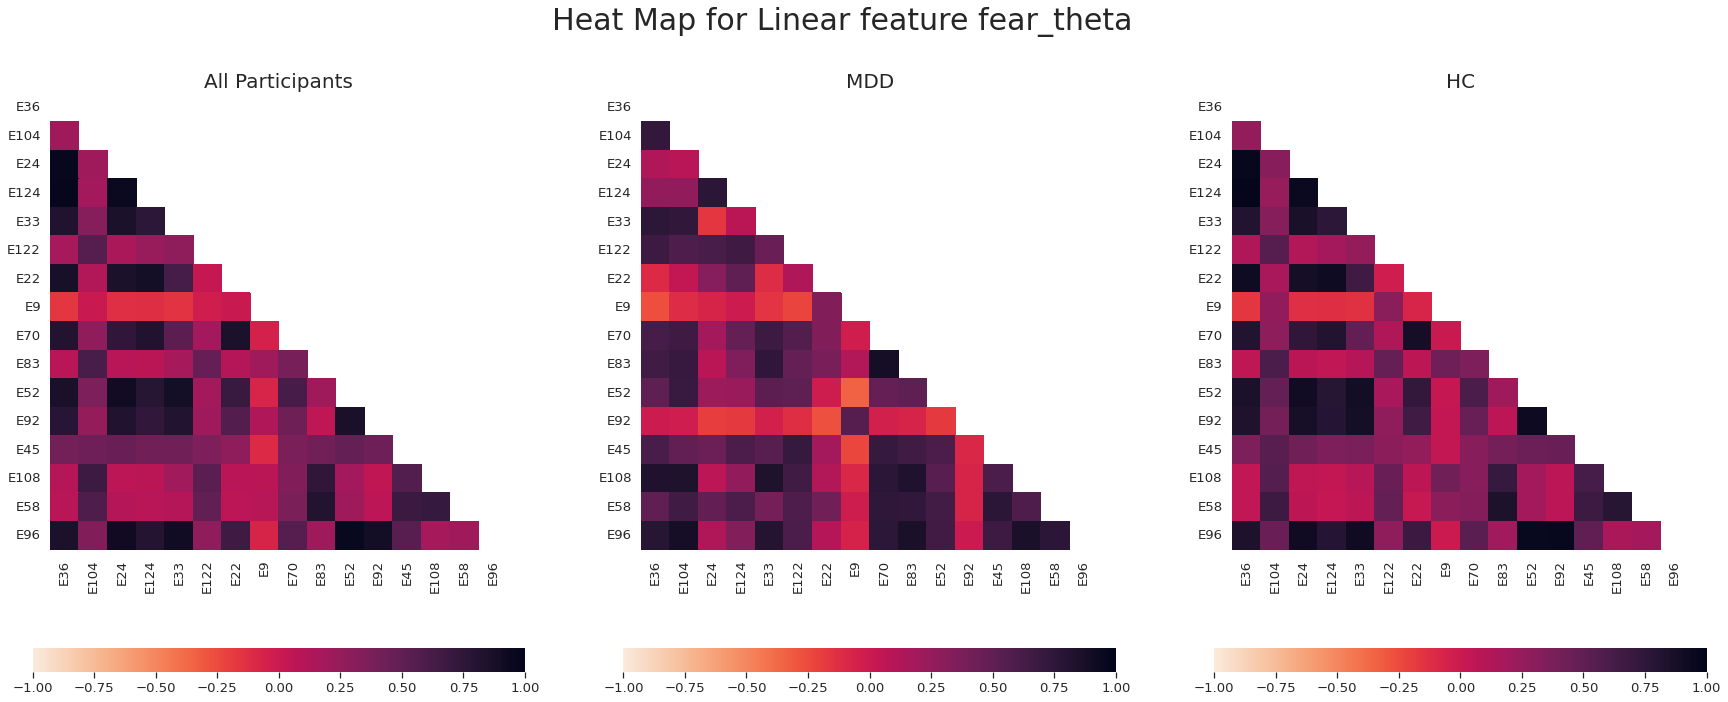

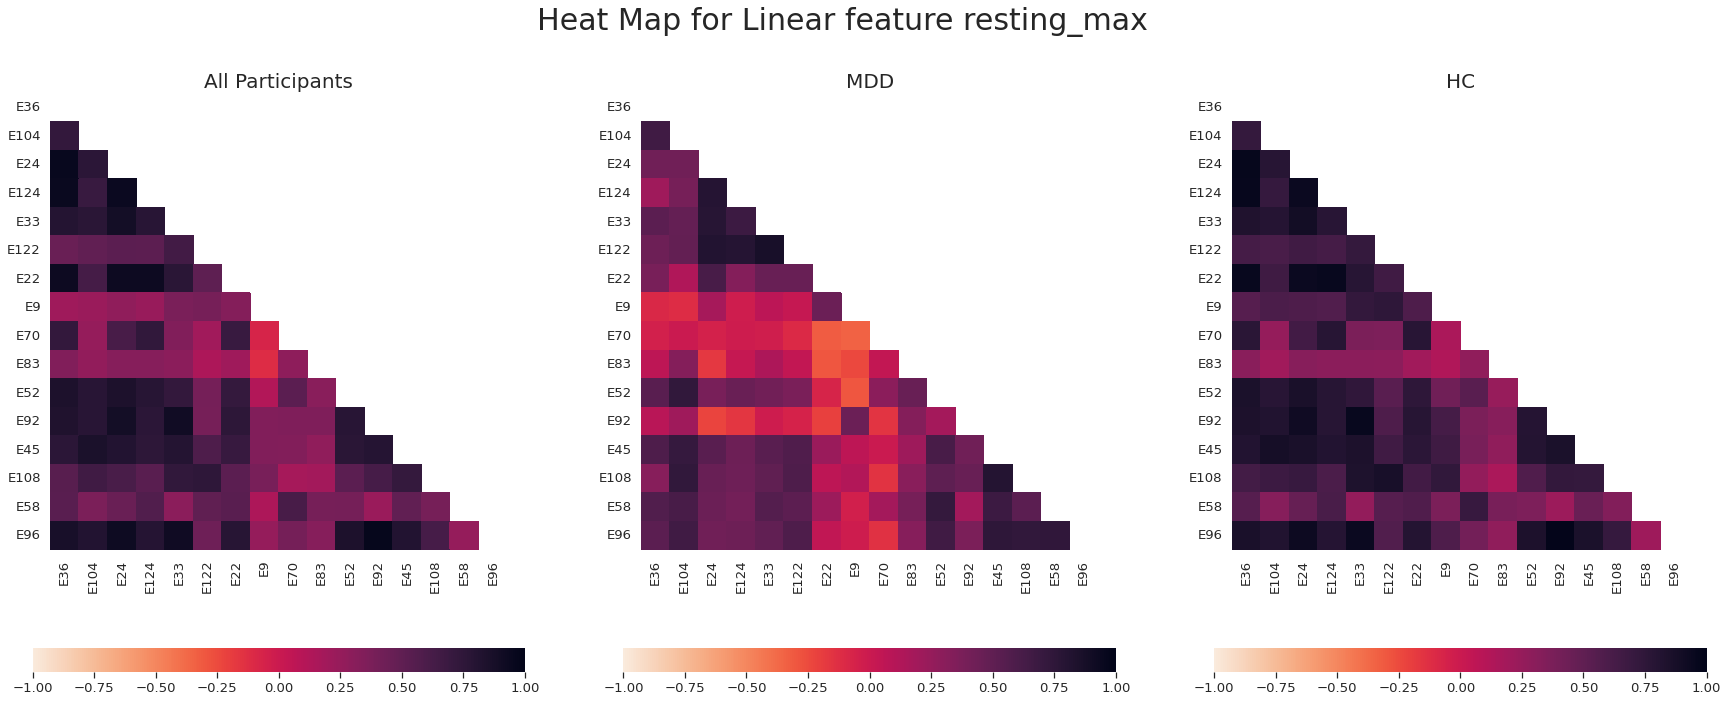

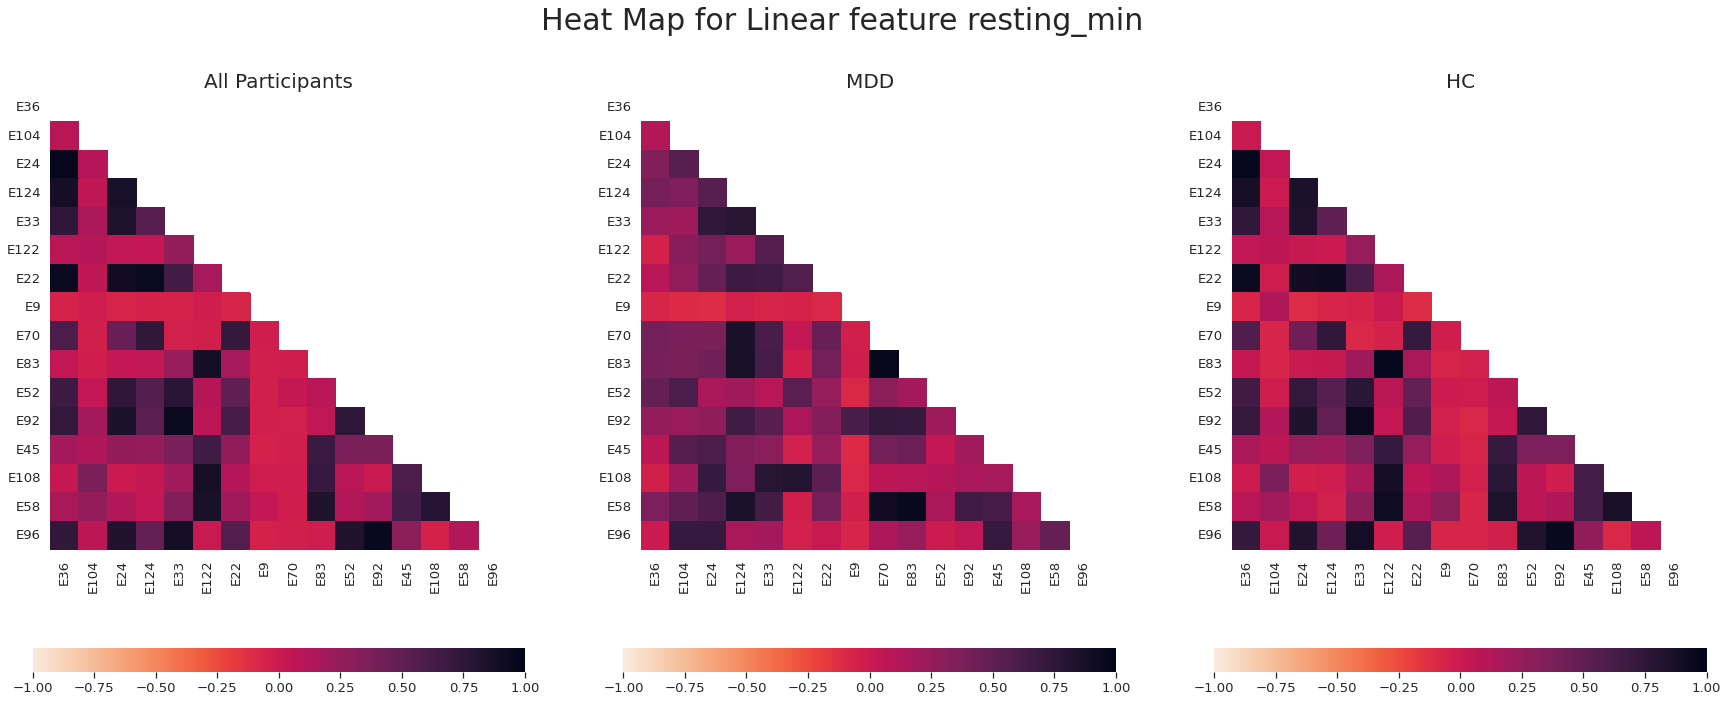

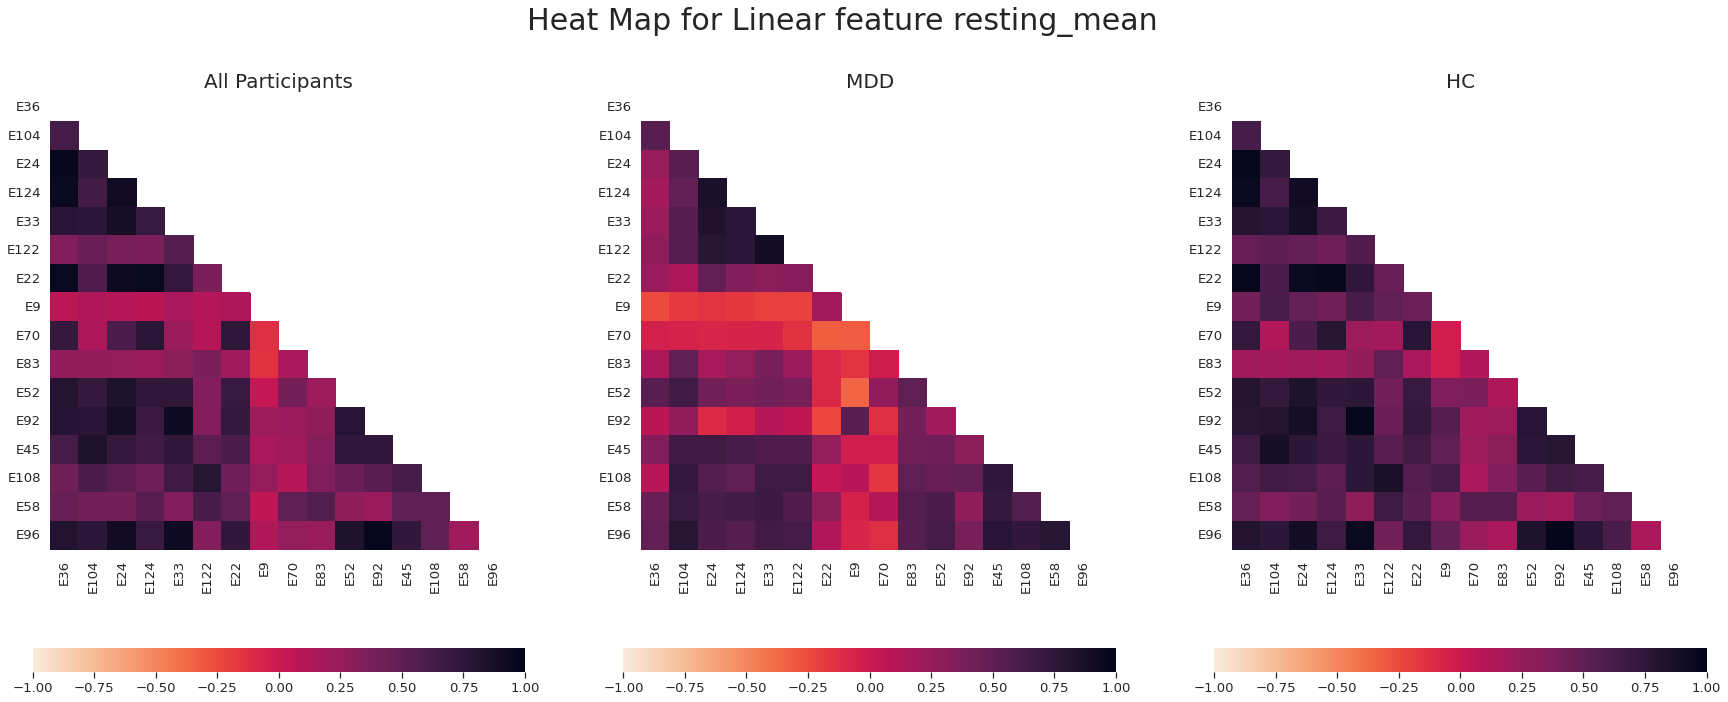

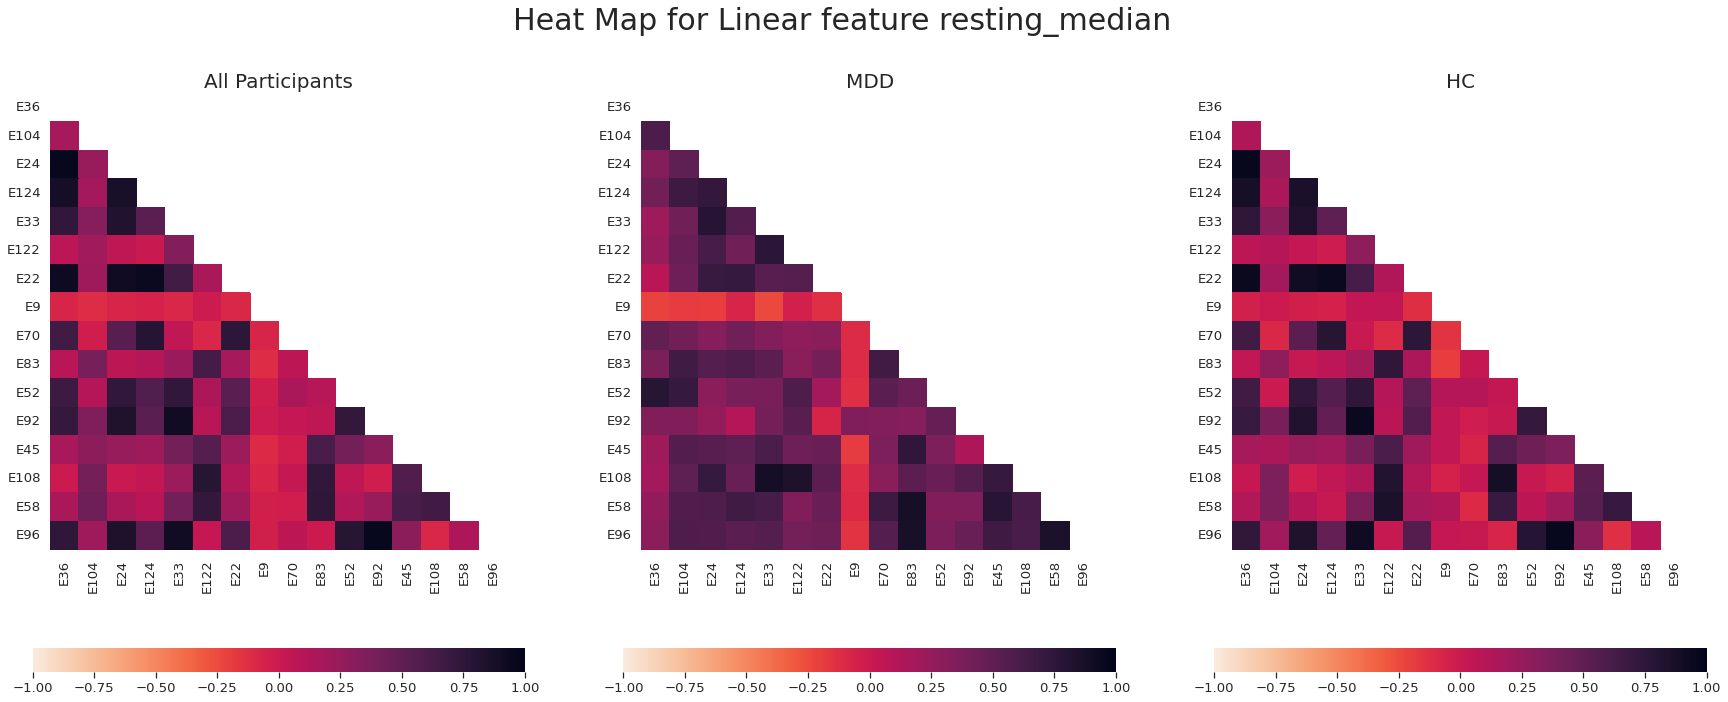

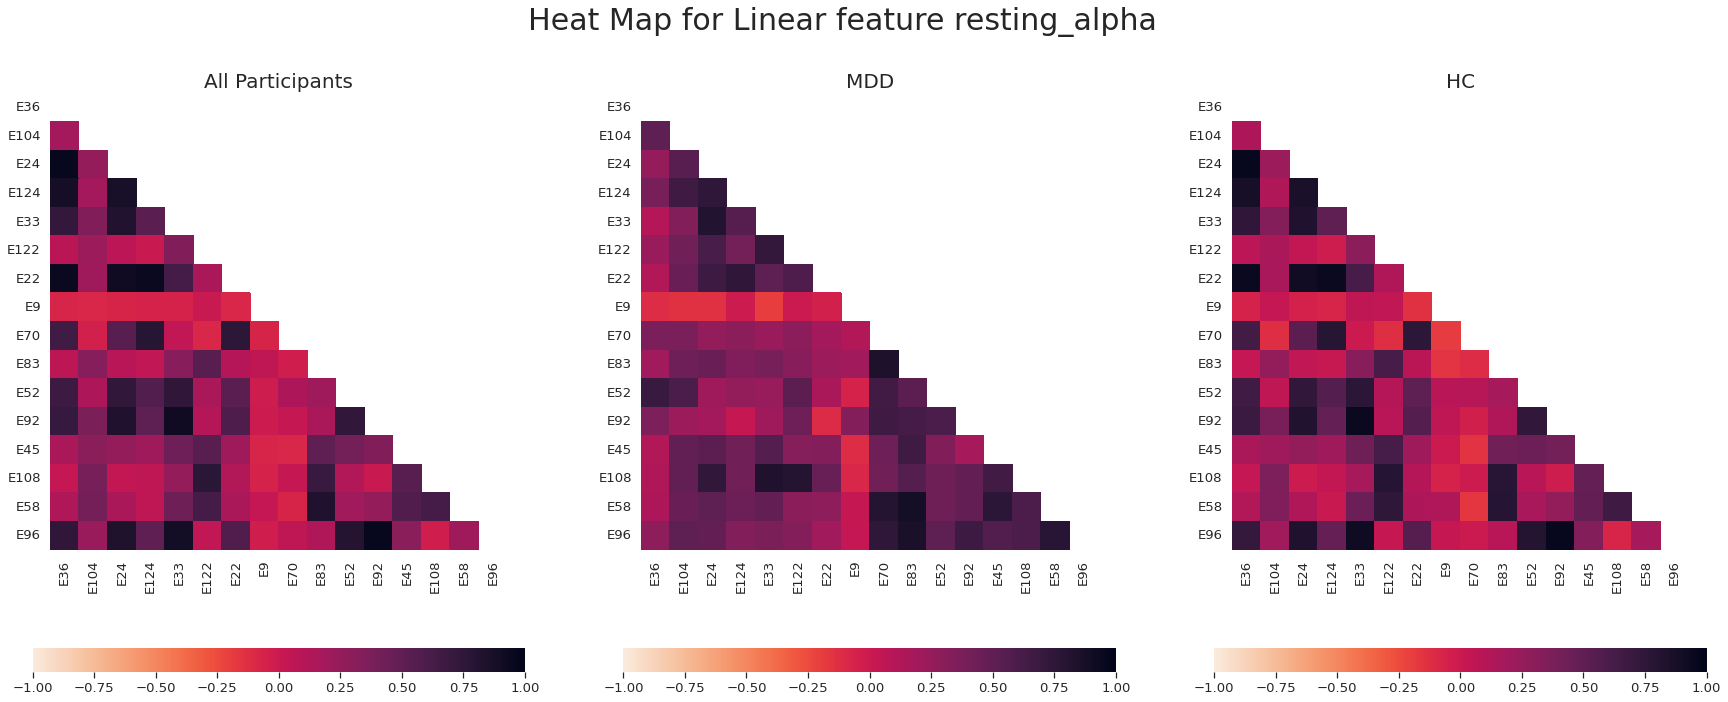

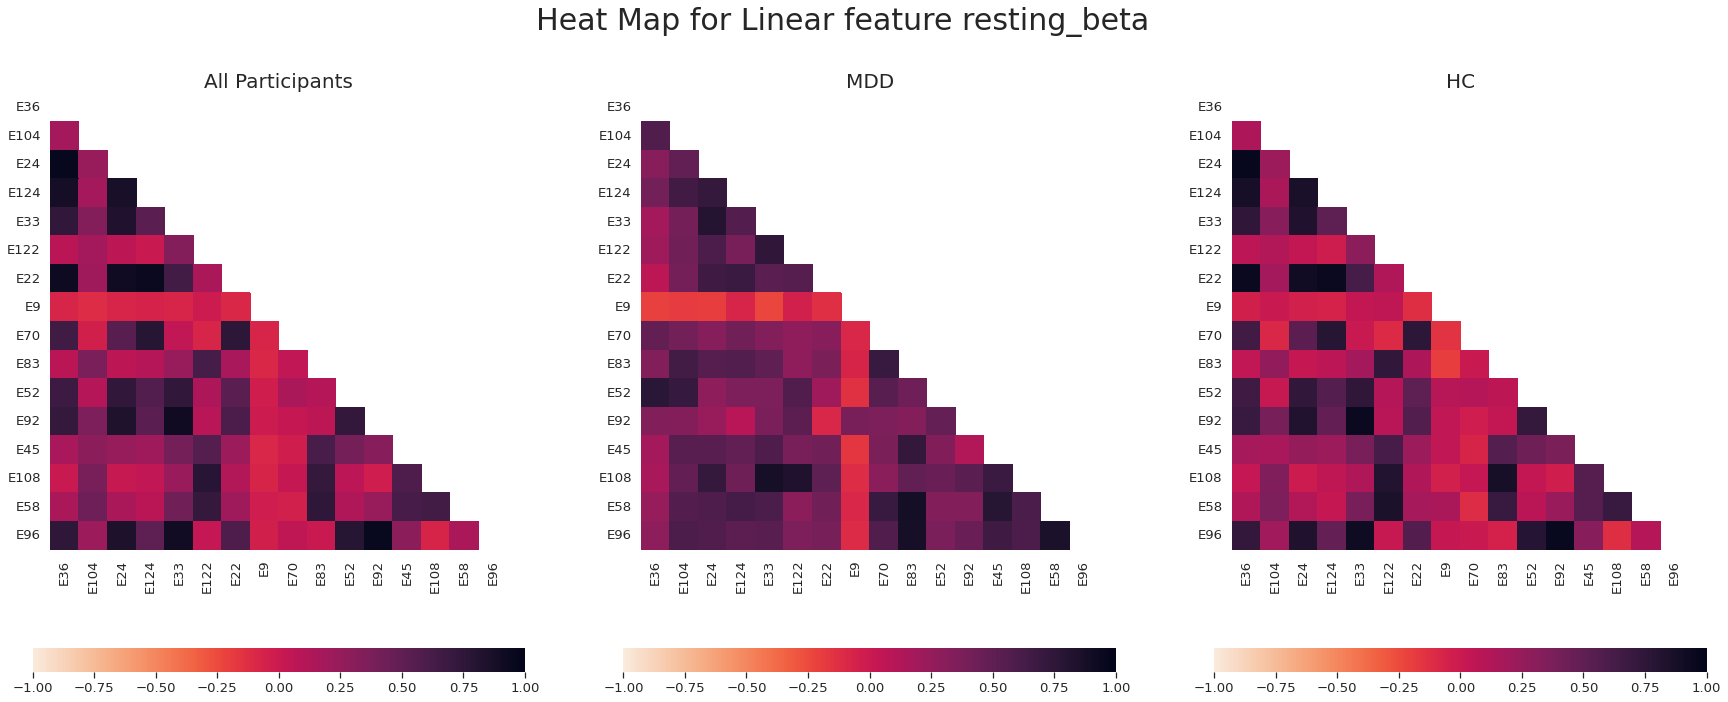

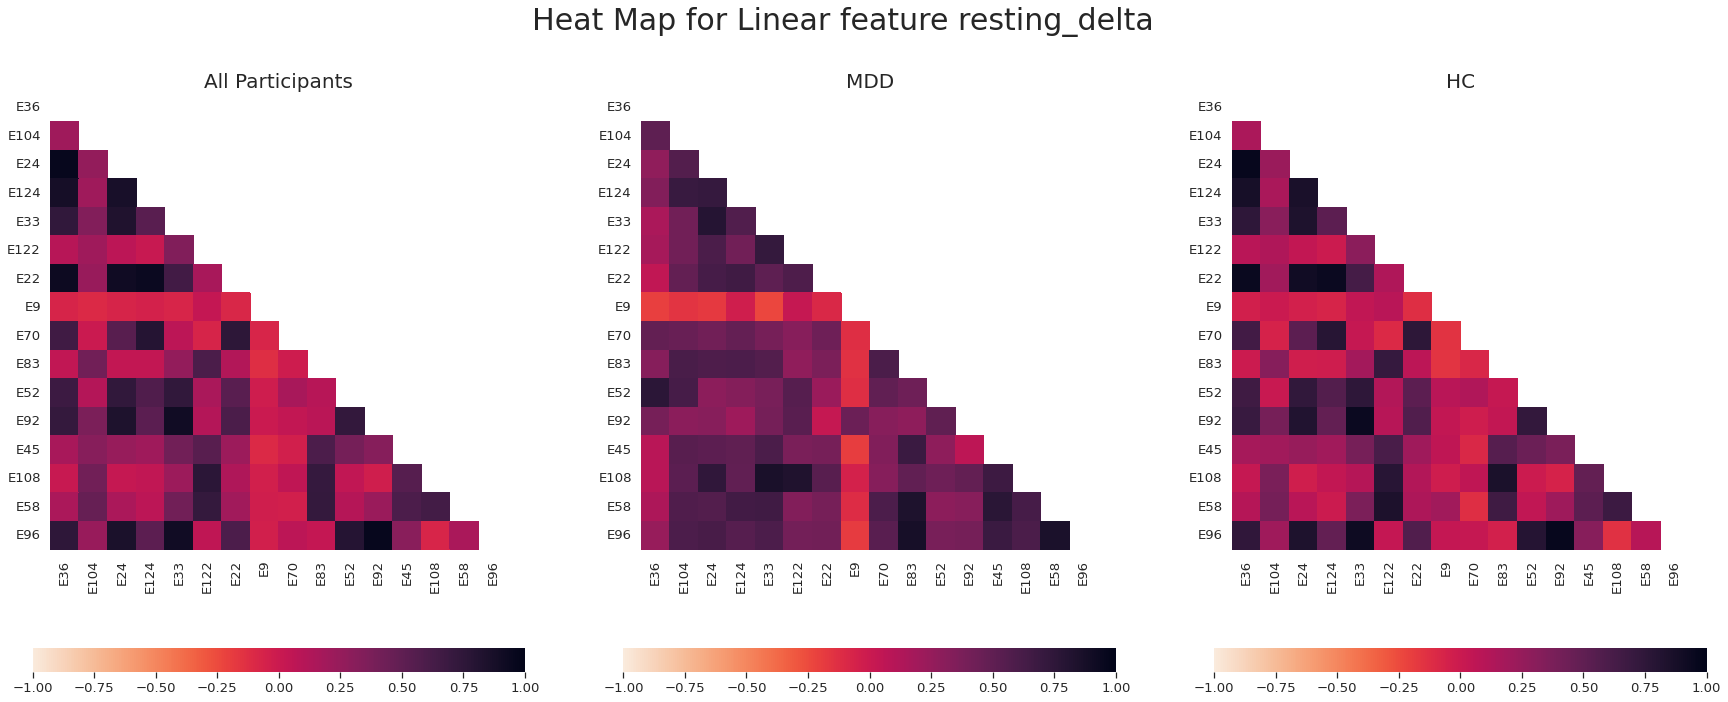

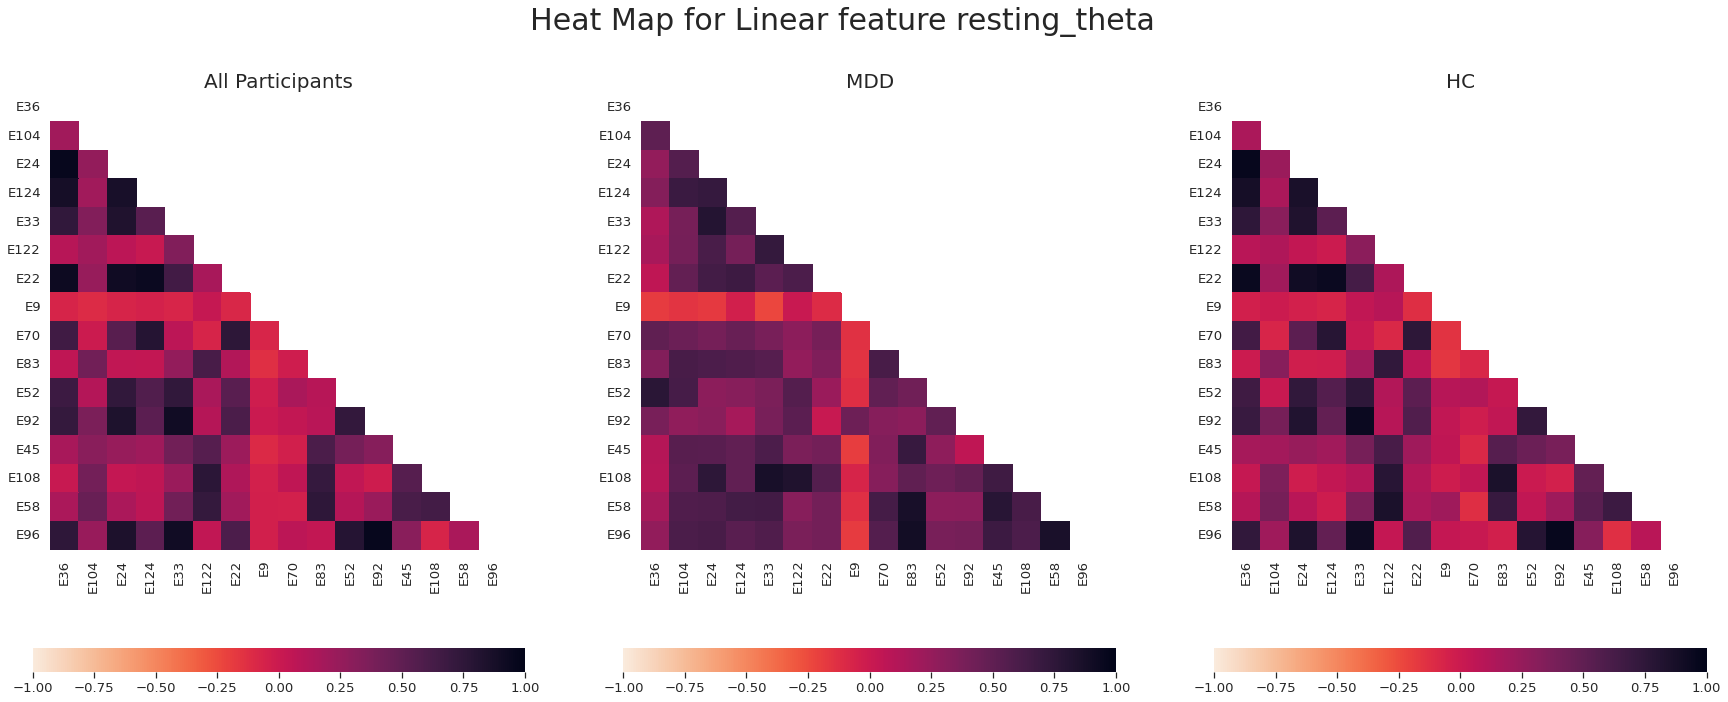

In [ ]:
columns_to_keep = []
for emotion in ['happy','sad','fear','resting']:
  for name in ['max','min','mean','median','alpha','beta','delta','theta']:
    temp = columns_extractor(df,emotion,'lf',name)
    a,b = correlation_builder(temp,prefix = 'Linear feature '+emotion+'_'+name)
    temp.drop(columns = 'type',inplace=True)
    columns_to_keep.extend(['lf_'+name+'_'+emotion+'_'+i for i in temp.columns[column_eliminator(a,thr = 0.8)]])

In [ ]:
len(columns_to_keep)

259

<b>Conclusion:</b> 

The heat maps for various variables explained that certain electrodes in frontal areas have weaker correlation compared to others in MDD participants. An interesting observation further for our classification exercise

Through the process, we reduced the linear feature columns in our dataset from 500+ to 330 selected features


In [ ]:
#Few visualizations concluding this section
for i in ['happy','fear','sad','resting']:
  for j in ['alpha','beta','delta','theta']:
    df['lf'+'_'+i+'_'+j] = np.mean(df[[x for x in df.columns if 'lf' in x and i in x and j in x]],axis = 1)


In [ ]:
for i in ['happy','fear','sad','resting']:
  for j in ['mean','median','min','max']:
    df['lf'+'_'+i+'_'+j] = np.mean(df[[x for x in df.columns if 'lf' in x and i in x and j in x]],axis = 1)


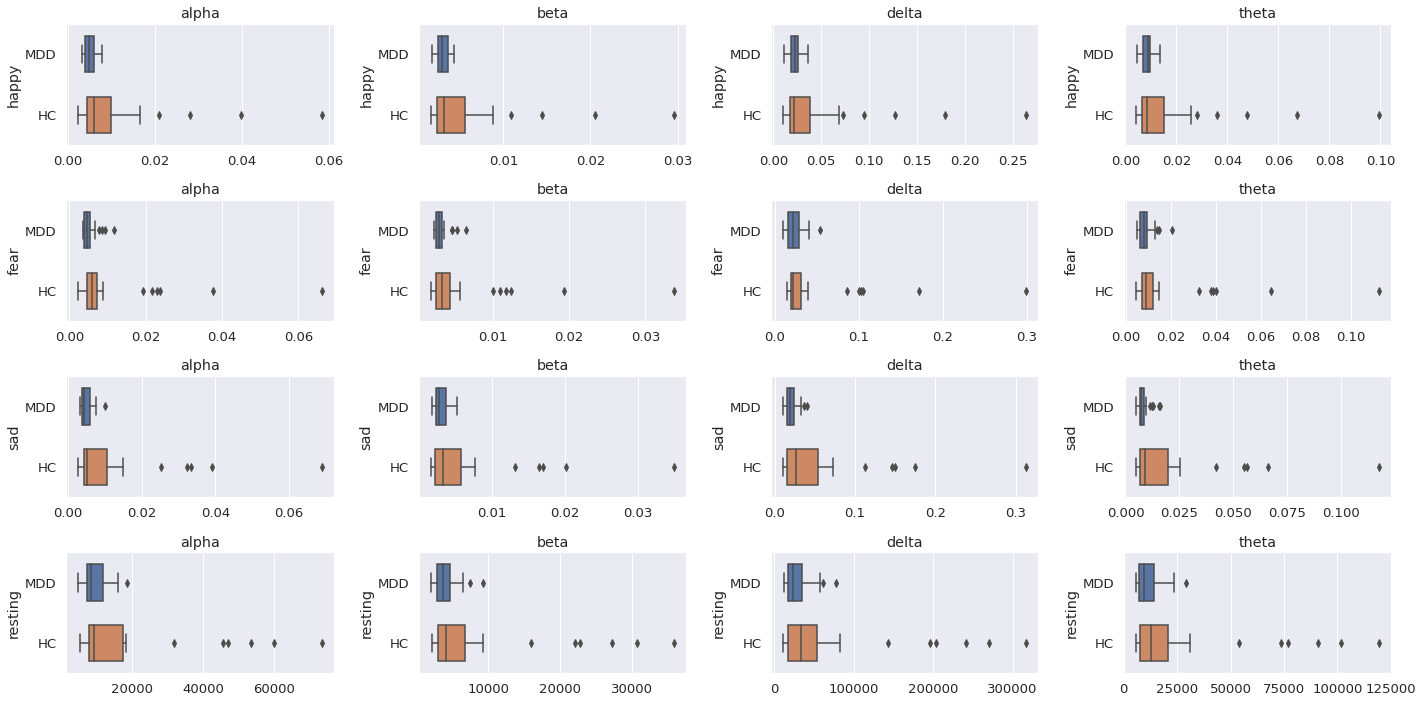

In [ ]:
fig = plt.figure(figsize=(20,10))
a = dict()
i = 0
for emotion in ['happy','fear','sad','resting']:
  for signal in ['alpha','beta','delta','theta']:
    a[i] = fig.add_subplot(4,4,i+1)
    sns.boxplot(x='lf'+'_'+emotion+'_'+signal, y="type",data = df,width=.6,ax = a[i])
    a[i].set(ylabel=emotion,xlabel = '',title = signal)
    i = i + 1
fig.tight_layout()

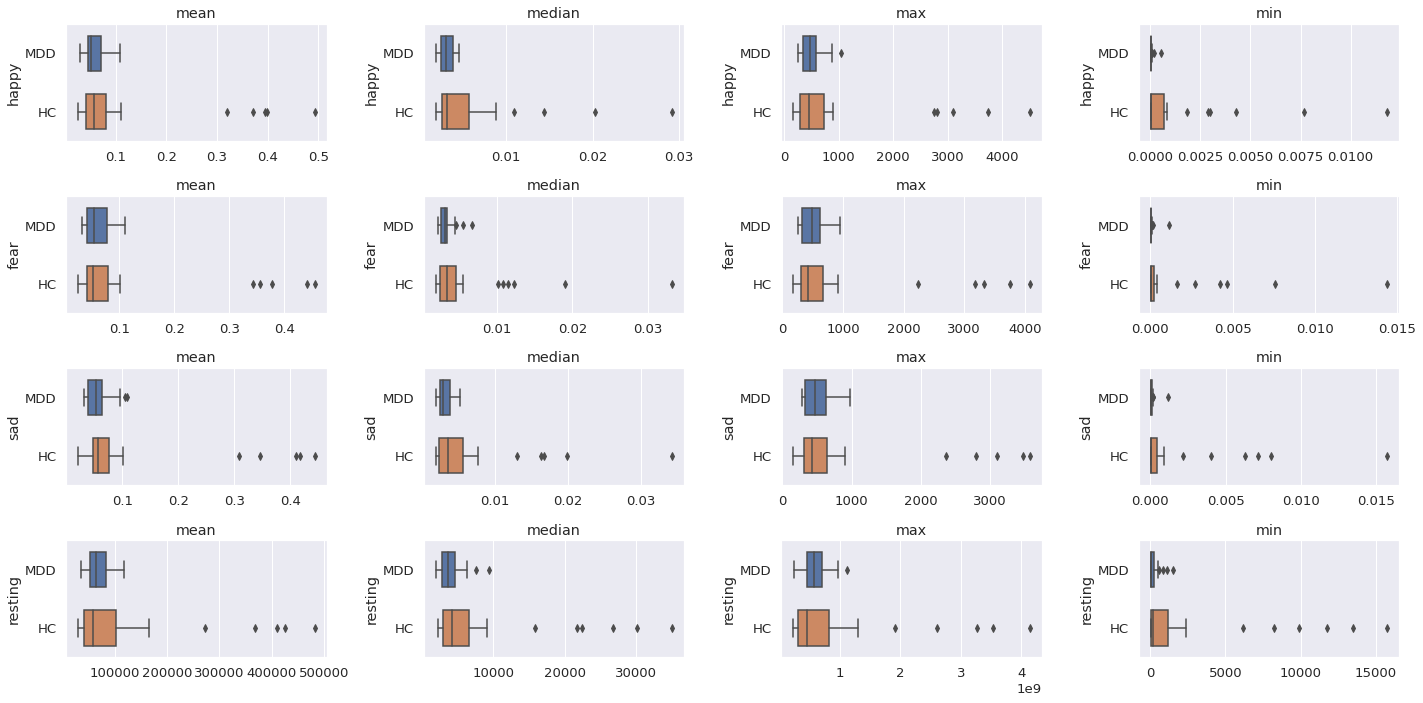

In [ ]:
fig = plt.figure(figsize=(20,10))
a = dict()
i = 0
for emotion in ['happy','fear','sad','resting']:
  for signal in ['mean','median','max','min']:
    a[i] = fig.add_subplot(4,4,i+1)
    sns.boxplot(x='lf'+'_'+emotion+'_'+signal, y="type",data = df,width=.6,ax = a[i])
    a[i].set(ylabel=emotion,xlabel = '',title = signal)
    i = i + 1
fig.tight_layout()


## Understanding the Non Linear Features

Here we will be utilizing the utility functions that we implemented before. The process we follow is very similar. However, the number of features in this space are limited

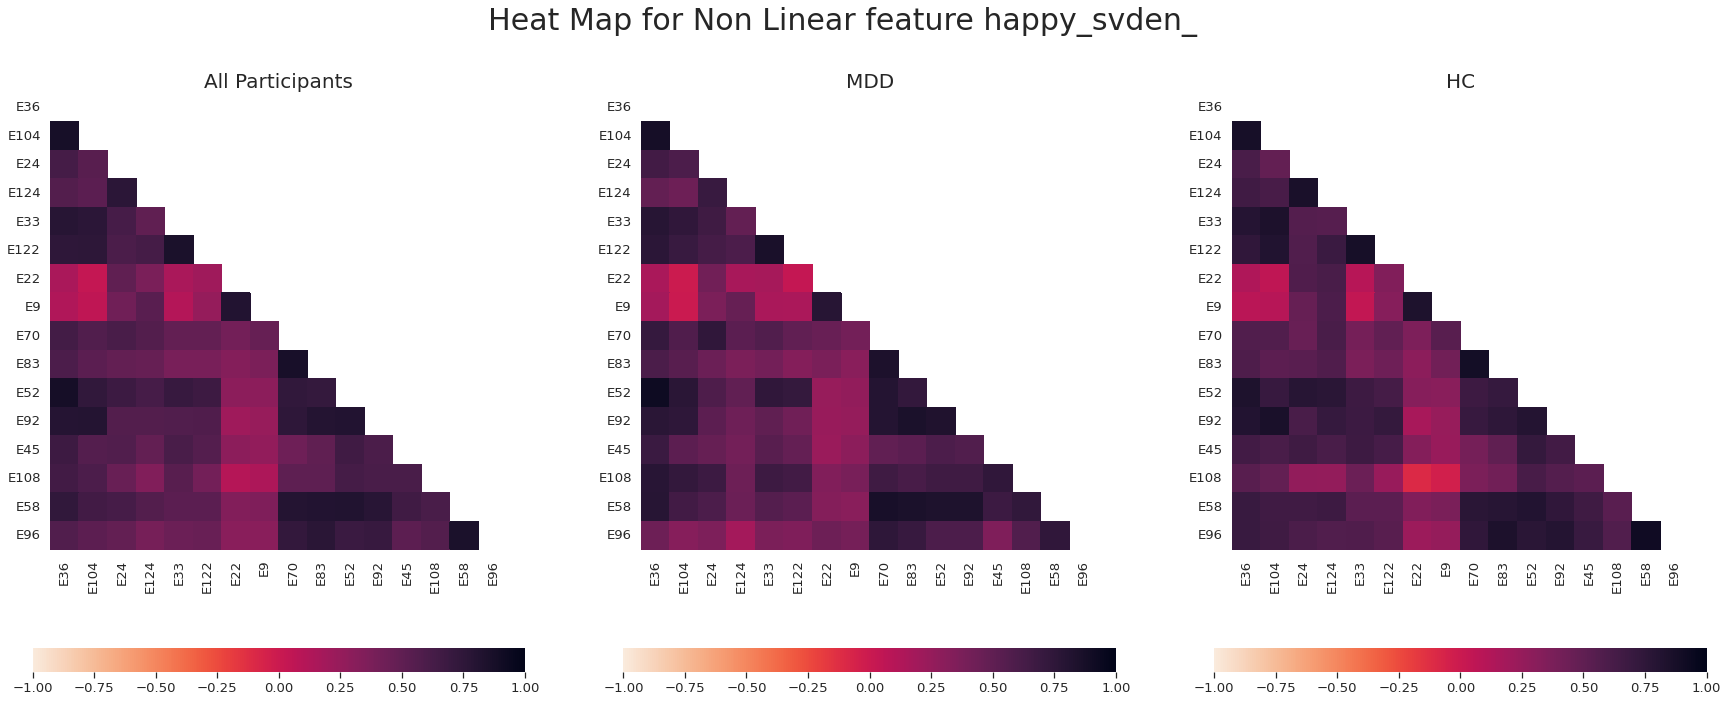

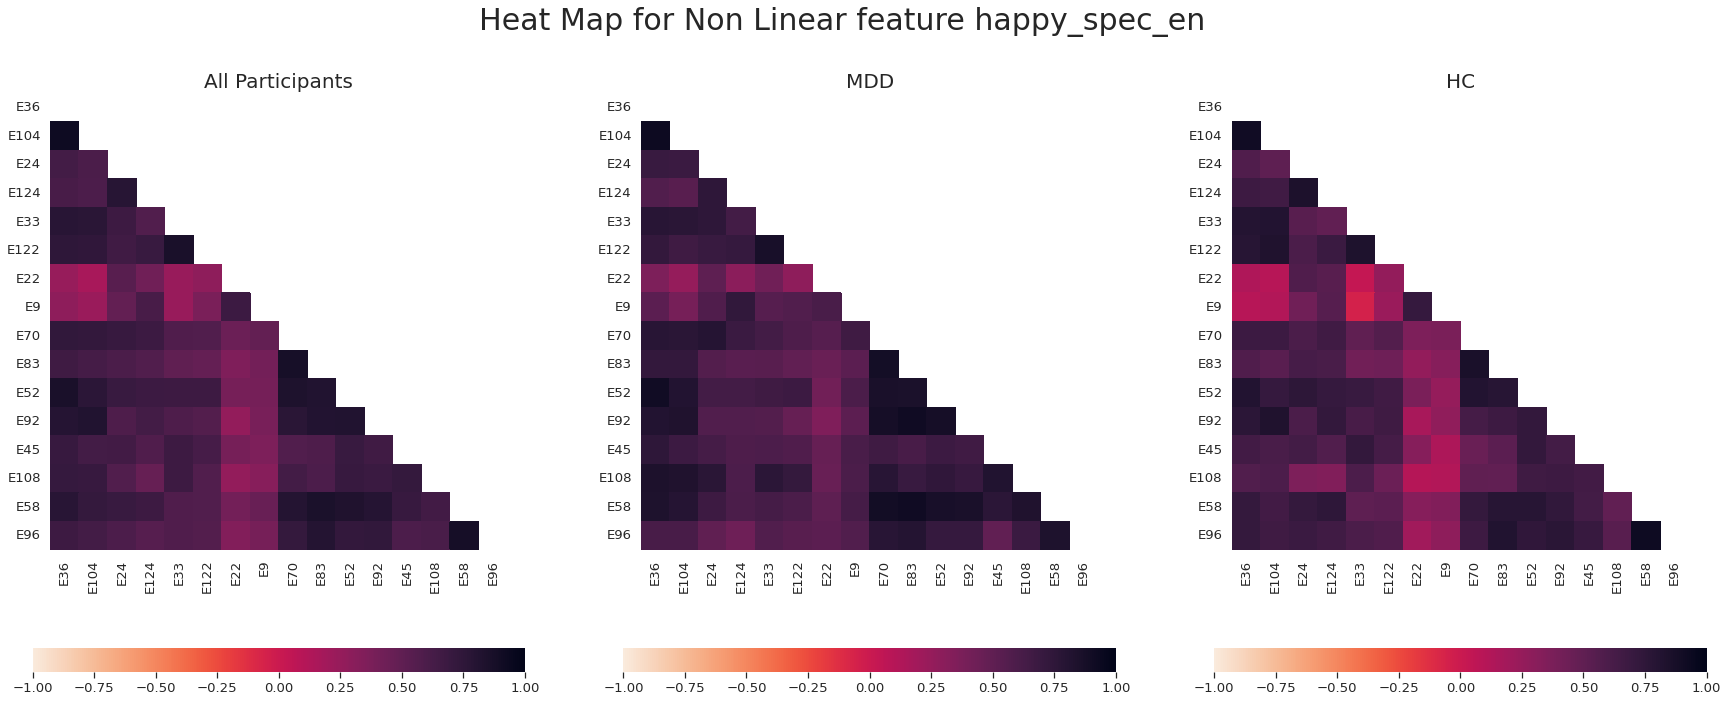

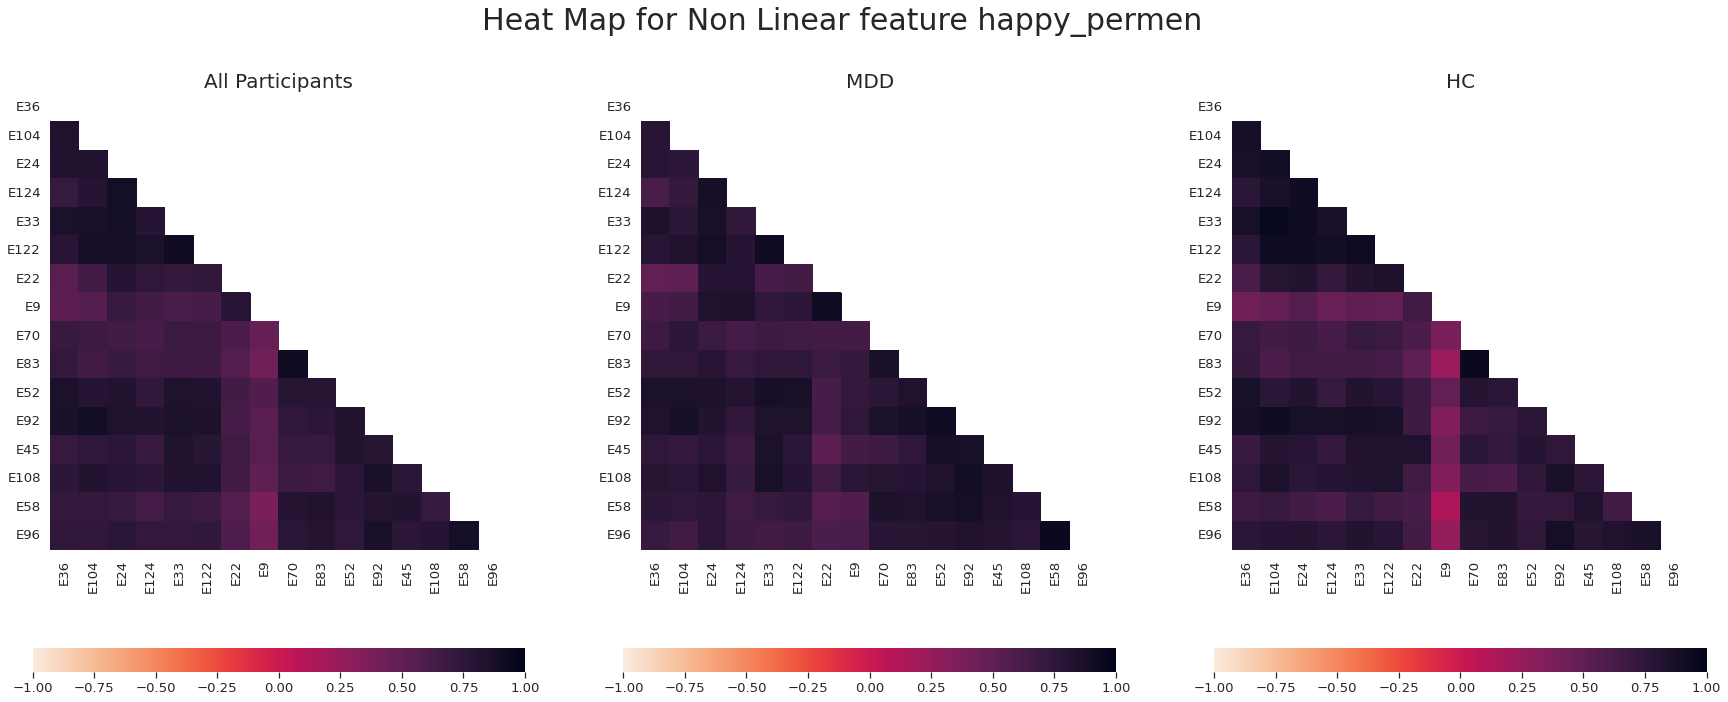

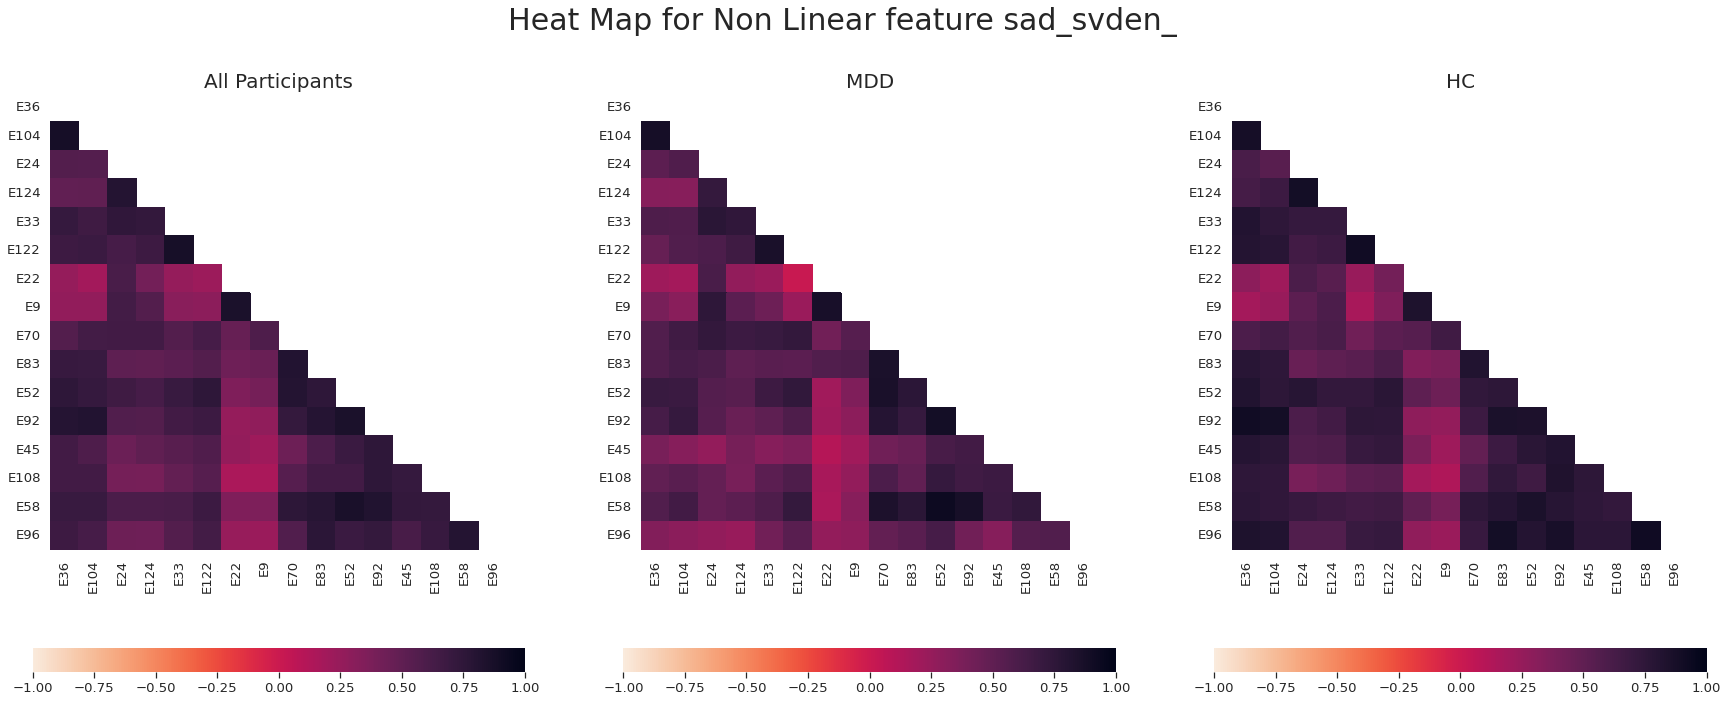

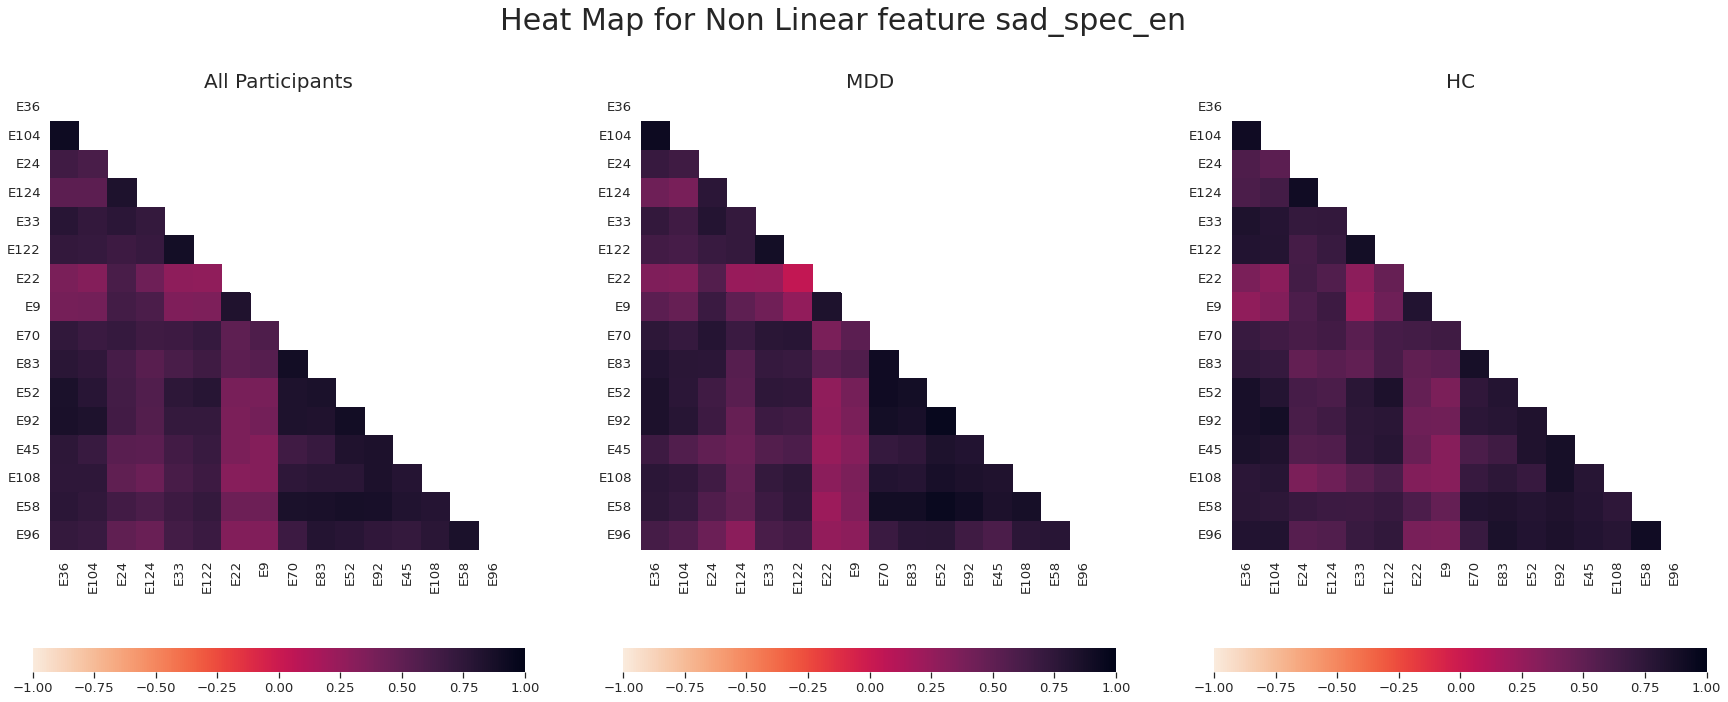

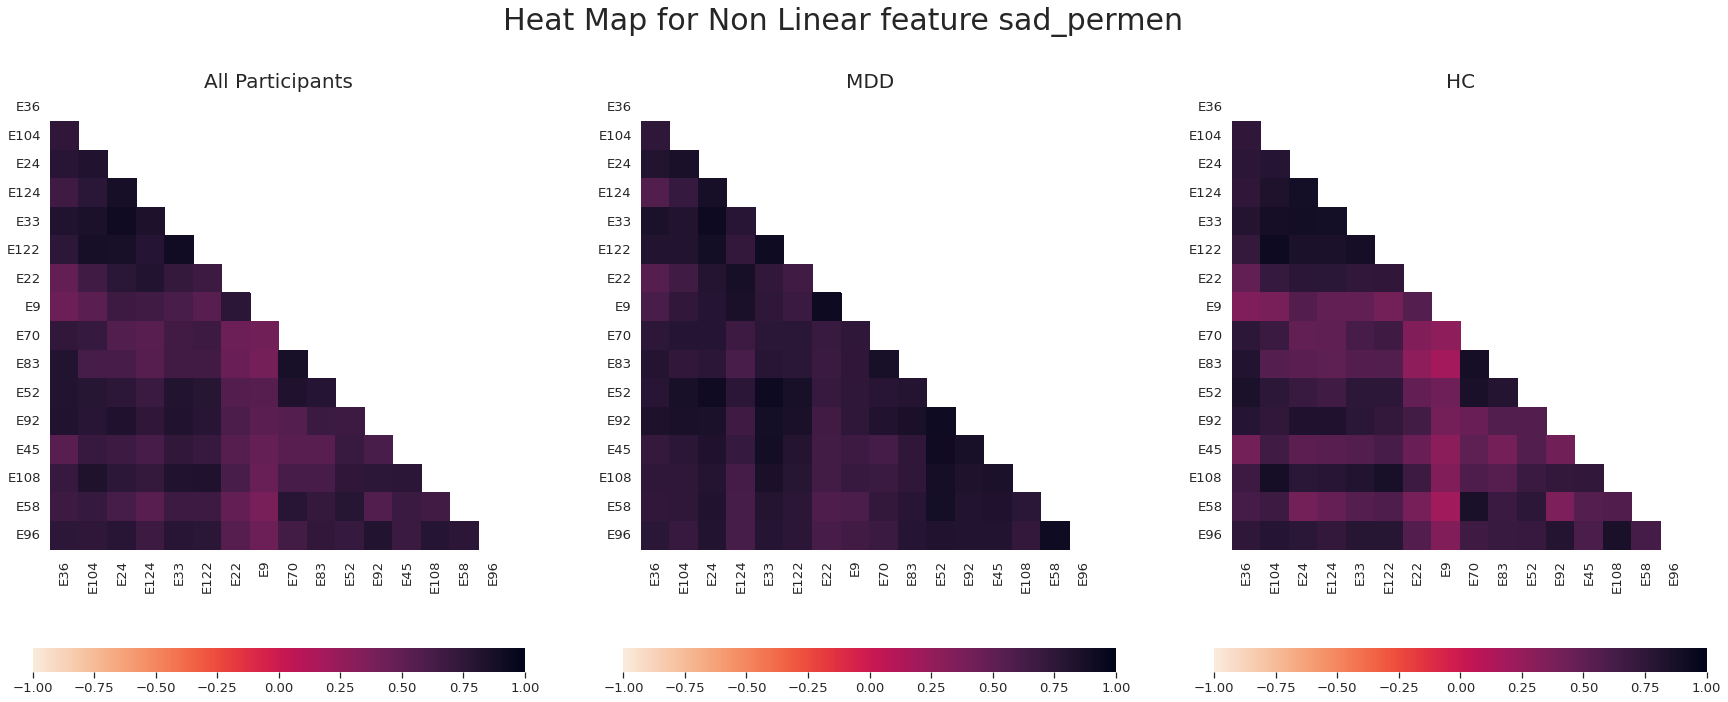

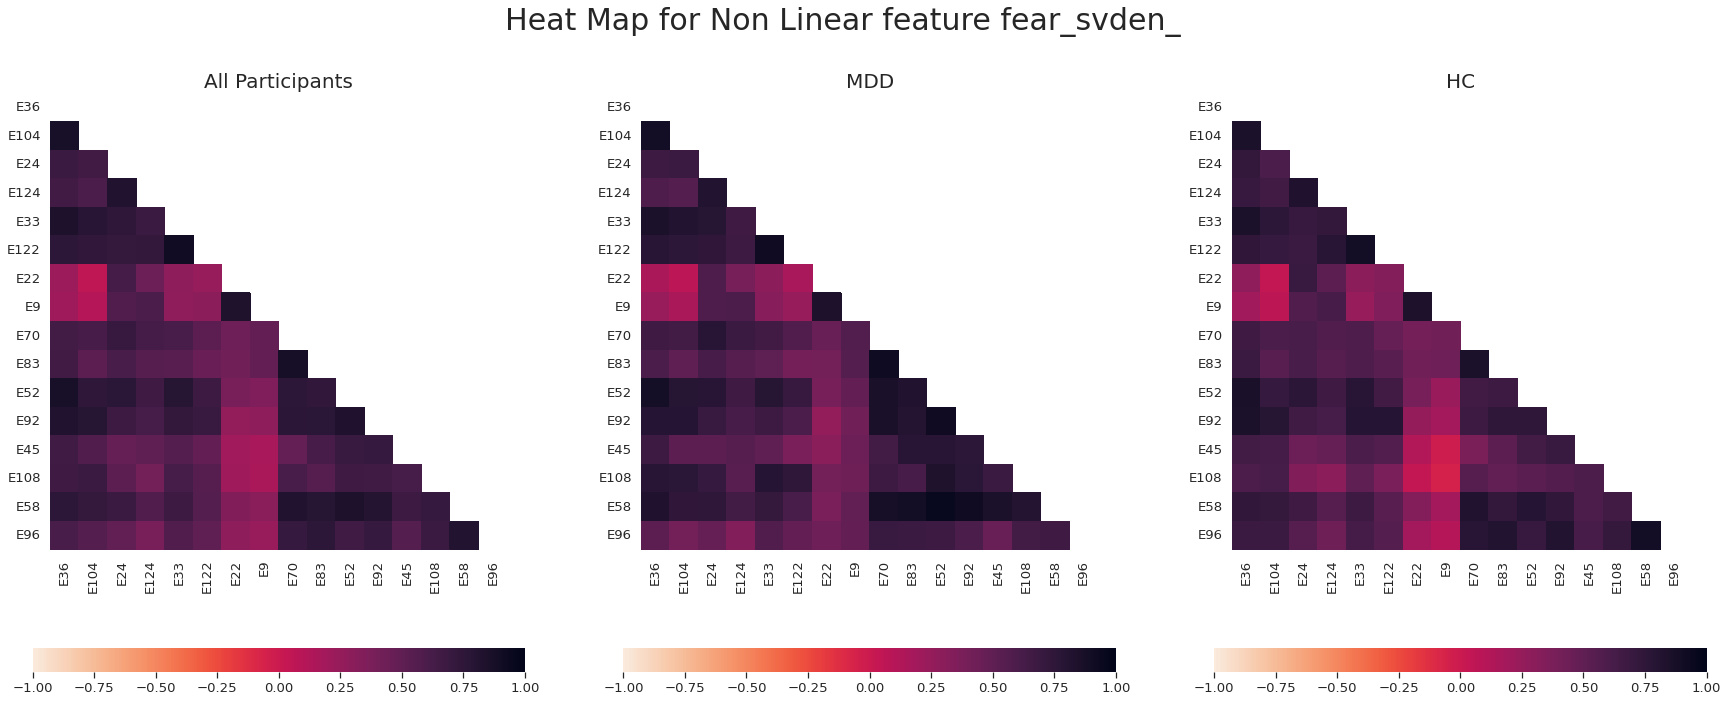

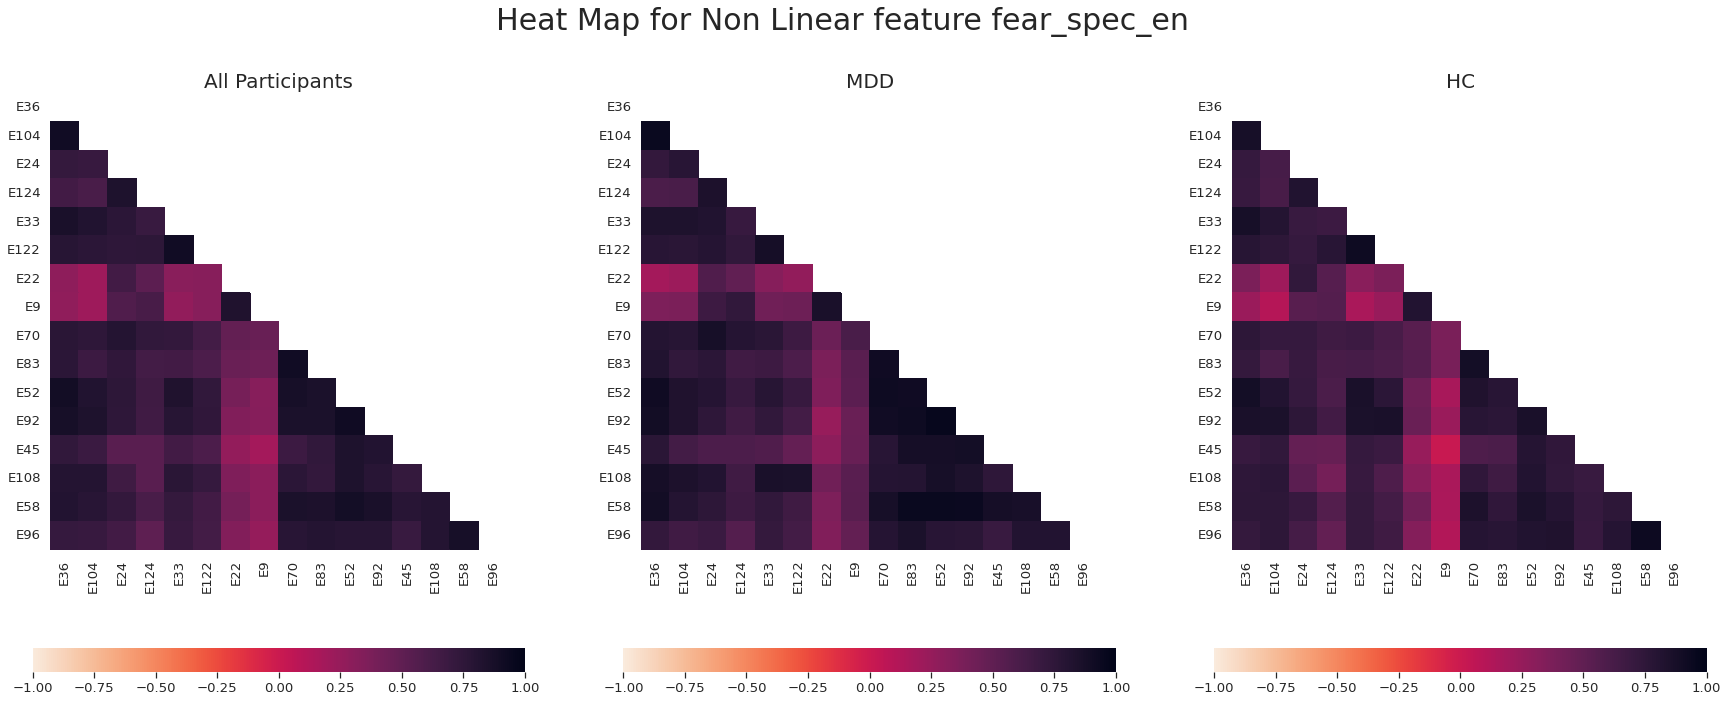

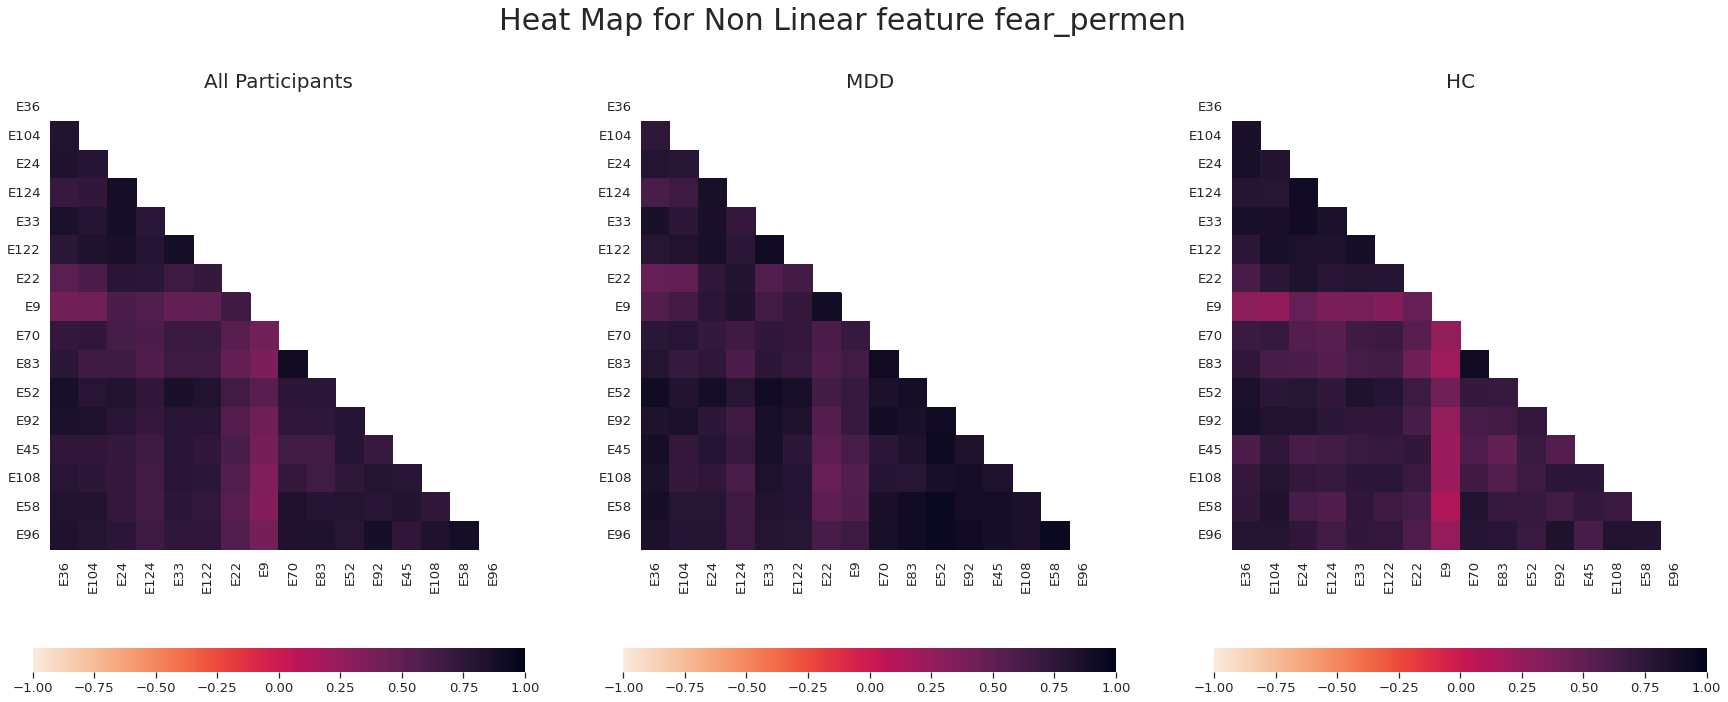

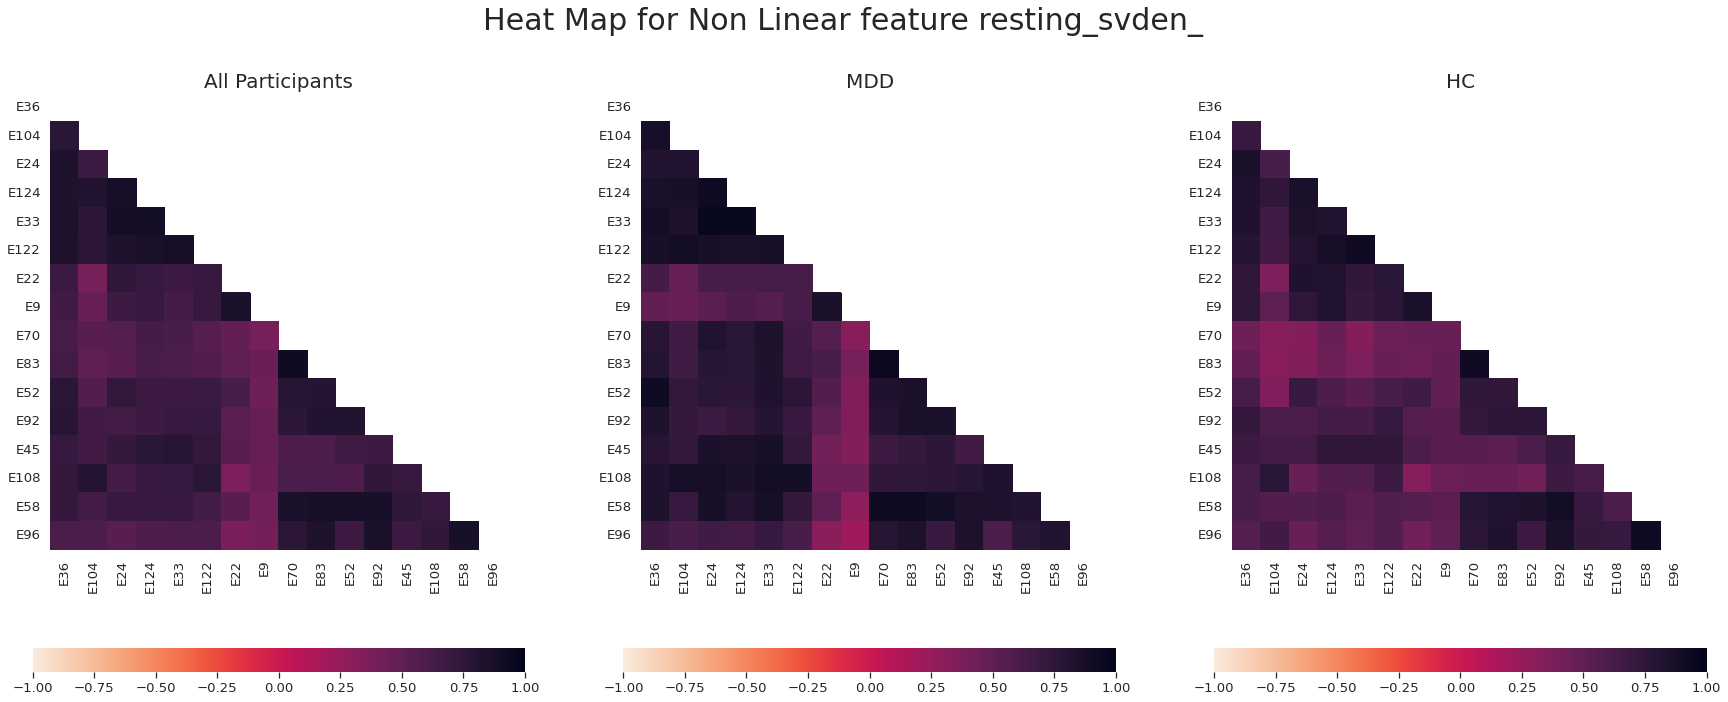

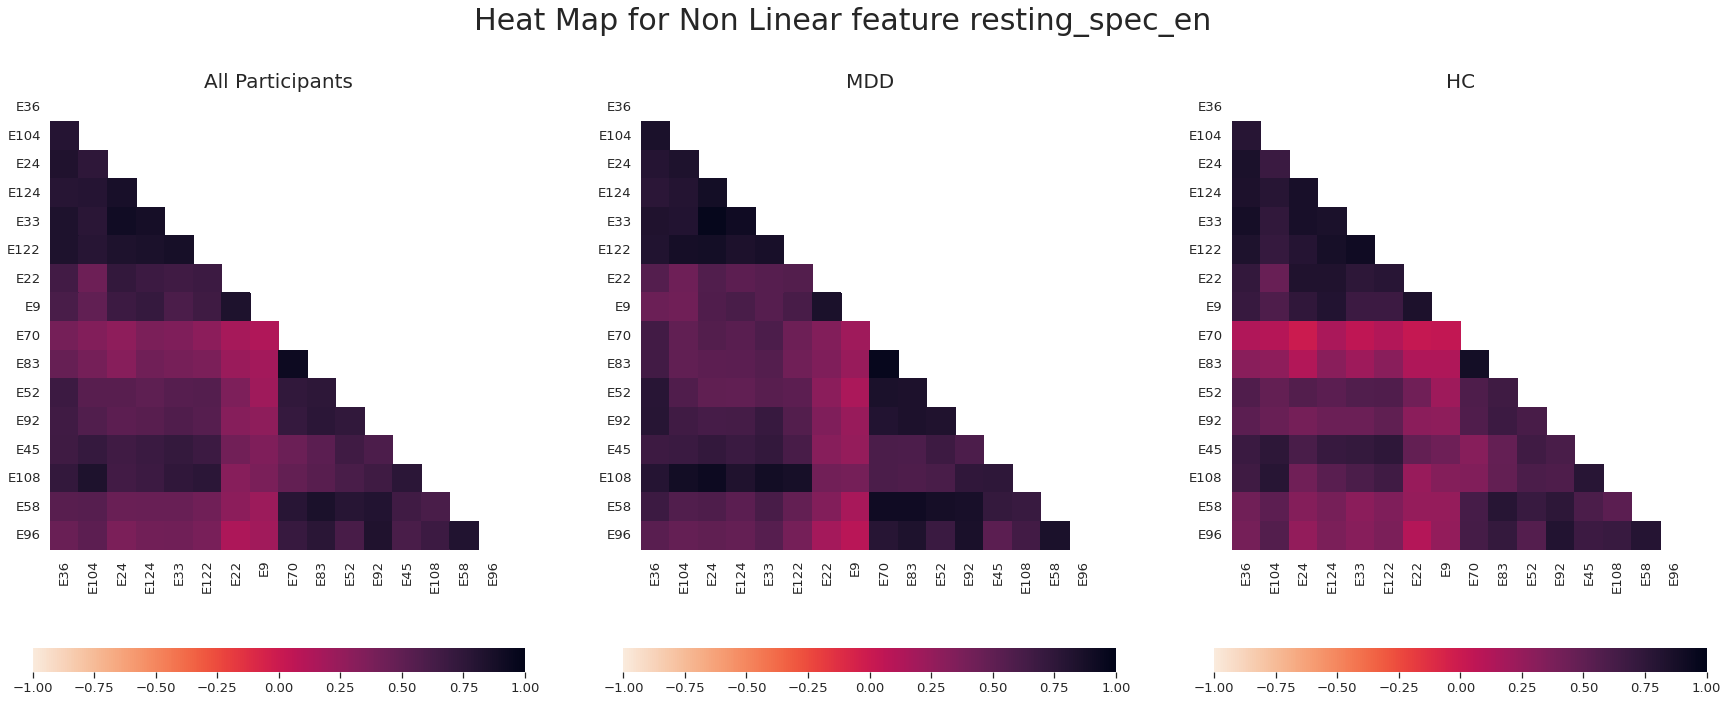

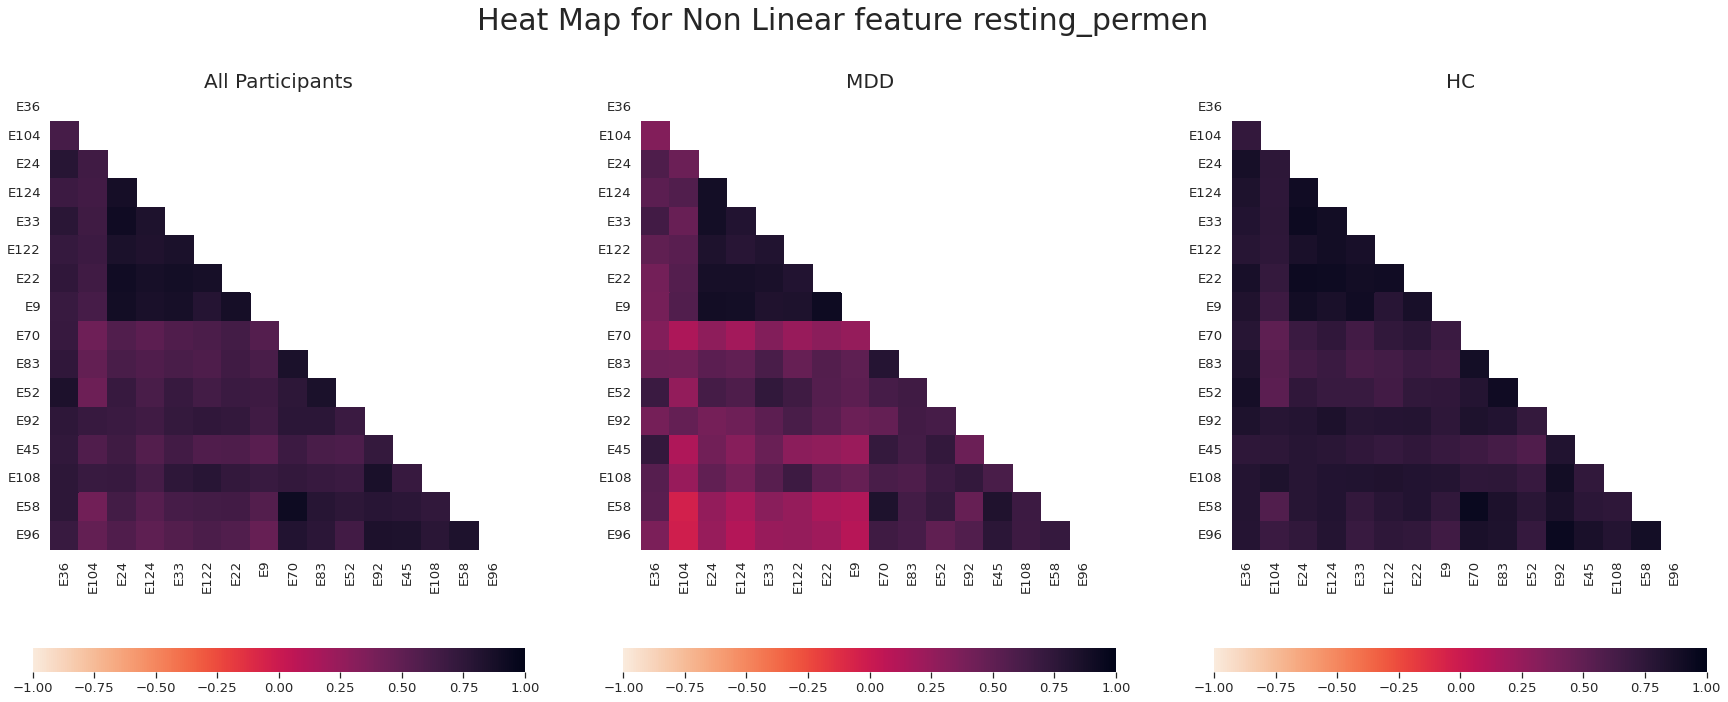

In [ ]:
emotion = 'fear'
for emotion in ['happy','sad','fear','resting']:
  for name in ['svden_','spec_en','permen']:
    temp = columns_extractor(df,emotion,'nl',name)
    a,b = correlation_builder(temp,prefix = 'Non Linear feature '+emotion+'_'+name)
    temp.drop(columns = 'type',inplace=True)
    columns_to_keep.extend(['nl_'+name+emotion+'_'+i for i in temp.columns[column_eliminator(a,thr = 0.8)]])

<b>Interpretation</b>:
Compared to linear features, the non-linear features are highly correlated. Especially, HC participants have highly correlated characteristics across electrodes. The pattern looks to be consistent across all the emotions

Another interesting thing to note is than SVD based Entropy's correlation is less for MDD participants vs. HC participants

# Feature Engineering (PCA)

In [ ]:
len(columns_to_keep)

330

At this stage, we are going to select 401 columns that remained and have correlation not more than 0.8 between each featuree space (we are referring 11 core features that we calculated as feature space as there are various sub features were created on the basis of these features ). We will further investigate the variables in terms of correlation and eliminate them. However, we will try to build synthetic features - PCA based loading factors and see how they can improve the model accuracy

In [ ]:
#General clean up to flag MDD and HC patients. We also drop Gender column
df.type.replace({'MDD':1,'HC':0},inplace=True)
df.drop(columns = 'gender',inplace=True)

In [ ]:
#Lets divide the data set into test and train. Here we have to create a stratified
#sample to create the train and test datasets. While we can use the native SCIKIT learn
#Test, Train splits, we are going to write a custom code here
sample = df.groupby('type', group_keys=False).apply(lambda x: x.sample(round(30*0.7),random_state=42))
left_over = df[~(df.index.isin(list(sample.index)))]

In [ ]:
#Lets create the variables for test and train
y = sample['type']
X = sample.drop(columns = 'type')
X_test = left_over.drop(columns = 'type')
y_test = left_over['type']

In [ ]:
#Eliminate columns that have more than 0.8 correlation between them
df_pca = df[columns_to_keep]
#df_pca.drop(columns = 'type',inplace = True)
columns_to_consider = list(df_pca.columns[column_eliminator(df_pca.corr(),thr = 0.8)])
#columns_to_consider = list(df_pca.columns)

In [ ]:
#Final Set of columns for the exercise - Total of 89 columns were used for this exercise
X = X[columns_to_consider]
X_test = X_test[columns_to_consider]

In [ ]:
#Before building the PCA, we will first scale the dataset to ensure that
#there are no differences in the possible range of values
scalar = StandardScaler()
X_scale = scalar.fit(X).transform(X)
X_scale_test = scalar.transform(X_test)

0     0.163145
1     0.284658
2     0.380343
3     0.454172
4     0.519969
5     0.571466
6     0.615967
7     0.654229
8     0.686863
9     0.718444
10    0.746324
Name: explained var ratio, dtype: float64

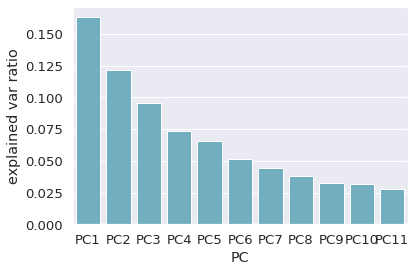

In [ ]:
#Let's first design the 11 Prinicipal components
pca = PCA(n_components = 11,random_state=42).fit(X_scale)

df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11']})
sns.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

In [ ]:
X_PCA_TRAIN = pca.transform(X_scale)
X_PCA_TEST = pca.transform(X_scale_test)

<b>Interpretation</b>

The PCA variances explains that the loading factors are not doing good job in explaining the variance. This might be because of variables that are highly correlated with each other. We will go ahead with these features, however they might perform worse than that of standard features

# Classification models

The process we follow in this section -

1. First build the model with PCA factors that we created in the earlier section
2. Then create models for all the variations of the features - Namely Linear features, Non linear features for all the 

Over the section, we will build multiple models. Depending on how baseline works with various models, we will pick the relevant model for further analysis and work through

In [ ]:
def classifier(X,y,X_test,y_test):
  """
  Input:

  X - Training set
  y - Training outcome
  X_test - Test set
  y_test - Test outcome
  
  Output :
  total - dictionary summarizing performances of various models

  """
  total = dict()
  rf = RandomForestClassifier(random_state=42)
  lr = LogisticRegression(random_state=42)
  knn = KNeighborsClassifier()
  svc = SVC(random_state=42)
  model_array = [rf,lr,knn,svc]
  model_vals = ['Random Forest','Logistic Regression','KNeighbors Classifier','SVC']
  i = 0
  for clf in model_array:
    result = dict()
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    result['accuracy']=round(accuracy_score(y_test, y_pred),2)
    result['precision']=round(precision_score(y_test, y_pred),2)
    result['recall']=round(recall_score(y_test, y_pred),2)
    total[model_vals[i]]=result
    i = i+1
    
  return total

In [ ]:
pca_result = pd.DataFrame(classifier(X_PCA_TRAIN,y,X_PCA_TEST,y_test))
pca_result['base'] = 'PCA factors'
pca_result['emotion'] = 'all'

In [ ]:
final =pca_result.reset_index()

In [ ]:
Vals = list(X.columns)

In [ ]:
for emotion in ['fear','sad','happy','resting','erp','all']:
  for type_vars in ['nl','lf','all']:  
    if emotion =='erp':
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and 'resting' not in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals)) if 'resting' not in Vals[i]]
    elif emotion =='all':
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals))]
    else:
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and emotion in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals)) if emotion in Vals[i]]
      
    temp = classifier(X_scale[:,indices_to_keep],y,X_scale_test[:,indices_to_keep],y_test)
    temp['base'] = type_vars
    temp['emotion'] = emotion
    final = pd.concat([final,pd.DataFrame(temp).reset_index()],axis = 0)
    print(temp)

{'Random Forest': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.2, 'recall': 0.33}, 'KNeighbors Classifier': {'accuracy': 0.55, 'precision': 0.25, 'recall': 0.33}, 'SVC': {'accuracy': 0.73, 'precision': 0.5, 'recall': 0.33}, 'base': 'nl', 'emotion': 'fear'}
{'Random Forest': {'accuracy': 0.64, 'precision': 0.4, 'recall': 0.67}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'KNeighbors Classifier': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'SVC': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'base': 'lf', 'emotion': 'fear'}
{'Random Forest': {'accuracy': 0.73, 'precision': 0.5, 'recall': 1.0}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'KNeighbors Classifier': {'accuracy': 0.64, 'precision': 0.4, 'recall': 0.67}, 'SVC': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'base': 'all', 'emotion': 'fear'}
{'Random Forest': {'accurac

In [ ]:
final.to_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/Model_results.csv')

In [ ]:
columns = ['RF','LR','KNN','SVC','base']
dict_changer = {'Random Forest':'RF','Logistic Regression':'LR','KNeighbors Classifier':'KNN','SVC':'SVC'}
final.rename(columns = dict_changer,inplace = True)

In [ ]:
#final['emotion'] = np.where(final['base']=='PCA factors','PCA factors',final['emotion'])
final['base'] = np.where(final['base']=='PCA factors','all',final['base'])

In [ ]:
for i in list(final['emotion'].unique()):
  print(final[(final['index']=='accuracy')&(final['emotion']==i)])

      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.55  0.55  0.27  0.45  all     all
0  accuracy  0.27  0.55  0.27  0.36   nl     all
0  accuracy  0.45  0.55  0.55  0.73   lf     all
0  accuracy  0.55  0.64  0.36  0.73  all     all
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.36  0.45  0.55  0.73   nl    fear
0  accuracy  0.64  0.45  0.45  0.36   lf    fear
0  accuracy  0.73  0.45  0.64  0.36  all    fear
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.27  0.45  0.55  0.45   nl     sad
0  accuracy  0.73  0.82  0.64  0.45   lf     sad
0  accuracy  0.64  0.73  0.55  0.45  all     sad
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.64  0.36  0.27  0.27   nl   happy
0  accuracy  0.55  0.55  0.55  0.36   lf   happy
0  accuracy  0.45  0.55  0.36  0.36  all   happy
      index    RF    LR   KNN   SVC base  emotion
0  accuracy  0.27  0.36  0.36  0.27   nl  resting
0  accuracy  0.27  0.64  0.73  0.64   lf  resting
0  accuracy  0.27

In [ ]:
def metric_analyzer(df,model='RF',emotion='all',base='all',measure='accuracy'):
  """
  Inputs:
  df - Dataframe to be used
  model - model to be plotted
  emotion - type of emotion needed
  base - type of feature space use
  measure - Are we going to choose Accuracy / Precision / Recall
  Outputs:
  chart object - This will be saved for future reference
  """
  #Filter the resultant data frame
  fig = plt.figure(figsize = (20, 5))
  a = dict()
  text = ['All Features','Non Linear Features','Linear Features']
  val = 0
  for base in df.base.unique():
    a[val] = fig.add_subplot(1,3,val+1)
    df_final = df[(df['base']==base)&(df['index']==measure)][['emotion',model]].sort_values('RF',ascending = False)
    df_final.replace({'PCA factors':'PCA'},inplace=True)
    X = df_final.emotion.values
    Y = df_final[model].values
    a[val].bar(X, Y, width = 0.4)
    a[val].set_ylim(0,1)
    a[val].set_title('\n'+text[val])
    a[val].hlines(df_final[df_final['emotion']=='all'][model].values[0],0,7)
    a[val].text(2, df_final[df_final['emotion']=='all'][model].values[0]+0.05, 'Better than Base line\n(All emotions model)', rotation=0)
    #a[val].set_xticks(rotation = 90)
    val = val+1
  fig.suptitle(measure.upper()+' of various feature types (model='+model+')')
  path_to_save = '/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/Model_'+model+'.png'
  fig.savefig(path_to_save,dpi = 100)


In [ ]:
final.to_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Images/Model_results.csv')

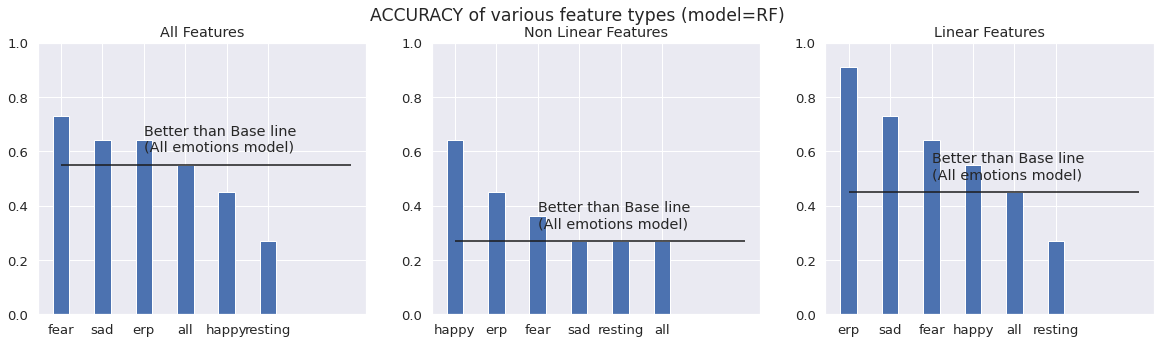

In [ ]:
metric_analyzer(final)

<b>Interpretation</b>

We are chosing Random forest here over all the other models. The main reason for prefering this model is its highest accuracy when we opt for ERP based model on the linear features (~91%). While the results can be highly volatile given that we only have 11 participants in the Test set. Key points-

1. At an overall level, the model with all features related to <b>Fear</b> works exceptionally well compared to other variants of features
2. If we consider Non linear features only, the accuracy of the models are not great. Probably worse than 50% probability. Hence Non Linear Features may not be any ideal choice for any analysis. However, it is important to note that, we over simiplified the non-linear features due to certain limitations in the Python package. Given we considered the entire process flow that was shared by researchers, we would have seen considerable improvement in the results
3. Linear Features based models works really well compared to all the other features that's present. The ERP based features with an accuracy of 91% stands out of all the other cases. Over the next section, we will utilize two of the modeling variants and try explaning how various features are related to the prediction values

# Model Interpretation

We will be chosing two models in specific -

1. Fear related dataset with both Linear and Non Linear Features (73% Accuracy)
2. ERP related dataset with only Linear Features (91% Accuracy)

We will utilize the Shapley library to plot the charts. To assist us in this exercise, we are going to write a simple function that extacts the dataset, required columns and gives the shapley charts for ready reference. We will further explain how can we read the shapley chart

In [ ]:
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}
Electrode_understanding = dict((v,k) for k,v in Electrode_understanding.items())

In [ ]:
array_vals = ['lf_min_fear_E122', 'lf_median_fear_E45', 'lf_median_fear_E9',
 'lf_median_fear_E122', 'lf_min_fear_E83', 'lf_min_fear_E45',
 'lf_median_fear_E104', 'nl_permenfear_E22', 'lf_median_fear_E83',
 'lf_delta_fear_E9', 'lf_median_fear_E108', 'lf_min_fear_E104','nl_svden_fear_E24']

In [ ]:
def shapley_chart_builder(model=RandomForestClassifier(random_state=42),type = 1):
  """
  Input -
  model - Model on which we have to build the shapley chart
  type = 1 - Indicates model for Fear (all variables)
         0 - Indicated model for ERP with only Linear Features
  Output -
  Shapley dot plot 
  """
  if type == 1:
    Columns_to_select = [i for i in range(len(Vals)) if 'fear' in Vals[i]]
    print(Columns_to_select)
  else:
    Columns_to_select = [i for i in range(len(Vals)) if 'lf' in Vals[i] and 'resting' not in Vals[i]]
  print(str(len(Columns_to_select))+' columns are selected for the exercise')
  #Model to be selected
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X_scale[:,Columns_to_select], y)
  y_pred = rf.predict(X_scale_test[:,Columns_to_select])
  print("************")
  print("Model Diagnostics")
  print(round(accuracy_score(y_test, y_pred),2))
  print(round(precision_score(y_test, y_pred),2))
  print(round(recall_score(y_test, y_pred),2))
  print("************")
  print("Start of Shapley interpretations")
  explainer = shap.TreeExplainer(rf)
  shap_values = explainer.shap_values(X_scale_test[:,Columns_to_select],y_test)
  column_names = [Vals[i] for i in Columns_to_select]
  list_1 = [Electrode_understanding[j] for j in [i.split('_')[-1] for i in column_names]]
  list_2 = [i.split('_')[0] for i in column_names]
  list_3 = [i.split('_')[1] for i in column_names]
  list_4 = [i.split('_')[-1] for i in column_names]
  final = [list_1[i]+' ('+list_2[i]+' '+list_3[i]+'-'+list_4[i]+')' for i in range(len(list_2))]
  shap.summary_plot(shap_values[0], X_scale_test[:,Columns_to_select], plot_type="dot",feature_names = final)
  temp = np.abs(shap_values[0]).mean(0)
  feature_importance = pd.DataFrame(list(zip(column_names, final,temp)),columns=['col_name','alias_name','feature_importance_vals'])
  feature_importance.sort_values(by=['feature_importance_vals'],ascending=False, inplace=True)
  #feature_importance.head()
  #return feature_importance
  return feature_importance


[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 73, 74]
13 columns are selected for the exercise
************
Model Diagnostics
0.73
0.5
1.0
************
Start of Shapley interpretations


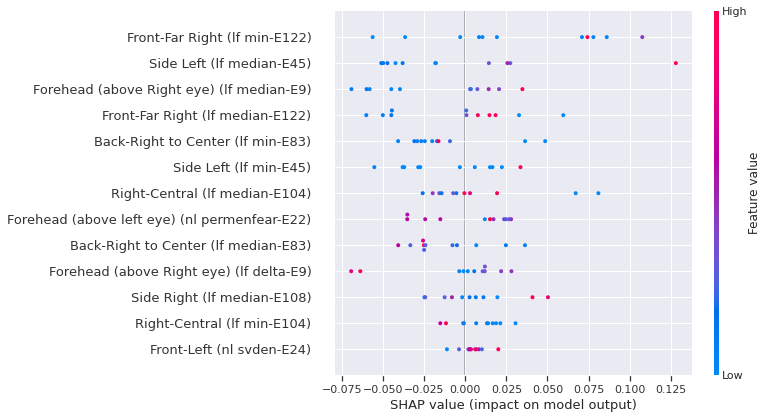

In [ ]:
test = shapley_chart_builder(type = 1)

<b>Interpretation</b>


In [ ]:
test

,col_name,alias_name,feature_importance_vals
1,lf_min_fear_E122,Front-Far Right (lf min-E122),0.050110
8,lf_median_fear_E45,Side Left (lf median-E45),0.041888
6,lf_median_fear_E9,Forehead (above Right eye) (lf median-E9),0.032328
5,lf_median_fear_E122,Front-Far Right (lf median-E122),0.030402
2,lf_min_fear_E83,Back-Right to Center (lf min-E83),0.027336
3,lf_min_fear_E45,Side Left (lf min-E45),0.025750
4,lf_median_fear_E104,Right-Central (lf median-E104),0.023615
12,nl_permenfear_E22,Forehead (above left eye) (nl permenfear-E22),0.023391
7,lf_median_fear_E83,Back-Right to Center (lf median-E83),0.023205
10,lf_delta_fear_E9,Forehead (above Right eye) (lf delta-E9),0.020841


Through the above table, we can understand the various features and how they helped to profile the Depression patients. First let's understand the SHAPLEY chart

1. X-axis represents the Shapley value that gives score for columns as log odd values. To understand it, the higher the value higher the odds of supporting the direction
2. Y-axis is the various features that we used for the classification exercise
3. The intensity of the dots varies from shades of Blue to Red. The Blue value indicates that the class label is 0. In this case, they are healthy controls (HC). While on the other note, the Red value indicates that the class label is 1 - Analogous to our participants with Depression (MDD)
4. For a single row, if there are more dots in the far right of the reference line (SHAP value = 0), then it means it plays a significant role in classification. At the same instance, if the dot in the right side is Red in intensity, that means higher the value of a given feature, more chances that the individual belongs to class label 1 (Sort of directly proportion with the class variable 1)

Now that we understood the features, lets dwell into the understanding for the Fear based features.

1. The Front sided electrodes play significant role in differentiating the HC (Healthy Controls) and MDD (Depression) individual. Out of the top 5 features in the above chart, electrodes E122, E9, E122 belongs to the front region of the scalp
2. The electrodes E122 (Far Front right), E22 (Front above left eye) are strong indicators for identifying the depression patients
3. Linear featutes in general have higher distinguishable power between the labels as we observed across the labels

Few closing comments -

1. Sample size of the patients is a huge challenge here. Given an opportunity, we would like to design an experiment where more participants are involved and balanced across the participant demographics

To support the understanding, we also plotted the density plots that aids in interpreting the results from SHAPLEY



In [ ]:
#Density plots to help us understand the features
def kernel_builder(column = "nl_permenfear_E22"):
  fig = plt.figure(figsize = (5, 5))
  sns.kdeplot(data=df, x=column,log_scale=True,fill=True,hue = 'type')

In [ ]:
for col in test['col_name']:
  kernel_builder(col)

# Conclusion

With a reasonable accuracy of 72%, we are able to identify the MDD patients when they were shown Fear-Neutral images. While the other model with all ERP features show a 91% accuracy, the high degree of dimensions resulted us to not opt for explaining it further

We acknowledge that the participant samples that we have are limited in number and the model stability might vary when it is shown larger set of participants

We can further explore <b>Few Shots learning</b> to simulate more training samples to build more confidence on the model output. However, the challenges of implementing various standard scientific techniques in Python is limiting our ability to go ahead in that direction. There are few suggestions to utilize the temportal data and build an LSTM based models. However, the lack of computational power had limited us to not explore this route